In [2]:
import pandas as pd 
import numpy as np
from tqdm import tqdm
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier 
import pickle
import gzip
import pandas as pd
import os 
import matplotlib.pyplot as plt
import seaborn as sns

# Training matrix: base presence-absence table 

In [3]:
training_matrix = pd.read_csv('../data/presence_absence_4083.csv')

# Extract cluster reps to use for PhagePleats search DB

In [4]:
training_matrix['cluster_ID_function'].str.split(':').str[0].to_csv('../data/cluster_reps.csv',index=False)

In [5]:
# Transpose training data so genomes are rows
training_matrix_T = training_matrix.T
training_matrix_T.columns = training_matrix_T.iloc[0]
training_matrix_T = training_matrix_T.drop(training_matrix_T.index[0])

# RED assigned taxonomy metadata

In [6]:
taxa_df = pd.read_csv('../data/RED_taxonomy.csv')

# Train multiple One vs. All (OvA) models

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Merge training features with taxa labels
df = taxa_df.merge(training_matrix_T, left_on='Leaves', right_index=True)

# Training approach:
## 1. Downsample training set

    * Ensures a controlled number of samples per taxon (e.g., 2, 5, 10, ..., 200).

    * Makes performance comparison fair across taxa by normalizing class size.

## 2. Train binary classifiers

    * For each taxon in y_train, trains a binary classifier: "taxon vs all others".

    * Uses RandomForestClassifier with class_weight="balanced" to handle imbalance.

    * Trains this for each taxon above a frequency threshold (i.e., min_taxa_count).

## 3. Benchmarks across training sizes

    * Loops over a range of training sizes to simulate a learning curve.

    * Evaluates performance using:

        -Accuracy

        -Cross-validation accuracy

        -AUROC

        -Precision, Recall, F1 (both positive and negative classes)

## 4. Stores and exports results

    * Saves results as .csv files (classification metrics and feature importances).

    * Outputs per-rank, per-train-size performance, enabling comparative plots.



# 1. Create train and test sets

In [8]:
def filter_low_count_taxa(df, rank, min_count=5):
    """
    Filters the input DataFrame to include only taxa at the specified rank
    with at least `min_count` instances.

    Parameters:
        df (pd.DataFrame): The DataFrame with the taxon column.
        rank (str): The column name representing the taxonomic rank.
        min_count (int): Minimum number of samples per taxon to keep.

    Returns:
        pd.DataFrame: Filtered DataFrame with only valid taxa.
    """
    counts = df[rank].value_counts()
    valid_taxa = counts[counts >= min_count].index
    return df[df[rank].isin(valid_taxa)].copy()

In [9]:
# Split training and test.....
def create_train_test(df, training_matrix_T, rank='Order'):
    df = df.dropna(subset=[rank], axis=0)
    X = df[training_matrix_T.columns]
    y = df[rank]
    # Split data into train (80%) and test (20%) with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    return X_train, X_test, y_train, y_test

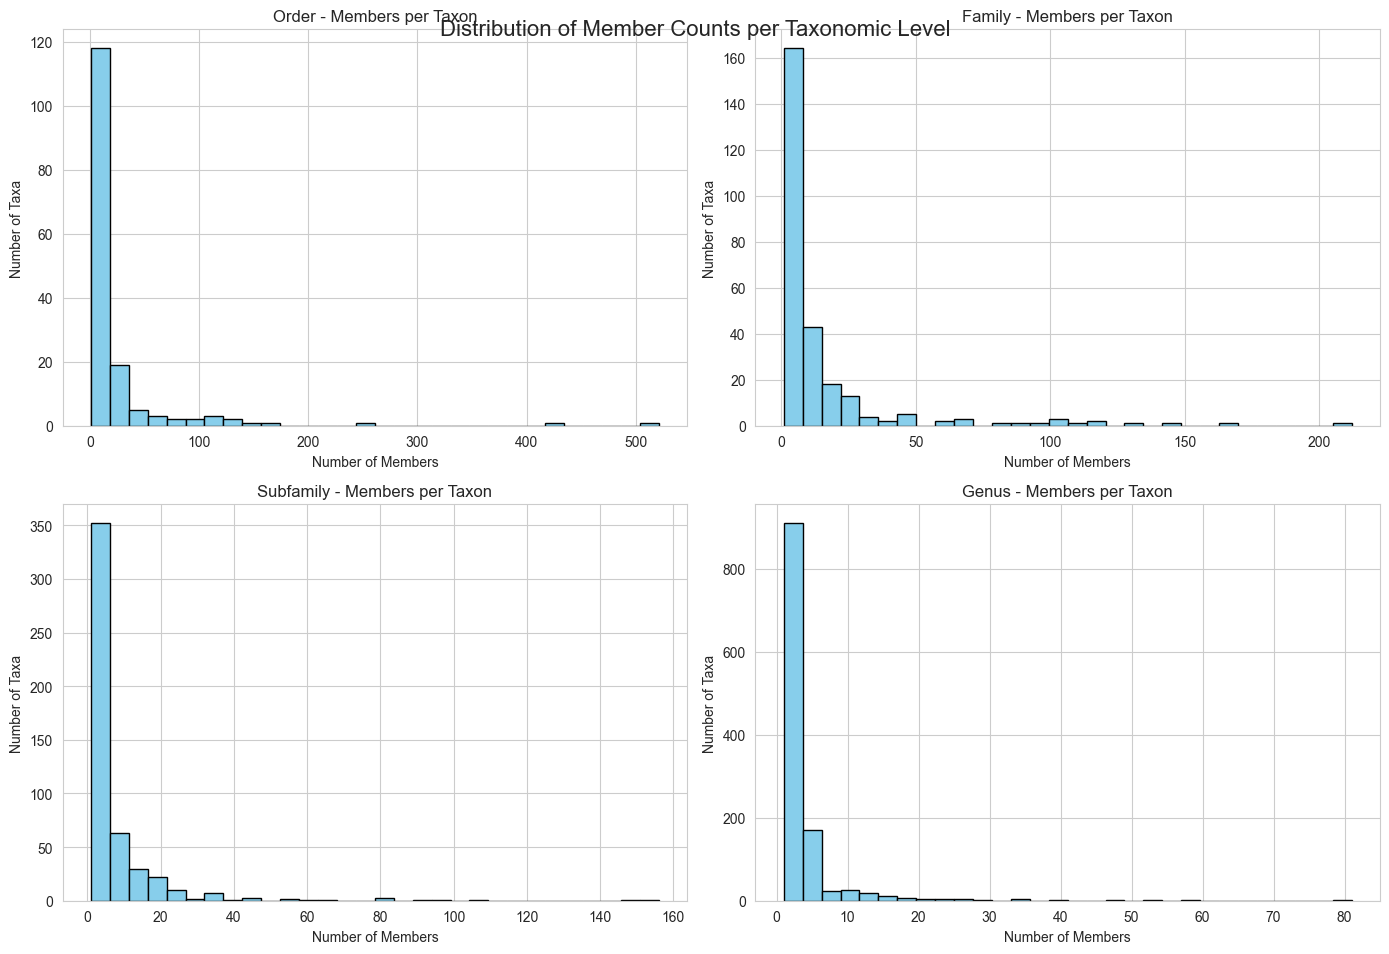

In [10]:
import matplotlib.pyplot as plt

# Apply whitegrid style
sns.set_style('whitegrid')

# List of taxonomic levels to include
tax_levels = ['Order', 'Family', 'Subfamily', 'Genus']

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, level in enumerate(tax_levels):
    counts = df.groupby(level)['Leaves'].count()
    axes[i].hist(counts, bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(f'{level} - Members per Taxon')
    axes[i].set_xlabel('Number of Members')
    axes[i].set_ylabel('Number of Taxa')

# Add a main title
fig.suptitle('Distribution of Member Counts per Taxonomic Level', fontsize=16, y=0.94)
fig.savefig('../plots/taxonomic_member_counts_distributions.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [72]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import learning_curve

def downsample_taxa(X, y, rank, target_count):
    """
    Downsample only taxa with at least `target_count` instances to exactly that many.
    """
    df = X.copy()
    df[rank] = y  # attach labels
    
    valid_taxa = df[rank].value_counts()
    valid_taxa = valid_taxa[valid_taxa >= target_count].index  # only those with enough samples
    
    df = df[df[rank].isin(valid_taxa)]
    
    df_downsampled = (
        df.groupby(rank)
        .apply(lambda x: x.sample(n=target_count, random_state=42))
        .reset_index(drop=True)
    )
    
    return df_downsampled.drop(columns=[rank]), df_downsampled[rank]

def plot_learning_curve(estimator, X, y, title="Learning Curve"):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10), scoring="accuracy"
    )

    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training accuracy")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Validation accuracy")
    plt.xlabel("Training set size")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_roc_curve(y_test_binary, y_pred_proba, taxon):
    """Plot ROC curve for a given taxon."""
    fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Random classifier (diagonal line)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {taxon}')
    plt.legend(loc="lower right")
    plt.show()

def plot_pr_curve(y_test_binary, y_pred_proba, taxon):
    precision, recall, _ = precision_recall_curve(y_test_binary, y_pred_proba)
    ap_score = average_precision_score(y_test_binary, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2,
             label=f'PR curve (AP = {ap_score:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {taxon}')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

def plot_probability_distribution(y_pred_proba, y_true, taxon):
    sns.histplot(y_pred_proba[y_true == 1], bins=20, color="blue", label="Positive Class", kde=True)
    sns.histplot(y_pred_proba[y_true == 0], bins=20, color="red", label="Negative Class", kde=True)
    plt.axvline(0.5, linestyle="--", color="black", label="Decision Threshold")
    plt.legend()
    plt.title(f"Probability Distribution for {taxon}")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.show()

def train_binary_classifiers(X_train, X_test, y_train, y_test, training_matrix_T, min_taxa_count=5, rank='Order'):
    results = []  
    feature_importances_all = {} 
    
    # Calculate median taxa count
    if not min_taxa_count:
        min_taxa_count = int(y_train.value_counts().median())  
    #print(f"Balancing all taxa to {min_taxa_count} instances each.")

    #train_sizes = [5,10,20,30,50,100,200]
    #train_sizes = [5,10,25,50,75,100]
 
    train_sizes = [5, 7, 10, 15, 20,30] 

    # Downsample taxa with counts above median
    for size in train_sizes:
        X_train_balanced, y_train_balanced = downsample_taxa(X_train, y_train, rank, size)
        print(f"Balancing all taxa to {size} instances each.")
        print(f"Balanced Train Shape: {X_train_balanced.shape}, Unique taxa: {y_train_balanced.nunique()}")
        print(f"Y Train Value Counts: {y_train_balanced.value_counts()}")
        
        # Only taxa exactly downsampled to `size`
        taxa_counts = y_train_balanced.value_counts()
        taxa_exact_size = taxa_counts[taxa_counts == size].index

        print(f"Y Train Training Value Counts: {taxa_counts.value_counts()}")

        # Train classifiers for each taxon
        for taxon in tqdm(taxa_exact_size, desc=f"Training {rank} classifiers.."):
            print(f"Training {taxon} vs. rest with size {size}")
    
            y_train_binary = (y_train_balanced == taxon).astype(int)
            y_test_binary = (y_test == taxon).astype(int)
    
            model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
            model.fit(X_train_balanced, y_train_binary)

            # Collect feature importances
            feature_importances = model.feature_importances_
            feature_names = X_train_balanced.columns  
            feature_importance_mapping = dict(zip(feature_names, feature_importances))
            if taxon not in feature_importances_all:
                feature_importances_all[taxon] = []
            feature_importances_all[taxon].append({"Train Size": size, "Importances": feature_importance_mapping})  # ✅ Add training size to feature importances
    
            # Cross-validation
            if y_train_binary.sum() >= 5:
                cross_val_scores = cross_val_score(model, X_train_balanced, y_train_binary, cv=5)
                cross_val_mean = cross_val_scores.mean()
            else:
                cross_val_scores = np.array([np.nan])
                cross_val_mean = np.nan
    
            # Test set evaluation
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            
            try:
                auroc = roc_auc_score(y_test_binary, y_pred_proba) if y_test_binary.sum() > 1 else float('nan')
            except Exception as e:
                print(f"AUROC error: {e}")
                auroc = float('nan')
    
            accuracy = accuracy_score(y_test_binary, y_pred)
            report = classification_report(y_test_binary, y_pred, output_dict=True, zero_division=0)
    
            precision_1 = report.get("1", {}).get("precision", float('nan'))
            recall_1 = report.get("1", {}).get("recall", float('nan'))
            f1_1 = report.get("1", {}).get("f1-score", float('nan'))
    
            precision_0 = report.get("0", {}).get("precision", float('nan'))
            recall_0 = report.get("0", {}).get("recall", float('nan'))
            f1_0 = report.get("0", {}).get("f1-score", float('nan'))
    
            model_dir = f"models/{rank}_bg"
            # os.makedirs(model_dir, exist_ok=True)
            model_filename = f"{model_dir}/{taxon}.pkl"
    
            # with open(model_filename, "wb") as f:
            #     pickle.dump(model, f)
    
            # Store results
            results.append({
                "Train Size": size,
                "Dataset": "focal",
                "Level": rank,
                "Taxon": taxon,
                "Training_Leaves_Count": y_train_binary.sum(),
                "Model_Path": model_filename,
                "Accuracy": accuracy,
                "Cross_Val_Accuracy": cross_val_scores.mean(),
                "AUROC": auroc,
                "Precision_0": precision_0,
                "Recall_0": recall_0,
                "F1_0": f1_0,
                "Precision_1": precision_1,
                "Recall_1": recall_1, 
                "F1_1": f1_1,
                "Average_Precision": average_precision_score(y_test_binary, y_pred_proba)
            })
    
    # Save results
    results_df = pd.DataFrame(results)
    results_df.to_csv(f"../data/classification_models_{rank}_train_sizes.csv", index=False)
    
    # Flatten feature importances
    feature_importances_flat = []
    for taxon, entries in feature_importances_all.items():
        for entry in entries:
            size = entry["Train Size"]
            for feature, importance in entry["Importances"].items():
                feature_importances_flat.append({"Train Size": size, "Taxon": taxon, "Feature": feature, "Importance": importance})

    feature_importances_df = pd.DataFrame(feature_importances_flat)
    feature_importances_df.to_csv(f"../data/feature_importances_{rank}_train_sizes.csv", index=False)
    
    print(f"Models saved and results stored in classification_models_{rank}_train_sizes.csv")
    return results_df, feature_importances_df

In [ ]:
from matplotlib.colors import ListedColormap

def plot_training_metrics(results, combined_palette, rank="Family", output_file="training_metrics.png",
                                  bottom_spacing=0.6, num_col_legend=6, bbox_to_anchor1_y=-2.0, bbox_to_anchor2_y=-0.5):
    """
    Generate a two-panel plot:
    1. Left: Stacked bar plot of taxon counts normalized per train size.
    2. Right: Scatter plot of model metrics vs train size, including cross-val accuracy.

    Parameters:
    - results (pd.DataFrame): DataFrame with training results including metrics and taxa information
    - combined_palette (list): List of color hex codes or color names
    - rank (str): Taxonomic rank (e.g., 'Family', 'Order') for dynamic labeling
    - output_file (str): File path to save the plot
    """

    sns.set_style("whitegrid", {
        'axes.edgecolor': 'black',
        'grid.color': 'grey',
        'legend.frameon': True,
        'legend.edgecolor': 'grey',
        'legend.facecolor': 'white'
    })

    # Normalize for stacked bar plot
    results = results.copy()
    results["Normalized"] = results.groupby("Train Size")["Training_Leaves_Count"].transform(lambda x: (x / x.sum()) * 100)
    df_pivot = results.pivot(index="Train Size", columns="Taxon", values="Normalized").fillna(0)

    # Create colormap
    colormap = ListedColormap(combined_palette)

    results = results.rename(columns={"Average_Precision": "Average_Precision_AUPRC"})

    # Metrics to plot (including CV accuracy)
    selected_metrics = ['AUROC', 'Average_Precision_AUPRC', 'F1_1', 'Recall_1', 'Precision_1', 'Cross_Val_Accuracy']

    # Grouped average metrics
    df_grouped = results.groupby("Train Size")[selected_metrics].mean().reset_index()

    # Set up the figure
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1.4, 1]})
    plt.subplots_adjust(bottom=0.35, wspace=0.3)

    # --- Left plot: Stacked bar chart ---
    df_pivot.plot(kind="bar", stacked=True, colormap=colormap, edgecolor="black", linewidth=0.7, ax=axes[0])
    axes[0].set_title(f"{rank} Training Leaves Taxa Count by Train Size", fontsize=14)
    axes[0].set_xlabel("Train Size")
    axes[0].set_ylabel("Percentage (%)")
    axes[0].set_ylim(0, 100)
    axes[0].grid(axis="y", linestyle="--", alpha=0.7)
    axes[0].tick_params(axis='x', labelrotation=0)

    # --- Right plot: Metrics scatter plot ---
    metric_colors = {
        "AUROC": "tab:green",
        "Average_Precision_AUPRC": "orange",
        "Recall_1": "#98CD00",
        "Precision_1": "#ED3500",
        "F1_1": "#0D5EA6",
        "Cross_Val_Accuracy": "#B13BFF"
    }
    metric_markers = {
        "AUROC": "X",
        "Average_Precision_AUPRC": "s",
        "Recall_1": "P",
        "Precision_1": "D",
        "F1_1": "^",
        "Cross_Val_Accuracy": "o"
    }

    for metric in selected_metrics:
        jitter = np.random.uniform(-0.4, 0.4, size=len(df_grouped))
        sns.scatterplot(
            x=df_grouped["Train Size"] + jitter,
            y=df_grouped[metric],
            label=metric,
            ax=axes[1],
            s=70,
            color=metric_colors[metric],
            marker=metric_markers[metric],
            edgecolor="black",
            linewidth=0.5
        )

    axes[1].axhline(y=0.95, color="r", linestyle="--", label="95% Threshold")
    axes[1].set_title(f"Training Size vs Model Metrics ({rank} level)", fontsize=14)
    axes[1].set_xlabel("Train Size")
    axes[1].set_ylabel("Performance")
    axes[1].set_ylim(0.2, 1.05)
    axes[1].grid(True)

    # Legends
    handles1, labels1 = axes[0].get_legend_handles_labels()
    axes[0].legend(
        handles1, labels1,
        loc='lower center',
        bbox_to_anchor=(0.5, bbox_to_anchor1_y),
        ncol=num_col_legend,
        fontsize=7,
        title=f"{pluralize_rank(rank)}",
        frameon=True,
        edgecolor='grey'
    )

    handles2, labels2 = axes[1].get_legend_handles_labels()
    axes[1].legend(
        handles2, labels2,
        loc='lower center',
        bbox_to_anchor=(0.5, bbox_to_anchor2_y),
        ncol=3,
        fontsize=9,
        title="Metrics",
        frameon=True,
        edgecolor='grey'
    )

    plt.subplots_adjust(bottom=bottom_spacing)
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.show()

def pluralize_rank(rank):
    if rank.lower() == "order":
        return "Orders"
    elif rank.lower() == "family":
        return "Families"
    elif rank.lower() == "subfamily":
        return "Subfamilies"
    elif rank.lower() == "genus":
        return "Genera"
    else:
        return f"{rank}s"

In [ ]:
import colorcet as cc
import random

# Set the seed
random.seed(2)

# Define multiple palettes
palette1 = sns.color_palette("Set3", 8)
palette2 = sns.color_palette("Set1", 8)
palette3 = sns.color_palette("Dark2", 8)
palette4 = sns.color_palette("viridis", 12)
palette5 = sns.color_palette("magma", 12)
palette6 = sns.color_palette("inferno", 12)
palette7 = sns.color_palette("cividis", 12)
palette8 = sns.color_palette("Spectral", 9)
palette9 = sns.color_palette("RdYlBu", 9)
palette10 = sns.color_palette("Paired", 12)
palette11 = sns.color_palette("tab20", 20)
palette12 = sns.color_palette("tab10", 10)
palette13 = sns.color_palette("pastel", 10)
palette14 = sns.color_palette("husl", 10)
palette15 = sns.color_palette("coolwarm", 10)
palette16 = list(plt.cm.viridis.colors)
palette17 = list(plt.cm.plasma.colors)
palette18 = list(plt.cm.inferno.colors)
palette19 = list(plt.cm.magma.colors)
palette20 = list(plt.cm.cividis.colors)
palette21 = list(cc.glasbey)  # High-contrast categorical palette from colorcet

# Combine all palettes into one large list
combined_palette = (palette1 + palette2 + palette3 + palette4 + palette5 + palette6 +
                    palette7 + palette8 + palette9 + palette10 + palette11 + palette12 +
                    palette13 + palette14 + palette15 + palette16 + palette17 + palette18 +
                    palette19 + palette20 + palette21)

# Shuffle the combined palette in place
random.shuffle(combined_palette)

# Now combined_palette is shuffled, no need to assign to final_palette
# Display the first 100 shuffled colors
fig, ax = plt.subplots(figsize=(12, 2))
for i, color in enumerate(combined_palette[:100]):  # Show the first 100 colors
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))
ax.set_xlim(0, 100)
ax.set_yticks([])
ax.set_xticks([])
plt.show()

# 1.1. Train downsampled Order and plot performance by train size

In [33]:
filtered_df = filter_low_count_taxa(df, rank='Order', min_count=5)

X_train, X_test, y_train, y_test = create_train_test(filtered_df, training_matrix_T, rank='Order')

order_results, feature_importances_df = train_binary_classifiers(X_train, X_test, y_train, y_test, training_matrix_T, min_taxa_count=5, rank='Order')

Balancing all taxa to 5 instances each.
Balanced Train Shape: (470, 20289), Unique taxa: 94
Y Train Value Counts: Order
Aliceevansvirales        5
Krisvirales              5
Mesyanzhinovvirales_1    5
Masamunevirales          5
Mangonelvirales          5
                        ..
Doryvirales              5
Dirkvirales              5
Derringervirales         5
Daovirales               5
Zierdtvirales            5
Name: count, Length: 94, dtype: int64
Y Train Training Value Counts: count
5    94
Name: count, dtype: int64


Training Order classifiers..:   0%|                                                             | 0/94 [00:00<?, ?it/s]

Training Aliceevansvirales vs. rest with size 5


Training Order classifiers..:   1%|▌                                                    | 1/94 [00:07<11:28,  7.41s/it]

Training Krisvirales vs. rest with size 5


Training Order classifiers..:   2%|█▏                                                   | 2/94 [00:14<11:05,  7.23s/it]

Training Mesyanzhinovvirales_1 vs. rest with size 5


Training Order classifiers..:   3%|█▋                                                   | 3/94 [00:20<10:19,  6.81s/it]

Training Masamunevirales vs. rest with size 5


Training Order classifiers..:   4%|██▎                                                  | 4/94 [00:27<10:16,  6.85s/it]

Training Mangonelvirales vs. rest with size 5


Training Order classifiers..:   5%|██▊                                                  | 5/94 [00:35<10:26,  7.04s/it]

Training Mambelevirales vs. rest with size 5


Training Order classifiers..:   6%|███▍                                                 | 6/94 [00:42<10:15,  7.00s/it]

Training Madisavirales vs. rest with size 5


Training Order classifiers..:   7%|███▉                                                 | 7/94 [00:50<10:45,  7.42s/it]

Training Machetevirales vs. rest with size 5


Training Order classifiers..:   9%|████▌                                                | 8/94 [01:01<12:24,  8.65s/it]

Training Lassovirales vs. rest with size 5


Training Order classifiers..:  10%|█████                                                | 9/94 [01:13<13:44,  9.70s/it]

Training Laevateinnvirales vs. rest with size 5


Training Order classifiers..:  11%|█████▌                                              | 10/94 [01:23<13:44,  9.82s/it]

Training Labrysvirales vs. rest with size 5


Training Order classifiers..:  12%|██████                                              | 11/94 [01:34<13:50, 10.00s/it]

Training Kilijvirales vs. rest with size 5


Training Order classifiers..:  13%|██████▋                                             | 12/94 [01:39<11:54,  8.71s/it]

Training Mizrakvirales vs. rest with size 5


Training Order classifiers..:  14%|███████▏                                            | 13/94 [01:46<10:48,  8.01s/it]

Training Khopeshvirales vs. rest with size 5


Training Order classifiers..:  15%|███████▋                                            | 14/94 [01:53<10:11,  7.65s/it]

Training Kestrosvirales vs. rest with size 5


Training Order classifiers..:  16%|████████▎                                           | 15/94 [01:59<09:37,  7.31s/it]

Training Kamikazevirales vs. rest with size 5


Training Order classifiers..:  17%|████████▊                                           | 16/94 [02:06<09:27,  7.27s/it]

Training Kamavirales vs. rest with size 5


Training Order classifiers..:  18%|█████████▍                                          | 17/94 [02:14<09:21,  7.29s/it]

Training Kalisvirales vs. rest with size 5


Training Order classifiers..:  19%|█████████▉                                          | 18/94 [02:20<08:59,  7.09s/it]

Training Jittevirales vs. rest with size 5


Training Order classifiers..:  20%|██████████▌                                         | 19/94 [02:28<08:55,  7.14s/it]

Training Jambiyavirales vs. rest with size 5


Training Order classifiers..:  21%|███████████                                         | 20/94 [02:34<08:34,  6.95s/it]

Training Iklwavirales vs. rest with size 5


Training Order classifiers..:  22%|███████████▌                                        | 21/94 [02:41<08:19,  6.84s/it]

Training Hungamungavirales vs. rest with size 5


Training Order classifiers..:  23%|████████████▏                                       | 22/94 [02:48<08:26,  7.04s/it]

Training Mesyanzhinovvirales_2 vs. rest with size 5


Training Order classifiers..:  24%|████████████▋                                       | 23/94 [02:55<08:13,  6.95s/it]

Training Muramasavirales vs. rest with size 5


Training Order classifiers..:  26%|█████████████▎                                      | 24/94 [03:02<08:08,  6.98s/it]

Training Amentumvirales vs. rest with size 5


Training Order classifiers..:  27%|█████████████▊                                      | 25/94 [03:08<07:42,  6.71s/it]

Training Salasmavirales vs. rest with size 5


Training Order classifiers..:  28%|██████████████▍                                     | 26/94 [03:15<07:37,  6.72s/it]

Training Xiphosvirales vs. rest with size 5


Training Order classifiers..:  29%|██████████████▉                                     | 27/94 [03:22<07:34,  6.78s/it]

Training Vilmavirales vs. rest with size 5


Training Order classifiers..:  30%|███████████████▍                                    | 28/94 [03:28<07:22,  6.70s/it]

Training Uluvirales vs. rest with size 5


Training Order classifiers..:  31%|████████████████                                    | 29/94 [03:35<07:15,  6.70s/it]

Training Thumleimavirales vs. rest with size 5


Training Order classifiers..:  32%|████████████████▌                                   | 30/94 [03:41<07:02,  6.60s/it]

Training Stanwilliamsvirales vs. rest with size 5


Training Order classifiers..:  33%|█████████████████▏                                  | 31/94 [03:48<06:56,  6.61s/it]

Training Shotelvirales vs. rest with size 5


Training Order classifiers..:  34%|█████████████████▋                                  | 32/94 [03:55<06:55,  6.71s/it]

Training Sengesevirales vs. rest with size 5


Training Order classifiers..:  35%|██████████████████▎                                 | 33/94 [04:02<06:57,  6.85s/it]

Training Schitovirales vs. rest with size 5


Training Order classifiers..:  36%|██████████████████▊                                 | 34/94 [04:09<06:56,  6.95s/it]

Training Sarissavirales vs. rest with size 5


Training Order classifiers..:  37%|███████████████████▎                                | 35/94 [04:16<06:47,  6.90s/it]

Training Sagarisvirales vs. rest with size 5


Training Order classifiers..:  38%|███████████████████▉                                | 36/94 [04:23<06:42,  6.93s/it]

Training Nagamakivirales vs. rest with size 5


Training Order classifiers..:  39%|████████████████████▍                               | 37/94 [04:30<06:42,  7.06s/it]

Training Saffermanvirales vs. rest with size 5


Training Order classifiers..:  40%|█████████████████████                               | 38/94 [04:39<06:57,  7.46s/it]

Training Rountreevirales_2 vs. rest with size 5


Training Order classifiers..:  41%|█████████████████████▌                              | 39/94 [04:46<06:45,  7.37s/it]

Training Rountreevirales vs. rest with size 5


Training Order classifiers..:  43%|██████████████████████▏                             | 40/94 [04:54<06:52,  7.64s/it]

Training Pungovirales vs. rest with size 5


Training Order classifiers..:  44%|██████████████████████▋                             | 41/94 [05:01<06:37,  7.49s/it]

Training Pilumvirales vs. rest with size 5


Training Order classifiers..:  45%|███████████████████████▏                            | 42/94 [05:08<06:23,  7.38s/it]

Training Pigervirales vs. rest with size 5


Training Order classifiers..:  46%|███████████████████████▊                            | 43/94 [05:15<06:11,  7.29s/it]

Training Peduovirales vs. rest with size 5


Training Order classifiers..:  47%|████████████████████████▎                           | 44/94 [05:22<05:59,  7.20s/it]

Training Pantevenvirales vs. rest with size 5


Training Order classifiers..:  48%|████████████████████████▉                           | 45/94 [05:29<05:40,  6.95s/it]

Training Orlajensenvirales vs. rest with size 5


Training Order classifiers..:  49%|█████████████████████████▍                          | 46/94 [05:37<05:48,  7.27s/it]

Training Howitzervirales vs. rest with size 5


Training Order classifiers..:  50%|██████████████████████████                          | 47/94 [05:44<05:39,  7.22s/it]

Training Herellevirales vs. rest with size 5


Training Order classifiers..:  51%|██████████████████████████▌                         | 48/94 [05:50<05:17,  6.91s/it]

Training Halberdvirales vs. rest with size 5


Training Order classifiers..:  52%|███████████████████████████                         | 49/94 [05:57<05:16,  7.02s/it]

Training Bombardvirales vs. rest with size 5


Training Order classifiers..:  53%|███████████████████████████▋                        | 50/94 [06:04<05:02,  6.88s/it]

Training Chukonuvirales vs. rest with size 5


Training Order classifiers..:  54%|████████████████████████████▏                       | 51/94 [06:11<04:52,  6.80s/it]

Training Chimallivirales_2 vs. rest with size 5


Training Order classifiers..:  55%|████████████████████████████▊                       | 52/94 [06:17<04:40,  6.68s/it]

Training Chimallivirales vs. rest with size 5


Training Order classifiers..:  56%|█████████████████████████████▎                      | 53/94 [06:23<04:27,  6.52s/it]

Training Chasevirales vs. rest with size 5


Training Order classifiers..:  57%|█████████████████████████████▊                      | 54/94 [06:30<04:22,  6.57s/it]

Training Chakrivirales vs. rest with size 5


Training Order classifiers..:  59%|██████████████████████████████▍                     | 55/94 [06:36<04:15,  6.55s/it]

Training Chakramvirales vs. rest with size 5


Training Order classifiers..:  60%|██████████████████████████████▉                     | 56/94 [06:43<04:13,  6.68s/it]

Training Catapultvirales vs. rest with size 5


Training Order classifiers..:  61%|███████████████████████████████▌                    | 57/94 [06:51<04:18,  6.98s/it]

Training Casjensvirales vs. rest with size 5


Training Order classifiers..:  62%|████████████████████████████████                    | 58/94 [06:58<04:10,  6.96s/it]

Training Bowievirales vs. rest with size 5


Training Order classifiers..:  63%|████████████████████████████████▋                   | 59/94 [07:05<04:01,  6.90s/it]

Training Bolasvirales vs. rest with size 5


Training Order classifiers..:  64%|█████████████████████████████████▏                  | 60/94 [07:12<03:54,  6.89s/it]

Training Gungnirvirales vs. rest with size 5


Training Order classifiers..:  65%|█████████████████████████████████▋                  | 61/94 [07:18<03:44,  6.80s/it]

Training Bo-Shurikenvirales vs. rest with size 5


Training Order classifiers..:  66%|██████████████████████████████████▎                 | 62/94 [07:26<03:44,  7.01s/it]

Training Blunderbussvirales vs. rest with size 5


Training Order classifiers..:  67%|██████████████████████████████████▊                 | 63/94 [07:33<03:36,  6.97s/it]

Training Bardichevirales vs. rest with size 5


Training Order classifiers..:  68%|███████████████████████████████████▍                | 64/94 [07:39<03:27,  6.91s/it]

Training Ballistavirales vs. rest with size 5


Training Order classifiers..:  69%|███████████████████████████████████▉                | 65/94 [07:46<03:22,  6.97s/it]

Training Autographivirales vs. rest with size 5


Training Order classifiers..:  70%|████████████████████████████████████▌               | 66/94 [07:53<03:14,  6.93s/it]

Training Atlatlvirales vs. rest with size 5


Training Order classifiers..:  71%|█████████████████████████████████████               | 67/94 [07:59<03:00,  6.70s/it]

Training Assiduvirales vs. rest with size 5


Training Order classifiers..:  72%|█████████████████████████████████████▌              | 68/94 [08:07<02:57,  6.84s/it]

Training Arquebusvirales vs. rest with size 5


Training Order classifiers..:  73%|██████████████████████████████████████▏             | 69/94 [08:14<02:53,  6.95s/it]

Training Arbalestvirales vs. rest with size 5


Training Order classifiers..:  74%|██████████████████████████████████████▋             | 70/94 [08:20<02:41,  6.72s/it]

Training Crassvirales vs. rest with size 5


Training Order classifiers..:  76%|███████████████████████████████████████▎            | 71/94 [08:28<02:41,  7.01s/it]

Training Crossbowvirales vs. rest with size 5


Training Order classifiers..:  77%|███████████████████████████████████████▊            | 72/94 [08:35<02:34,  7.04s/it]

Training Culverinvirales vs. rest with size 5


Training Order classifiers..:  78%|████████████████████████████████████████▍           | 73/94 [08:42<02:27,  7.02s/it]

Training Cutlassvirales vs. rest with size 5


Training Order classifiers..:  79%|████████████████████████████████████████▉           | 74/94 [08:49<02:20,  7.04s/it]

Training Guelinvirales vs. rest with size 5


Training Order classifiers..:  80%|█████████████████████████████████████████▍          | 75/94 [08:57<02:22,  7.48s/it]

Training Grenadevirales vs. rest with size 5


Training Order classifiers..:  81%|██████████████████████████████████████████          | 76/94 [09:04<02:10,  7.23s/it]

Training Glockvirales vs. rest with size 5


Training Order classifiers..:  82%|██████████████████████████████████████████▌         | 77/94 [09:11<02:02,  7.23s/it]

Training Glaivevirales vs. rest with size 5


Training Order classifiers..:  83%|███████████████████████████████████████████▏        | 78/94 [09:19<02:00,  7.50s/it]

Training Gladiusvirales vs. rest with size 5


Training Order classifiers..:  84%|███████████████████████████████████████████▋        | 79/94 [09:26<01:49,  7.29s/it]

Training Flintlockvirales vs. rest with size 5


Training Order classifiers..:  85%|████████████████████████████████████████████▎       | 80/94 [09:34<01:44,  7.44s/it]

Training Fauchardvirales vs. rest with size 5


Training Order classifiers..:  86%|████████████████████████████████████████████▊       | 81/94 [09:42<01:39,  7.63s/it]

Training Falconetvirales vs. rest with size 5


Training Order classifiers..:  87%|█████████████████████████████████████████████▎      | 82/94 [09:50<01:31,  7.62s/it]

Training Falchionvirales vs. rest with size 5


Training Order classifiers..:  88%|█████████████████████████████████████████████▉      | 83/94 [09:57<01:22,  7.53s/it]

Training Ekuvirales vs. rest with size 5


Training Order classifiers..:  89%|██████████████████████████████████████████████▍     | 84/94 [10:04<01:15,  7.53s/it]

Training Dynamitevirales vs. rest with size 5


Training Order classifiers..:  90%|███████████████████████████████████████████████     | 85/94 [10:13<01:09,  7.70s/it]

Training Durandalvirales vs. rest with size 5


Training Order classifiers..:  91%|███████████████████████████████████████████████▌    | 86/94 [10:20<01:01,  7.71s/it]

Training Dunevirales vs. rest with size 5


Training Order classifiers..:  93%|████████████████████████████████████████████████▏   | 87/94 [10:28<00:53,  7.67s/it]

Training Druskavirales vs. rest with size 5


Training Order classifiers..:  94%|████████████████████████████████████████████████▋   | 88/94 [10:36<00:47,  7.85s/it]

Training Drexlervirales vs. rest with size 5


Training Order classifiers..:  95%|█████████████████████████████████████████████████▏  | 89/94 [10:43<00:37,  7.59s/it]

Training Doryvirales vs. rest with size 5


Training Order classifiers..:  96%|█████████████████████████████████████████████████▊  | 90/94 [10:50<00:29,  7.34s/it]

Training Dirkvirales vs. rest with size 5


Training Order classifiers..:  97%|██████████████████████████████████████████████████▎ | 91/94 [10:56<00:20,  6.96s/it]

Training Derringervirales vs. rest with size 5


Training Order classifiers..:  98%|██████████████████████████████████████████████████▉ | 92/94 [11:03<00:14,  7.05s/it]

Training Daovirales vs. rest with size 5


Training Order classifiers..:  99%|███████████████████████████████████████████████████▍| 93/94 [11:10<00:07,  7.08s/it]

Training Zierdtvirales vs. rest with size 5


Training Order classifiers..: 100%|████████████████████████████████████████████████████| 94/94 [11:17<00:00,  7.21s/it]


Balancing all taxa to 10 instances each.
Balanced Train Shape: (600, 20289), Unique taxa: 60
Y Train Value Counts: Order
Aliceevansvirales        10
Amentumvirales           10
Falconetvirales          10
Fauchardvirales          10
Flintlockvirales         10
Gladiusvirales           10
Glaivevirales            10
Glockvirales             10
Herellevirales           10
Hungamungavirales        10
Iklwavirales             10
Kilijvirales             10
Mambelevirales           10
Mesyanzhinovvirales_1    10
Orlajensenvirales        10
Pantevenvirales          10
Peduovirales             10
Pigervirales             10
Pilumvirales             10
Pungovirales             10
Rountreevirales          10
Rountreevirales_2        10
Salasmavirales           10
Schitovirales            10
Shotelvirales            10
Stanwilliamsvirales      10
Uluvirales               10
Vilmavirales             10
Xiphosvirales            10
Falchionvirales          10
Ekuvirales               10
Dynamitevir

Training Order classifiers..:   0%|                                                             | 0/60 [00:00<?, ?it/s]

Training Aliceevansvirales vs. rest with size 10


Training Order classifiers..:   2%|▉                                                    | 1/60 [00:07<07:42,  7.84s/it]

Training Amentumvirales vs. rest with size 10


Training Order classifiers..:   3%|█▊                                                   | 2/60 [00:15<07:15,  7.51s/it]

Training Falconetvirales vs. rest with size 10


Training Order classifiers..:   5%|██▋                                                  | 3/60 [00:23<07:18,  7.69s/it]

Training Fauchardvirales vs. rest with size 10


Training Order classifiers..:   7%|███▌                                                 | 4/60 [00:30<07:08,  7.65s/it]

Training Flintlockvirales vs. rest with size 10


Training Order classifiers..:   8%|████▍                                                | 5/60 [00:38<07:06,  7.75s/it]

Training Gladiusvirales vs. rest with size 10


Training Order classifiers..:  10%|█████▎                                               | 6/60 [00:46<07:00,  7.78s/it]

Training Glaivevirales vs. rest with size 10


Training Order classifiers..:  12%|██████▏                                              | 7/60 [00:54<06:53,  7.81s/it]

Training Glockvirales vs. rest with size 10


Training Order classifiers..:  13%|███████                                              | 8/60 [01:02<06:52,  7.94s/it]

Training Herellevirales vs. rest with size 10


Training Order classifiers..:  15%|███████▉                                             | 9/60 [01:10<06:53,  8.11s/it]

Training Hungamungavirales vs. rest with size 10


Training Order classifiers..:  17%|████████▋                                           | 10/60 [01:18<06:38,  7.98s/it]

Training Iklwavirales vs. rest with size 10


Training Order classifiers..:  18%|█████████▌                                          | 11/60 [01:26<06:24,  7.85s/it]

Training Kilijvirales vs. rest with size 10


Training Order classifiers..:  20%|██████████▍                                         | 12/60 [01:33<06:03,  7.58s/it]

Training Mambelevirales vs. rest with size 10


Training Order classifiers..:  22%|███████████▎                                        | 13/60 [01:40<05:58,  7.63s/it]

Training Mesyanzhinovvirales_1 vs. rest with size 10


Training Order classifiers..:  23%|████████████▏                                       | 14/60 [01:48<05:49,  7.59s/it]

Training Orlajensenvirales vs. rest with size 10


Training Order classifiers..:  25%|█████████████                                       | 15/60 [01:58<06:11,  8.26s/it]

Training Pantevenvirales vs. rest with size 10


Training Order classifiers..:  27%|█████████████▊                                      | 16/60 [02:05<05:55,  8.09s/it]

Training Peduovirales vs. rest with size 10


Training Order classifiers..:  28%|██████████████▋                                     | 17/60 [02:14<05:52,  8.20s/it]

Training Pigervirales vs. rest with size 10


Training Order classifiers..:  30%|███████████████▌                                    | 18/60 [02:23<05:52,  8.39s/it]

Training Pilumvirales vs. rest with size 10


Training Order classifiers..:  32%|████████████████▍                                   | 19/60 [02:31<05:38,  8.26s/it]

Training Pungovirales vs. rest with size 10


Training Order classifiers..:  33%|█████████████████▎                                  | 20/60 [02:39<05:34,  8.37s/it]

Training Rountreevirales vs. rest with size 10


Training Order classifiers..:  35%|██████████████████▏                                 | 21/60 [02:49<05:43,  8.80s/it]

Training Rountreevirales_2 vs. rest with size 10


Training Order classifiers..:  37%|███████████████████                                 | 22/60 [02:58<05:39,  8.94s/it]

Training Salasmavirales vs. rest with size 10


Training Order classifiers..:  38%|███████████████████▉                                | 23/60 [03:07<05:26,  8.82s/it]

Training Schitovirales vs. rest with size 10


Training Order classifiers..:  40%|████████████████████▊                               | 24/60 [03:15<05:13,  8.71s/it]

Training Shotelvirales vs. rest with size 10


Training Order classifiers..:  42%|█████████████████████▋                              | 25/60 [03:23<04:58,  8.51s/it]

Training Stanwilliamsvirales vs. rest with size 10


Training Order classifiers..:  43%|██████████████████████▌                             | 26/60 [03:31<04:39,  8.21s/it]

Training Uluvirales vs. rest with size 10


Training Order classifiers..:  45%|███████████████████████▍                            | 27/60 [03:39<04:27,  8.11s/it]

Training Vilmavirales vs. rest with size 10


Training Order classifiers..:  47%|████████████████████████▎                           | 28/60 [03:47<04:22,  8.19s/it]

Training Xiphosvirales vs. rest with size 10


Training Order classifiers..:  48%|█████████████████████████▏                          | 29/60 [03:57<04:28,  8.67s/it]

Training Falchionvirales vs. rest with size 10


Training Order classifiers..:  50%|██████████████████████████                          | 30/60 [04:06<04:27,  8.90s/it]

Training Ekuvirales vs. rest with size 10


Training Order classifiers..:  52%|██████████████████████████▊                         | 31/60 [04:15<04:17,  8.89s/it]

Training Dynamitevirales vs. rest with size 10


Training Order classifiers..:  53%|███████████████████████████▋                        | 32/60 [04:25<04:16,  9.16s/it]

Training Catapultvirales vs. rest with size 10


Training Order classifiers..:  55%|████████████████████████████▌                       | 33/60 [04:34<04:09,  9.25s/it]

Training Arbalestvirales vs. rest with size 10


Training Order classifiers..:  57%|█████████████████████████████▍                      | 34/60 [04:44<03:58,  9.18s/it]

Training Arquebusvirales vs. rest with size 10


Training Order classifiers..:  58%|██████████████████████████████▎                     | 35/60 [04:53<03:51,  9.25s/it]

Training Atlatlvirales vs. rest with size 10


Training Order classifiers..:  60%|███████████████████████████████▏                    | 36/60 [05:02<03:40,  9.18s/it]

Training Autographivirales vs. rest with size 10


Training Order classifiers..:  62%|████████████████████████████████                    | 37/60 [05:11<03:30,  9.14s/it]

Training Ballistavirales vs. rest with size 10


Training Order classifiers..:  63%|████████████████████████████████▉                   | 38/60 [05:19<03:14,  8.85s/it]

Training Bardichevirales vs. rest with size 10


Training Order classifiers..:  65%|█████████████████████████████████▊                  | 39/60 [05:27<02:58,  8.51s/it]

Training Blunderbussvirales vs. rest with size 10


Training Order classifiers..:  67%|██████████████████████████████████▋                 | 40/60 [05:35<02:47,  8.35s/it]

Training Bo-Shurikenvirales vs. rest with size 10


Training Order classifiers..:  68%|███████████████████████████████████▌                | 41/60 [05:44<02:44,  8.66s/it]

Training Bolasvirales vs. rest with size 10


Training Order classifiers..:  70%|████████████████████████████████████▍               | 42/60 [05:53<02:35,  8.62s/it]

Training Bombardvirales vs. rest with size 10


Training Order classifiers..:  72%|█████████████████████████████████████▎              | 43/60 [06:01<02:23,  8.42s/it]

Training Bowievirales vs. rest with size 10


Training Order classifiers..:  73%|██████████████████████████████████████▏             | 44/60 [06:08<02:09,  8.10s/it]

Training Casjensvirales vs. rest with size 10


Training Order classifiers..:  75%|███████████████████████████████████████             | 45/60 [06:16<02:02,  8.15s/it]

Training Chakramvirales vs. rest with size 10


Training Order classifiers..:  77%|███████████████████████████████████████▊            | 46/60 [06:24<01:53,  8.09s/it]

Training Durandalvirales vs. rest with size 10


Training Order classifiers..:  78%|████████████████████████████████████████▋           | 47/60 [06:33<01:46,  8.18s/it]

Training Chakrivirales vs. rest with size 10


Training Order classifiers..:  80%|█████████████████████████████████████████▌          | 48/60 [06:41<01:37,  8.16s/it]

Training Chasevirales vs. rest with size 10


Training Order classifiers..:  82%|██████████████████████████████████████████▍         | 49/60 [06:49<01:29,  8.14s/it]

Training Chimallivirales vs. rest with size 10


Training Order classifiers..:  83%|███████████████████████████████████████████▎        | 50/60 [06:57<01:21,  8.11s/it]

Training Chukonuvirales vs. rest with size 10


Training Order classifiers..:  85%|████████████████████████████████████████████▏       | 51/60 [07:05<01:11,  7.96s/it]

Training Crassvirales vs. rest with size 10


Training Order classifiers..:  87%|█████████████████████████████████████████████       | 52/60 [07:12<01:03,  7.92s/it]

Training Crossbowvirales vs. rest with size 10


Training Order classifiers..:  88%|█████████████████████████████████████████████▉      | 53/60 [07:20<00:55,  7.86s/it]

Training Culverinvirales vs. rest with size 10


Training Order classifiers..:  90%|██████████████████████████████████████████████▊     | 54/60 [07:29<00:48,  8.08s/it]

Training Cutlassvirales vs. rest with size 10


Training Order classifiers..:  92%|███████████████████████████████████████████████▋    | 55/60 [07:36<00:39,  7.96s/it]

Training Daovirales vs. rest with size 10


Training Order classifiers..:  93%|████████████████████████████████████████████████▌   | 56/60 [07:45<00:32,  8.25s/it]

Training Derringervirales vs. rest with size 10


Training Order classifiers..:  95%|█████████████████████████████████████████████████▍  | 57/60 [07:54<00:24,  8.31s/it]

Training Dirkvirales vs. rest with size 10


Training Order classifiers..:  97%|██████████████████████████████████████████████████▎ | 58/60 [08:01<00:16,  8.07s/it]

Training Drexlervirales vs. rest with size 10


Training Order classifiers..:  98%|███████████████████████████████████████████████████▏| 59/60 [08:09<00:07,  7.87s/it]

Training Zierdtvirales vs. rest with size 10


Training Order classifiers..: 100%|████████████████████████████████████████████████████| 60/60 [08:16<00:00,  8.28s/it]


Balancing all taxa to 25 instances each.
Balanced Train Shape: (600, 20289), Unique taxa: 24
Y Train Value Counts: Order
Aliceevansvirales     25
Arbalestvirales       25
Schitovirales         25
Rountreevirales       25
Pilumvirales          25
Peduovirales          25
Pantevenvirales       25
Mambelevirales        25
Herellevirales        25
Drexlervirales        25
Daovirales            25
Crassvirales          25
Chimallivirales       25
Casjensvirales        25
Bowievirales          25
Bombardvirales        25
Bolasvirales          25
Blunderbussvirales    25
Bardichevirales       25
Ballistavirales       25
Autographivirales     25
Atlatlvirales         25
Arquebusvirales       25
Vilmavirales          25
Name: count, dtype: int64
Y Train Training Value Counts: count
25    24
Name: count, dtype: int64


Training Order classifiers..:   0%|                                                             | 0/24 [00:00<?, ?it/s]

Training Aliceevansvirales vs. rest with size 25


Training Order classifiers..:   4%|██▏                                                  | 1/24 [00:08<03:25,  8.92s/it]

Training Arbalestvirales vs. rest with size 25


Training Order classifiers..:   8%|████▍                                                | 2/24 [00:16<03:01,  8.23s/it]

Training Schitovirales vs. rest with size 25


Training Order classifiers..:  12%|██████▋                                              | 3/24 [00:25<03:00,  8.57s/it]

Training Rountreevirales vs. rest with size 25


Training Order classifiers..:  17%|████████▊                                            | 4/24 [00:36<03:07,  9.40s/it]

Training Pilumvirales vs. rest with size 25


Training Order classifiers..:  21%|███████████                                          | 5/24 [00:45<02:58,  9.40s/it]

Training Peduovirales vs. rest with size 25


Training Order classifiers..:  25%|█████████████▎                                       | 6/24 [00:54<02:46,  9.24s/it]

Training Pantevenvirales vs. rest with size 25


Training Order classifiers..:  29%|███████████████▍                                     | 7/24 [01:02<02:30,  8.87s/it]

Training Mambelevirales vs. rest with size 25


Training Order classifiers..:  33%|█████████████████▋                                   | 8/24 [01:10<02:15,  8.48s/it]

Training Herellevirales vs. rest with size 25


Training Order classifiers..:  38%|███████████████████▉                                 | 9/24 [01:18<02:05,  8.35s/it]

Training Drexlervirales vs. rest with size 25


Training Order classifiers..:  42%|█████████████████████▋                              | 10/24 [01:26<01:56,  8.35s/it]

Training Daovirales vs. rest with size 25


Training Order classifiers..:  46%|███████████████████████▊                            | 11/24 [01:35<01:50,  8.50s/it]

Training Crassvirales vs. rest with size 25


Training Order classifiers..:  50%|██████████████████████████                          | 12/24 [01:43<01:41,  8.45s/it]

Training Chimallivirales vs. rest with size 25


Training Order classifiers..:  54%|████████████████████████████▏                       | 13/24 [01:51<01:30,  8.22s/it]

Training Casjensvirales vs. rest with size 25


Training Order classifiers..:  58%|██████████████████████████████▎                     | 14/24 [02:00<01:22,  8.27s/it]

Training Bowievirales vs. rest with size 25


Training Order classifiers..:  62%|████████████████████████████████▌                   | 15/24 [02:07<01:12,  8.04s/it]

Training Bombardvirales vs. rest with size 25


Training Order classifiers..:  67%|██████████████████████████████████▋                 | 16/24 [02:16<01:06,  8.29s/it]

Training Bolasvirales vs. rest with size 25


Training Order classifiers..:  71%|████████████████████████████████████▊               | 17/24 [02:24<00:57,  8.21s/it]

Training Blunderbussvirales vs. rest with size 25


Training Order classifiers..:  75%|███████████████████████████████████████             | 18/24 [02:33<00:51,  8.50s/it]

Training Bardichevirales vs. rest with size 25


Training Order classifiers..:  79%|█████████████████████████████████████████▏          | 19/24 [02:42<00:43,  8.65s/it]

Training Ballistavirales vs. rest with size 25


Training Order classifiers..:  83%|███████████████████████████████████████████▎        | 20/24 [02:51<00:34,  8.73s/it]

Training Autographivirales vs. rest with size 25


Training Order classifiers..:  88%|█████████████████████████████████████████████▌      | 21/24 [03:00<00:26,  8.76s/it]

Training Atlatlvirales vs. rest with size 25


Training Order classifiers..:  92%|███████████████████████████████████████████████▋    | 22/24 [03:08<00:17,  8.50s/it]

Training Arquebusvirales vs. rest with size 25


Training Order classifiers..:  96%|█████████████████████████████████████████████████▊  | 23/24 [03:16<00:08,  8.50s/it]

Training Vilmavirales vs. rest with size 25


Training Order classifiers..: 100%|████████████████████████████████████████████████████| 24/24 [03:25<00:00,  8.58s/it]


Balancing all taxa to 50 instances each.
Balanced Train Shape: (750, 20289), Unique taxa: 15
Y Train Value Counts: Order
Aliceevansvirales    50
Arbalestvirales      50
Arquebusvirales      50
Autographivirales    50
Ballistavirales      50
Bombardvirales       50
Crassvirales         50
Drexlervirales       50
Herellevirales       50
Mambelevirales       50
Pantevenvirales      50
Peduovirales         50
Pilumvirales         50
Schitovirales        50
Vilmavirales         50
Name: count, dtype: int64
Y Train Training Value Counts: count
50    15
Name: count, dtype: int64


Training Order classifiers..:   0%|                                                             | 0/15 [00:00<?, ?it/s]

Training Aliceevansvirales vs. rest with size 50


Training Order classifiers..:   7%|███▌                                                 | 1/15 [00:10<02:33, 10.96s/it]

Training Arbalestvirales vs. rest with size 50


Training Order classifiers..:  13%|███████                                              | 2/15 [00:20<02:09,  9.99s/it]

Training Arquebusvirales vs. rest with size 50


Training Order classifiers..:  20%|██████████▌                                          | 3/15 [00:30<01:58,  9.87s/it]

Training Autographivirales vs. rest with size 50


Training Order classifiers..:  27%|██████████████▏                                      | 4/15 [00:40<01:50, 10.08s/it]

Training Ballistavirales vs. rest with size 50


Training Order classifiers..:  33%|█████████████████▋                                   | 5/15 [00:50<01:39,  9.93s/it]

Training Bombardvirales vs. rest with size 50


Training Order classifiers..:  40%|█████████████████████▏                               | 6/15 [01:01<01:32, 10.30s/it]

Training Crassvirales vs. rest with size 50


Training Order classifiers..:  47%|████████████████████████▋                            | 7/15 [01:11<01:22, 10.34s/it]

Training Drexlervirales vs. rest with size 50


Training Order classifiers..:  53%|████████████████████████████▎                        | 8/15 [01:21<01:11, 10.22s/it]

Training Herellevirales vs. rest with size 50


Training Order classifiers..:  60%|███████████████████████████████▊                     | 9/15 [01:30<00:59,  9.87s/it]

Training Mambelevirales vs. rest with size 50


Training Order classifiers..:  67%|██████████████████████████████████▋                 | 10/15 [01:39<00:48,  9.60s/it]

Training Pantevenvirales vs. rest with size 50


Training Order classifiers..:  73%|██████████████████████████████████████▏             | 11/15 [01:49<00:38,  9.63s/it]

Training Peduovirales vs. rest with size 50


Training Order classifiers..:  80%|█████████████████████████████████████████▌          | 12/15 [01:59<00:29,  9.93s/it]

Training Pilumvirales vs. rest with size 50


Training Order classifiers..:  87%|█████████████████████████████████████████████       | 13/15 [02:10<00:20, 10.20s/it]

Training Schitovirales vs. rest with size 50


Training Order classifiers..:  93%|████████████████████████████████████████████████▌   | 14/15 [02:20<00:09,  9.98s/it]

Training Vilmavirales vs. rest with size 50


Training Order classifiers..: 100%|████████████████████████████████████████████████████| 15/15 [02:30<00:00, 10.03s/it]


Balancing all taxa to 75 instances each.
Balanced Train Shape: (900, 20289), Unique taxa: 12
Y Train Value Counts: Order
Aliceevansvirales    75
Arbalestvirales      75
Arquebusvirales      75
Autographivirales    75
Ballistavirales      75
Drexlervirales       75
Herellevirales       75
Mambelevirales       75
Pantevenvirales      75
Peduovirales         75
Pilumvirales         75
Schitovirales        75
Name: count, dtype: int64
Y Train Training Value Counts: count
75    12
Name: count, dtype: int64


Training Order classifiers..:   0%|                                                             | 0/12 [00:00<?, ?it/s]

Training Aliceevansvirales vs. rest with size 75


Training Order classifiers..:   8%|████▍                                                | 1/12 [00:12<02:14, 12.23s/it]

Training Arbalestvirales vs. rest with size 75


Training Order classifiers..:  17%|████████▊                                            | 2/12 [00:22<01:51, 11.17s/it]

Training Arquebusvirales vs. rest with size 75


Training Order classifiers..:  25%|█████████████▎                                       | 3/12 [00:33<01:39, 11.03s/it]

Training Autographivirales vs. rest with size 75


Training Order classifiers..:  33%|█████████████████▋                                   | 4/12 [00:45<01:31, 11.43s/it]

Training Ballistavirales vs. rest with size 75


Training Order classifiers..:  42%|██████████████████████                               | 5/12 [00:56<01:17, 11.12s/it]

Training Drexlervirales vs. rest with size 75


Training Order classifiers..:  50%|██████████████████████████▌                          | 6/12 [01:07<01:06, 11.05s/it]

Training Herellevirales vs. rest with size 75


Training Order classifiers..:  58%|██████████████████████████████▉                      | 7/12 [01:17<00:54, 10.83s/it]

Training Mambelevirales vs. rest with size 75


Training Order classifiers..:  67%|███████████████████████████████████▎                 | 8/12 [01:27<00:42, 10.71s/it]

Training Pantevenvirales vs. rest with size 75


Training Order classifiers..:  75%|███████████████████████████████████████▊             | 9/12 [01:38<00:32, 10.70s/it]

Training Peduovirales vs. rest with size 75


Training Order classifiers..:  83%|███████████████████████████████████████████▎        | 10/12 [01:50<00:22, 11.14s/it]

Training Pilumvirales vs. rest with size 75


Training Order classifiers..:  92%|███████████████████████████████████████████████▋    | 11/12 [02:01<00:11, 11.19s/it]

Training Schitovirales vs. rest with size 75


Training Order classifiers..: 100%|████████████████████████████████████████████████████| 12/12 [02:11<00:00, 10.94s/it]


Balancing all taxa to 100 instances each.
Balanced Train Shape: (700, 20289), Unique taxa: 7
Y Train Value Counts: Order
Aliceevansvirales    100
Arbalestvirales      100
Arquebusvirales      100
Autographivirales    100
Drexlervirales       100
Pantevenvirales      100
Peduovirales         100
Name: count, dtype: int64
Y Train Training Value Counts: count
100    7
Name: count, dtype: int64


Training Order classifiers..:   0%|                                                              | 0/7 [00:00<?, ?it/s]

Training Aliceevansvirales vs. rest with size 100


Training Order classifiers..:  14%|███████▋                                              | 1/7 [00:08<00:53,  8.85s/it]

Training Arbalestvirales vs. rest with size 100


Training Order classifiers..:  29%|███████████████▍                                      | 2/7 [00:18<00:45,  9.09s/it]

Training Arquebusvirales vs. rest with size 100


Training Order classifiers..:  43%|███████████████████████▏                              | 3/7 [00:27<00:36,  9.19s/it]

Training Autographivirales vs. rest with size 100


Training Order classifiers..:  57%|██████████████████████████████▊                       | 4/7 [00:37<00:28,  9.45s/it]

Training Drexlervirales vs. rest with size 100


Training Order classifiers..:  71%|██████████████████████████████████████▌               | 5/7 [00:46<00:18,  9.34s/it]

Training Pantevenvirales vs. rest with size 100


Training Order classifiers..:  86%|██████████████████████████████████████████████▎       | 6/7 [00:54<00:09,  9.09s/it]

Training Peduovirales vs. rest with size 100


Training Order classifiers..: 100%|██████████████████████████████████████████████████████| 7/7 [01:04<00:00,  9.27s/it]


Models saved and results stored in classification_models_Order_train_sizes.csv


In [12]:
order_results = pd.read_csv('../data/classifier_performance/classification_models_Order_train_sizes.csv')
orders_features = pd.read_csv('../data/classifier_performance/feature_importances_Order_train_sizes.csv')

In [38]:
order_results[0:1]

Train Size Dataset  Level              Taxon  Training_Leaves_Count  \
0           5   focal  Order  Aliceevansvirales                      5   

                              Model_Path  Accuracy  Cross_Val_Accuracy  \
0  models/Order_bg/Aliceevansvirales.pkl  0.987245            0.993617   

     AUROC  Precision_0  Recall_0      F1_0  Precision_1  Recall_1  F1_1  \
0  0.99107     0.986911       1.0  0.993412          1.0  0.666667   0.8   

   Average_Precision  
0           0.937195

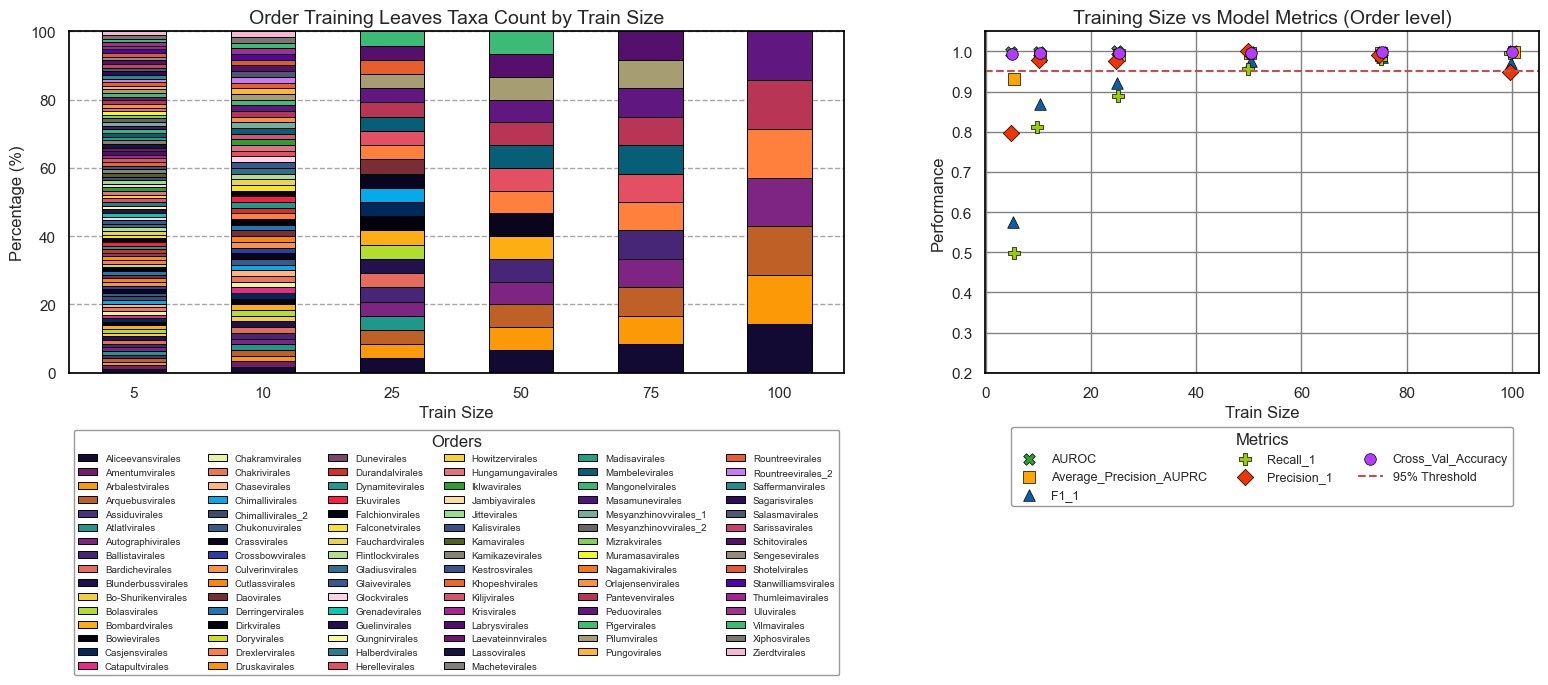

In [44]:
plot_training_metrics(order_results, combined_palette, rank="Order", output_file="../plots/order_training_metrics.png",
                      bottom_spacing=0.5, num_col_legend=6, bbox_to_anchor1_y=-0.9, bbox_to_anchor2_y=-0.41
                     )

# 1.2. Train downsampled family

In [56]:
filtered_df = filter_low_count_taxa(df, rank='Family', min_count=5)
X_train, X_test, y_train, y_test = create_train_test(filtered_df, training_matrix_T, rank='Family')

In [59]:
family_results, family_feature_importance = train_binary_classifiers(X_train, X_test, y_train, y_test, training_matrix_T, min_taxa_count=5, rank='Family')

Balancing all taxa to 5 instances each.
Balanced Train Shape: (650, 20289), Unique taxa: 130
Y Train Value Counts: Family
Ackermannviridae         5
Onoviridae               5
Mesyanzhinovviridae_2    5
Mesyanzhinovviridae_1    5
Matchlockviridae         5
                        ..
Dirkviridae              5
Derringerviridae         5
Demerecviridae           5
Daoviridae               5
Zobellviridae_1          5
Name: count, Length: 130, dtype: int64
Y Train Training Value Counts: count
5    130
Name: count, dtype: int64


Training Family classifiers..:   0%|                                                           | 0/130 [00:00<?, ?it/s]

Training Ackermannviridae vs. rest with size 5


Training Family classifiers..:   1%|▍                                                  | 1/130 [00:08<18:28,  8.59s/it]

Training Onoviridae vs. rest with size 5


Training Family classifiers..:   2%|▊                                                  | 2/130 [00:16<17:55,  8.40s/it]

Training Mesyanzhinovviridae_2 vs. rest with size 5


Training Family classifiers..:   2%|█▏                                                 | 3/130 [00:25<18:02,  8.53s/it]

Training Mesyanzhinovviridae_1 vs. rest with size 5


Training Family classifiers..:   3%|█▌                                                 | 4/130 [00:33<17:40,  8.42s/it]

Training Matchlockviridae vs. rest with size 5


Training Family classifiers..:   4%|█▉                                                 | 5/130 [00:43<18:11,  8.73s/it]

Training Masamuneviridae vs. rest with size 5


Training Family classifiers..:   5%|██▎                                                | 6/130 [00:51<17:29,  8.46s/it]

Training Mangonelviridae vs. rest with size 5


Training Family classifiers..:   5%|██▋                                                | 7/130 [00:59<17:03,  8.32s/it]

Training Mambeleviridae vs. rest with size 5


Training Family classifiers..:   6%|███▏                                               | 8/130 [01:07<16:47,  8.26s/it]

Training Makriggaviridae vs. rest with size 5


Training Family classifiers..:   7%|███▌                                               | 9/130 [01:15<16:34,  8.22s/it]

Training Macheteviridae vs. rest with size 5


Training Family classifiers..:   8%|███▊                                              | 10/130 [01:23<16:32,  8.27s/it]

Training Lassoviridae vs. rest with size 5


Training Family classifiers..:   8%|████▏                                             | 11/130 [01:31<16:24,  8.28s/it]

Training Laevateinnviridae vs. rest with size 5


Training Family classifiers..:   9%|████▌                                             | 12/130 [01:41<17:12,  8.75s/it]

Training Labrysviridae vs. rest with size 5


Training Family classifiers..:  10%|█████                                             | 13/130 [01:50<17:07,  8.79s/it]

Training Kyanoviridae vs. rest with size 5


Training Family classifiers..:  11%|█████▍                                            | 14/130 [01:58<16:16,  8.42s/it]

Training Kusanagiviridae vs. rest with size 5


Training Family classifiers..:  12%|█████▊                                            | 15/130 [02:07<16:20,  8.53s/it]

Training Kukriviridae vs. rest with size 5


Training Family classifiers..:  12%|██████▏                                           | 16/130 [02:14<15:45,  8.30s/it]

Training Krisviridae vs. rest with size 5


Training Family classifiers..:  13%|██████▌                                           | 17/130 [02:23<15:37,  8.29s/it]

Training Kpingaviridae vs. rest with size 5


Training Family classifiers..:  14%|██████▉                                           | 18/130 [02:31<15:19,  8.21s/it]

Training Kilijviridae vs. rest with size 5


Training Family classifiers..:  15%|███████▎                                          | 19/130 [02:38<14:42,  7.95s/it]

Training Khopeshviridae vs. rest with size 5


Training Family classifiers..:  15%|███████▋                                          | 20/130 [02:46<14:23,  7.85s/it]

Training Kestrosviridae vs. rest with size 5


Training Family classifiers..:  16%|████████                                          | 21/130 [02:54<14:35,  8.03s/it]

Training Katanaviridae vs. rest with size 5


Training Family classifiers..:  17%|████████▍                                         | 22/130 [03:02<14:33,  8.09s/it]

Training Karambitviridae vs. rest with size 5


Training Family classifiers..:  18%|████████▊                                         | 23/130 [03:11<14:37,  8.20s/it]

Training Kamikazeviridae vs. rest with size 5


Training Family classifiers..:  18%|█████████▏                                        | 24/130 [03:21<15:22,  8.71s/it]

Training Kamaviridae vs. rest with size 5


Training Family classifiers..:  19%|█████████▌                                        | 25/130 [03:30<15:20,  8.77s/it]

Training Kalisviridae vs. rest with size 5


Training Family classifiers..:  20%|██████████                                        | 26/130 [03:38<15:01,  8.67s/it]

Training Jitteviridae vs. rest with size 5


Training Family classifiers..:  21%|██████████▍                                       | 27/130 [03:48<15:21,  8.94s/it]

Training Javelinviridae vs. rest with size 5


Training Family classifiers..:  22%|██████████▊                                       | 28/130 [03:57<15:17,  9.00s/it]

Training Jambiyaviridae vs. rest with size 5


Training Family classifiers..:  22%|███████████▏                                      | 29/130 [04:05<14:36,  8.68s/it]

Training Intestiviridae vs. rest with size 5


Training Family classifiers..:  23%|███████████▌                                      | 30/130 [04:13<14:10,  8.51s/it]

Training Incendiarviridae vs. rest with size 5


Training Family classifiers..:  24%|███████████▉                                      | 31/130 [04:21<13:46,  8.35s/it]

Training Mizrakviridae vs. rest with size 5


Training Family classifiers..:  25%|████████████▎                                     | 32/130 [04:29<13:39,  8.36s/it]

Training Orlajensenviridae vs. rest with size 5


Training Family classifiers..:  25%|████████████▋                                     | 33/130 [04:39<14:19,  8.86s/it]

Training Aliceevansviridae vs. rest with size 5


Training Family classifiers..:  26%|█████████████                                     | 34/130 [04:47<13:55,  8.70s/it]

Training Pachyviridae_1 vs. rest with size 5


Training Family classifiers..:  27%|█████████████▍                                    | 35/130 [04:55<13:21,  8.44s/it]

Training Zierdtviridae_2 vs. rest with size 5


Training Family classifiers..:  28%|█████████████▊                                    | 36/130 [05:03<13:00,  8.31s/it]

Training Zierdtviridae_1 vs. rest with size 5


Training Family classifiers..:  28%|██████████████▏                                   | 37/130 [05:11<12:35,  8.12s/it]

Training Xiphosviridae vs. rest with size 5


Training Family classifiers..:  29%|██████████████▌                                   | 38/130 [05:19<12:30,  8.15s/it]

Training Vilmaviridae_2 vs. rest with size 5


Training Family classifiers..:  30%|███████████████                                   | 39/130 [05:27<12:06,  7.98s/it]

Training Vilmaviridae_1 vs. rest with size 5


Training Family classifiers..:  31%|███████████████▍                                  | 40/130 [05:34<11:46,  7.85s/it]

Training Uluviridae vs. rest with size 5


Training Family classifiers..:  32%|███████████████▊                                  | 41/130 [05:42<11:42,  7.90s/it]

Training Tepoztliviridae vs. rest with size 5


Training Family classifiers..:  32%|████████████████▏                                 | 42/130 [05:50<11:36,  7.92s/it]

Training Tekkoviridae vs. rest with size 5


Training Family classifiers..:  33%|████████████████▌                                 | 43/130 [05:58<11:25,  7.88s/it]

Training Suoliviridae vs. rest with size 5


Training Family classifiers..:  34%|████████████████▉                                 | 44/130 [06:06<11:31,  8.04s/it]

Training Straboviridae vs. rest with size 5


Training Family classifiers..:  35%|█████████████████▎                                | 45/130 [06:15<11:33,  8.15s/it]

Training Steigviridae vs. rest with size 5


Training Family classifiers..:  35%|█████████████████▋                                | 46/130 [06:24<11:46,  8.41s/it]

Training Stanwilliamsviridae vs. rest with size 5


Training Family classifiers..:  36%|██████████████████                                | 47/130 [06:32<11:38,  8.42s/it]

Training Shotelviridae vs. rest with size 5


Training Family classifiers..:  37%|██████████████████▍                               | 48/130 [06:40<11:16,  8.25s/it]

Training Sengeseviridae vs. rest with size 5


Training Family classifiers..:  38%|██████████████████▊                               | 49/130 [06:49<11:13,  8.31s/it]

Training Scutumviridae vs. rest with size 5


Training Family classifiers..:  38%|███████████████████▏                              | 50/130 [06:56<10:49,  8.12s/it]

Training Schitoviridae_3 vs. rest with size 5


Training Family classifiers..:  39%|███████████████████▌                              | 51/130 [07:04<10:19,  7.85s/it]

Training Schitoviridae_2 vs. rest with size 5


Training Family classifiers..:  40%|████████████████████                              | 52/130 [07:12<10:18,  7.93s/it]

Training Schitoviridae_1 vs. rest with size 5


Training Family classifiers..:  41%|████████████████████▍                             | 53/130 [07:20<10:16,  8.00s/it]

Training Sarissaviridae vs. rest with size 5


Training Family classifiers..:  42%|████████████████████▊                             | 54/130 [07:28<10:06,  7.98s/it]

Training Salasmaviridae vs. rest with size 5


Training Family classifiers..:  42%|█████████████████████▏                            | 55/130 [07:35<09:47,  7.84s/it]

Training Sagarisviridae vs. rest with size 5


Training Family classifiers..:  43%|█████████████████████▌                            | 56/130 [07:43<09:47,  7.93s/it]

Training Runguviridae vs. rest with size 5


Training Family classifiers..:  44%|█████████████████████▉                            | 57/130 [07:51<09:25,  7.75s/it]

Training Rountreeviridae_2 vs. rest with size 5


Training Family classifiers..:  45%|██████████████████████▎                           | 58/130 [07:59<09:26,  7.87s/it]

Training Rountreeviridae_1 vs. rest with size 5


Training Family classifiers..:  45%|██████████████████████▋                           | 59/130 [08:10<10:37,  8.98s/it]

Training Qiangviridae vs. rest with size 5


Training Family classifiers..:  46%|███████████████████████                           | 60/130 [08:19<10:29,  8.99s/it]

Training Pootjesviridae vs. rest with size 5


Training Family classifiers..:  47%|███████████████████████▍                          | 61/130 [08:28<10:16,  8.94s/it]

Training Pilumviridae vs. rest with size 5


Training Family classifiers..:  48%|███████████████████████▊                          | 62/130 [08:38<10:18,  9.10s/it]

Training Pigerviridae vs. rest with size 5


Training Family classifiers..:  48%|████████████████████████▏                         | 63/130 [08:48<10:25,  9.33s/it]

Training Peduoviridae vs. rest with size 5


Training Family classifiers..:  49%|████████████████████████▌                         | 64/130 [08:56<09:58,  9.07s/it]

Training Iklwaviridae vs. rest with size 5


Training Family classifiers..:  50%|█████████████████████████                         | 65/130 [09:04<09:25,  8.71s/it]

Training Hungamungaviridae vs. rest with size 5


Training Family classifiers..:  51%|█████████████████████████▍                        | 66/130 [09:13<09:25,  8.83s/it]

Training Howitzerviridae vs. rest with size 5


Training Family classifiers..:  52%|█████████████████████████▊                        | 67/130 [09:21<08:58,  8.55s/it]

Training Herelleviridae_3 vs. rest with size 5


Training Family classifiers..:  52%|██████████████████████████▏                       | 68/130 [09:29<08:35,  8.32s/it]

Training Claymoreviridae vs. rest with size 5


Training Family classifiers..:  53%|██████████████████████████▌                       | 69/130 [09:36<08:12,  8.08s/it]

Training Chukonuviridae vs. rest with size 5


Training Family classifiers..:  54%|██████████████████████████▉                       | 70/130 [09:43<07:45,  7.76s/it]

Training Chimalliviridae_2 vs. rest with size 5


Training Family classifiers..:  55%|███████████████████████████▎                      | 71/130 [09:50<07:20,  7.47s/it]

Training Chimalliviridae_1 vs. rest with size 5


Training Family classifiers..:  55%|███████████████████████████▋                      | 72/130 [09:57<07:05,  7.33s/it]

Training Chaseviridae vs. rest with size 5


Training Family classifiers..:  56%|████████████████████████████                      | 73/130 [10:04<06:56,  7.31s/it]

Training Chakriviridae vs. rest with size 5


Training Family classifiers..:  57%|████████████████████████████▍                     | 74/130 [10:12<06:49,  7.30s/it]

Training Chakramviridae vs. rest with size 5


Training Family classifiers..:  58%|████████████████████████████▊                     | 75/130 [10:19<06:48,  7.43s/it]

Training Catapultviridae vs. rest with size 5


Training Family classifiers..:  58%|█████████████████████████████▏                    | 76/130 [10:28<07:04,  7.86s/it]

Training Casjensviridae vs. rest with size 5


Training Family classifiers..:  59%|█████████████████████████████▌                    | 77/130 [10:37<07:13,  8.18s/it]

Training Cannonballviridae vs. rest with size 5


Training Family classifiers..:  60%|██████████████████████████████                    | 78/130 [10:46<07:17,  8.41s/it]

Training Bowieviridae vs. rest with size 5


Training Family classifiers..:  61%|██████████████████████████████▍                   | 79/130 [10:55<07:09,  8.41s/it]

Training Bombardviridae vs. rest with size 5


Training Family classifiers..:  62%|██████████████████████████████▊                   | 80/130 [11:04<07:09,  8.59s/it]

Training Bolasviridae vs. rest with size 5


Training Family classifiers..:  62%|███████████████████████████████▏                  | 81/130 [11:13<07:09,  8.77s/it]

Training Bo-Shurikenviridae vs. rest with size 5


Training Family classifiers..:  63%|███████████████████████████████▌                  | 82/130 [11:22<07:02,  8.80s/it]

Training Blunderbussviridae vs. rest with size 5


Training Family classifiers..:  64%|███████████████████████████████▉                  | 83/130 [11:31<07:00,  8.94s/it]

Training Bazookaviridae vs. rest with size 5


Training Family classifiers..:  65%|████████████████████████████████▎                 | 84/130 [11:39<06:46,  8.85s/it]

Training Bayonetteviridae vs. rest with size 5


Training Family classifiers..:  65%|████████████████████████████████▋                 | 85/130 [11:48<06:34,  8.77s/it]

Training Bardicheviridae vs. rest with size 5


Training Family classifiers..:  66%|█████████████████████████████████                 | 86/130 [11:56<06:21,  8.66s/it]

Training Ballistaviridae vs. rest with size 5


Training Family classifiers..:  67%|█████████████████████████████████▍                | 87/130 [12:05<06:13,  8.69s/it]

Training Autotranscriptaviridae vs. rest with size 5


Training Family classifiers..:  68%|█████████████████████████████████▊                | 88/130 [12:14<06:11,  8.85s/it]

Training Autosignataviridae vs. rest with size 5


Training Family classifiers..:  68%|██████████████████████████████████▏               | 89/130 [12:24<06:10,  9.03s/it]

Training Autoscriptoviridae vs. rest with size 5


Training Family classifiers..:  69%|██████████████████████████████████▌               | 90/130 [12:33<05:55,  8.90s/it]

Training Autographiviridae vs. rest with size 5


Training Family classifiers..:  70%|███████████████████████████████████               | 91/130 [12:42<05:48,  8.94s/it]

Training Atlatlviridae vs. rest with size 5


Training Family classifiers..:  71%|███████████████████████████████████▍              | 92/130 [12:51<05:43,  9.03s/it]

Training Assegaiviridae vs. rest with size 5


Training Family classifiers..:  72%|███████████████████████████████████▊              | 93/130 [12:59<05:25,  8.81s/it]

Training Arquebusviridae vs. rest with size 5


Training Family classifiers..:  72%|████████████████████████████████████▏             | 94/130 [13:08<05:18,  8.84s/it]

Training Arenbergviridae vs. rest with size 5


Training Family classifiers..:  73%|████████████████████████████████████▌             | 95/130 [13:16<05:03,  8.67s/it]

Training Arbalestviridae vs. rest with size 5


Training Family classifiers..:  74%|████████████████████████████████████▉             | 96/130 [13:24<04:46,  8.42s/it]

Training Amentumviridae vs. rest with size 5


Training Family classifiers..:  75%|█████████████████████████████████████▎            | 97/130 [13:32<04:33,  8.28s/it]

Training Crossbowviridae vs. rest with size 5


Training Family classifiers..:  75%|█████████████████████████████████████▋            | 98/130 [13:41<04:29,  8.43s/it]

Training Culverinviridae vs. rest with size 5


Training Family classifiers..:  76%|██████████████████████████████████████            | 99/130 [13:50<04:26,  8.60s/it]

Training Cutlassviridae vs. rest with size 5


Training Family classifiers..:  77%|█████████████████████████████████████▋           | 100/130 [13:58<04:17,  8.57s/it]

Training Fauchardviridae vs. rest with size 5


Training Family classifiers..:  78%|██████████████████████████████████████           | 101/130 [14:08<04:14,  8.79s/it]

Training Herelleviridae_2 vs. rest with size 5


Training Family classifiers..:  78%|██████████████████████████████████████▍          | 102/130 [14:16<04:05,  8.76s/it]

Training Herelleviridae_1 vs. rest with size 5


Training Family classifiers..:  79%|██████████████████████████████████████▊          | 103/130 [14:25<03:53,  8.67s/it]

Training Halberdviridae vs. rest with size 5


Training Family classifiers..:  80%|███████████████████████████████████████▏         | 104/130 [14:35<03:54,  9.02s/it]

Training Hafunaviridae_1 vs. rest with size 5


Training Family classifiers..:  81%|███████████████████████████████████████▌         | 105/130 [14:43<03:42,  8.91s/it]

Training Gungnirviridae vs. rest with size 5


Training Family classifiers..:  82%|███████████████████████████████████████▉         | 106/130 [14:52<03:30,  8.79s/it]

Training Guelinviridae vs. rest with size 5


Training Family classifiers..:  82%|████████████████████████████████████████▎        | 107/130 [15:02<03:33,  9.30s/it]

Training Grimontviridae vs. rest with size 5


Training Family classifiers..:  83%|████████████████████████████████████████▋        | 108/130 [15:11<03:23,  9.23s/it]

Training Grenadeviridae vs. rest with size 5


Training Family classifiers..:  84%|█████████████████████████████████████████        | 109/130 [15:21<03:15,  9.33s/it]

Training Gramrviridae vs. rest with size 5


Training Family classifiers..:  85%|█████████████████████████████████████████▍       | 110/130 [15:30<03:07,  9.38s/it]

Training Glockviridae vs. rest with size 5


Training Family classifiers..:  85%|█████████████████████████████████████████▊       | 111/130 [15:40<02:58,  9.38s/it]

Training Glaiveviridae vs. rest with size 5


Training Family classifiers..:  86%|██████████████████████████████████████████▏      | 112/130 [15:48<02:42,  9.05s/it]

Training Gladiusviridae vs. rest with size 5


Training Family classifiers..:  87%|██████████████████████████████████████████▌      | 113/130 [15:57<02:35,  9.14s/it]

Training Flintlockviridae vs. rest with size 5


Training Family classifiers..:  88%|██████████████████████████████████████████▉      | 114/130 [16:07<02:27,  9.22s/it]

Training Falconetviridae vs. rest with size 5


Training Family classifiers..:  88%|███████████████████████████████████████████▎     | 115/130 [16:16<02:19,  9.33s/it]

Training Daneaxeviridae vs. rest with size 5


Training Family classifiers..:  89%|███████████████████████████████████████████▋     | 116/130 [16:25<02:05,  9.00s/it]

Training Falchionviridae vs. rest with size 5


Training Family classifiers..:  90%|████████████████████████████████████████████     | 117/130 [16:34<01:59,  9.20s/it]

Training Excaliburviridae vs. rest with size 5


Training Family classifiers..:  91%|████████████████████████████████████████████▍    | 118/130 [16:44<01:51,  9.32s/it]

Training Ekuviridae vs. rest with size 5


Training Family classifiers..:  92%|████████████████████████████████████████████▊    | 119/130 [16:53<01:41,  9.23s/it]

Training Dynamiteviridae vs. rest with size 5


Training Family classifiers..:  92%|█████████████████████████████████████████████▏   | 120/130 [17:02<01:31,  9.18s/it]

Training Durandalviridae vs. rest with size 5


Training Family classifiers..:  93%|█████████████████████████████████████████████▌   | 121/130 [17:11<01:22,  9.13s/it]

Training Duneviridae vs. rest with size 5


Training Family classifiers..:  94%|█████████████████████████████████████████████▉   | 122/130 [17:21<01:14,  9.26s/it]

Training Druskaviridae vs. rest with size 5


Training Family classifiers..:  95%|██████████████████████████████████████████████▎  | 123/130 [17:30<01:05,  9.40s/it]

Training Drexlerviridae vs. rest with size 5


Training Family classifiers..:  95%|██████████████████████████████████████████████▋  | 124/130 [17:39<00:55,  9.33s/it]

Training Doryviridae vs. rest with size 5


Training Family classifiers..:  96%|███████████████████████████████████████████████  | 125/130 [17:49<00:46,  9.28s/it]

Training Dirkviridae vs. rest with size 5


Training Family classifiers..:  97%|███████████████████████████████████████████████▍ | 126/130 [17:58<00:36,  9.23s/it]

Training Derringerviridae vs. rest with size 5


Training Family classifiers..:  98%|███████████████████████████████████████████████▊ | 127/130 [18:07<00:27,  9.32s/it]

Training Demerecviridae vs. rest with size 5


Training Family classifiers..:  98%|████████████████████████████████████████████████▏| 128/130 [18:16<00:18,  9.06s/it]

Training Daoviridae vs. rest with size 5


Training Family classifiers..:  99%|████████████████████████████████████████████████▌| 129/130 [18:25<00:09,  9.12s/it]

Training Zobellviridae_1 vs. rest with size 5


Training Family classifiers..: 100%|█████████████████████████████████████████████████| 130/130 [18:34<00:00,  8.58s/it]


Balancing all taxa to 10 instances each.
Balanced Train Shape: (830, 20289), Unique taxa: 83
Y Train Value Counts: Family
Ackermannviridae         10
Pachyviridae_1           10
Mesyanzhinovviridae_1    10
Mambeleviridae           10
Makriggaviridae          10
                         ..
Chimalliviridae_1        10
Chaseviridae             10
Chakriviridae            10
Chakramviridae           10
Zobellviridae_1          10
Name: count, Length: 83, dtype: int64
Y Train Training Value Counts: count
10    83
Name: count, dtype: int64


Training Family classifiers..:   0%|                                                            | 0/83 [00:00<?, ?it/s]

Training Ackermannviridae vs. rest with size 10


Training Family classifiers..:   1%|▋                                                   | 1/83 [00:09<13:30,  9.89s/it]

Training Pachyviridae_1 vs. rest with size 10


Training Family classifiers..:   2%|█▎                                                  | 2/83 [00:20<14:14, 10.55s/it]

Training Mesyanzhinovviridae_1 vs. rest with size 10


Training Family classifiers..:   4%|█▉                                                  | 3/83 [00:31<14:11, 10.64s/it]

Training Mambeleviridae vs. rest with size 10


Training Family classifiers..:   5%|██▌                                                 | 4/83 [00:42<14:04, 10.70s/it]

Training Makriggaviridae vs. rest with size 10


Training Family classifiers..:   6%|███▏                                                | 5/83 [00:53<14:10, 10.90s/it]

Training Kyanoviridae vs. rest with size 10


Training Family classifiers..:   7%|███▊                                                | 6/83 [01:03<13:38, 10.62s/it]

Training Kpingaviridae vs. rest with size 10


Training Family classifiers..:   8%|████▍                                               | 7/83 [01:14<13:23, 10.58s/it]

Training Kilijviridae vs. rest with size 10


Training Family classifiers..:  10%|█████                                               | 8/83 [01:24<12:54, 10.33s/it]

Training Intestiviridae vs. rest with size 10


Training Family classifiers..:  11%|█████▋                                              | 9/83 [01:35<13:21, 10.83s/it]

Training Iklwaviridae vs. rest with size 10


Training Family classifiers..:  12%|██████▏                                            | 10/83 [01:47<13:21, 10.98s/it]

Training Hungamungaviridae vs. rest with size 10


Training Family classifiers..:  13%|██████▊                                            | 11/83 [01:59<13:27, 11.21s/it]

Training Herelleviridae_2 vs. rest with size 10


Training Family classifiers..:  14%|███████▎                                           | 12/83 [02:09<12:54, 10.91s/it]

Training Herelleviridae_1 vs. rest with size 10


Training Family classifiers..:  16%|███████▉                                           | 13/83 [02:19<12:29, 10.70s/it]

Training Grimontviridae vs. rest with size 10


Training Family classifiers..:  17%|████████▌                                          | 14/83 [02:29<12:09, 10.57s/it]

Training Glockviridae vs. rest with size 10


Training Family classifiers..:  18%|█████████▏                                         | 15/83 [02:40<11:59, 10.58s/it]

Training Glaiveviridae vs. rest with size 10


Training Family classifiers..:  19%|█████████▊                                         | 16/83 [02:50<11:48, 10.58s/it]

Training Gladiusviridae vs. rest with size 10


Training Family classifiers..:  20%|██████████▍                                        | 17/83 [03:02<11:51, 10.78s/it]

Training Flintlockviridae vs. rest with size 10


Training Family classifiers..:  22%|███████████                                        | 18/83 [03:13<11:58, 11.05s/it]

Training Fauchardviridae vs. rest with size 10


Training Family classifiers..:  23%|███████████▋                                       | 19/83 [03:25<11:50, 11.11s/it]

Training Orlajensenviridae vs. rest with size 10


Training Family classifiers..:  24%|████████████▎                                      | 20/83 [03:38<12:19, 11.73s/it]

Training Peduoviridae vs. rest with size 10


Training Family classifiers..:  25%|████████████▉                                      | 21/83 [03:49<11:56, 11.56s/it]

Training Falchionviridae vs. rest with size 10


Training Family classifiers..:  27%|█████████████▌                                     | 22/83 [04:01<11:45, 11.56s/it]

Training Pigerviridae vs. rest with size 10


Training Family classifiers..:  28%|██████████████▏                                    | 23/83 [04:14<12:01, 12.03s/it]

Training Zierdtviridae_2 vs. rest with size 10


Training Family classifiers..:  29%|██████████████▋                                    | 24/83 [04:24<11:24, 11.59s/it]

Training Xiphosviridae vs. rest with size 10


Training Family classifiers..:  30%|███████████████▎                                   | 25/83 [04:35<10:59, 11.36s/it]

Training Vilmaviridae_1 vs. rest with size 10


Training Family classifiers..:  31%|███████████████▉                                   | 26/83 [04:45<10:26, 11.00s/it]

Training Uluviridae vs. rest with size 10


Training Family classifiers..:  33%|████████████████▌                                  | 27/83 [04:55<09:56, 10.65s/it]

Training Suoliviridae vs. rest with size 10


Training Family classifiers..:  34%|█████████████████▏                                 | 28/83 [05:05<09:38, 10.52s/it]

Training Straboviridae vs. rest with size 10


Training Family classifiers..:  35%|█████████████████▊                                 | 29/83 [05:14<08:56,  9.93s/it]

Training Steigviridae vs. rest with size 10


Training Family classifiers..:  36%|██████████████████▍                                | 30/83 [05:24<08:46,  9.94s/it]

Training Stanwilliamsviridae vs. rest with size 10


Training Family classifiers..:  37%|███████████████████                                | 31/83 [05:33<08:32,  9.85s/it]

Training Shotelviridae vs. rest with size 10


Training Family classifiers..:  39%|███████████████████▋                               | 32/83 [05:43<08:21,  9.83s/it]

Training Schitoviridae_3 vs. rest with size 10


Training Family classifiers..:  40%|████████████████████▎                              | 33/83 [05:53<08:09,  9.80s/it]

Training Schitoviridae_1 vs. rest with size 10


Training Family classifiers..:  41%|████████████████████▉                              | 34/83 [06:02<07:56,  9.72s/it]

Training Salasmaviridae vs. rest with size 10


Training Family classifiers..:  42%|█████████████████████▌                             | 35/83 [06:13<07:53,  9.87s/it]

Training Runguviridae vs. rest with size 10


Training Family classifiers..:  43%|██████████████████████                             | 36/83 [06:23<07:50, 10.02s/it]

Training Rountreeviridae_2 vs. rest with size 10


Training Family classifiers..:  45%|██████████████████████▋                            | 37/83 [06:33<07:41, 10.03s/it]

Training Rountreeviridae_1 vs. rest with size 10


Training Family classifiers..:  46%|███████████████████████▎                           | 38/83 [06:46<08:09, 10.89s/it]

Training Qiangviridae vs. rest with size 10


Training Family classifiers..:  47%|███████████████████████▉                           | 39/83 [06:56<07:52, 10.75s/it]

Training Pilumviridae vs. rest with size 10


Training Family classifiers..:  48%|████████████████████████▌                          | 40/83 [07:08<07:48, 10.90s/it]

Training Falconetviridae vs. rest with size 10


Training Family classifiers..:  49%|█████████████████████████▏                         | 41/83 [07:19<07:38, 10.92s/it]

Training Excaliburviridae vs. rest with size 10


Training Family classifiers..:  51%|█████████████████████████▊                         | 42/83 [07:29<07:26, 10.89s/it]

Training Aliceevansviridae vs. rest with size 10


Training Family classifiers..:  52%|██████████████████████████▍                        | 43/83 [07:41<07:19, 10.99s/it]

Training Cannonballviridae vs. rest with size 10


Training Family classifiers..:  53%|███████████████████████████                        | 44/83 [07:52<07:11, 11.06s/it]

Training Bombardviridae vs. rest with size 10


Training Family classifiers..:  54%|███████████████████████████▋                       | 45/83 [08:02<06:51, 10.84s/it]

Training Bolasviridae vs. rest with size 10


Training Family classifiers..:  55%|████████████████████████████▎                      | 46/83 [08:13<06:45, 10.95s/it]

Training Bo-Shurikenviridae vs. rest with size 10


Training Family classifiers..:  57%|████████████████████████████▉                      | 47/83 [08:24<06:33, 10.92s/it]

Training Blunderbussviridae vs. rest with size 10


Training Family classifiers..:  58%|█████████████████████████████▍                     | 48/83 [08:35<06:22, 10.93s/it]

Training Bazookaviridae vs. rest with size 10


Training Family classifiers..:  59%|██████████████████████████████                     | 49/83 [08:45<06:04, 10.72s/it]

Training Bayonetteviridae vs. rest with size 10


Training Family classifiers..:  60%|██████████████████████████████▋                    | 50/83 [08:56<05:54, 10.74s/it]

Training Bardicheviridae vs. rest with size 10


Training Family classifiers..:  61%|███████████████████████████████▎                   | 51/83 [09:06<05:36, 10.51s/it]

Training Ballistaviridae vs. rest with size 10


Training Family classifiers..:  63%|███████████████████████████████▉                   | 52/83 [09:17<05:24, 10.47s/it]

Training Autotranscriptaviridae vs. rest with size 10


Training Family classifiers..:  64%|████████████████████████████████▌                  | 53/83 [09:28<05:21, 10.71s/it]

Training Autosignataviridae vs. rest with size 10


Training Family classifiers..:  65%|█████████████████████████████████▏                 | 54/83 [09:39<05:17, 10.94s/it]

Training Autoscriptoviridae vs. rest with size 10


Training Family classifiers..:  66%|█████████████████████████████████▊                 | 55/83 [09:52<05:17, 11.34s/it]

Training Autographiviridae vs. rest with size 10


Training Family classifiers..:  67%|██████████████████████████████████▍                | 56/83 [10:04<05:12, 11.57s/it]

Training Atlatlviridae vs. rest with size 10


Training Family classifiers..:  69%|███████████████████████████████████                | 57/83 [10:14<04:53, 11.28s/it]

Training Assegaiviridae vs. rest with size 10


Training Family classifiers..:  70%|███████████████████████████████████▋               | 58/83 [10:24<04:31, 10.88s/it]

Training Arquebusviridae vs. rest with size 10


Training Family classifiers..:  71%|████████████████████████████████████▎              | 59/83 [10:35<04:17, 10.71s/it]

Training Arbalestviridae vs. rest with size 10


Training Family classifiers..:  72%|████████████████████████████████████▊              | 60/83 [10:44<03:58, 10.36s/it]

Training Amentumviridae vs. rest with size 10


Training Family classifiers..:  73%|█████████████████████████████████████▍             | 61/83 [10:53<03:38,  9.95s/it]

Training Bowieviridae vs. rest with size 10


Training Family classifiers..:  75%|██████████████████████████████████████             | 62/83 [11:02<03:23,  9.69s/it]

Training Casjensviridae vs. rest with size 10


Training Family classifiers..:  76%|██████████████████████████████████████▋            | 63/83 [11:12<03:15,  9.79s/it]

Training Ekuviridae vs. rest with size 10


Training Family classifiers..:  77%|███████████████████████████████████████▎           | 64/83 [11:21<03:02,  9.61s/it]

Training Catapultviridae vs. rest with size 10


Training Family classifiers..:  78%|███████████████████████████████████████▉           | 65/83 [11:31<02:52,  9.58s/it]

Training Dynamiteviridae vs. rest with size 10


Training Family classifiers..:  80%|████████████████████████████████████████▌          | 66/83 [11:41<02:43,  9.59s/it]

Training Durandalviridae vs. rest with size 10


Training Family classifiers..:  81%|█████████████████████████████████████████▏         | 67/83 [11:51<02:35,  9.74s/it]

Training Drexlerviridae vs. rest with size 10


Training Family classifiers..:  82%|█████████████████████████████████████████▊         | 68/83 [12:00<02:26,  9.75s/it]

Training Dirkviridae vs. rest with size 10


Training Family classifiers..:  83%|██████████████████████████████████████████▍        | 69/83 [12:10<02:15,  9.68s/it]

Training Derringerviridae vs. rest with size 10


Training Family classifiers..:  84%|███████████████████████████████████████████        | 70/83 [12:20<02:05,  9.66s/it]

Training Demerecviridae vs. rest with size 10


Training Family classifiers..:  86%|███████████████████████████████████████████▋       | 71/83 [12:28<01:51,  9.28s/it]

Training Daoviridae vs. rest with size 10


Training Family classifiers..:  87%|████████████████████████████████████████████▏      | 72/83 [12:38<01:43,  9.41s/it]

Training Daneaxeviridae vs. rest with size 10


Training Family classifiers..:  88%|████████████████████████████████████████████▊      | 73/83 [12:46<01:30,  9.02s/it]

Training Cutlassviridae vs. rest with size 10


Training Family classifiers..:  89%|█████████████████████████████████████████████▍     | 74/83 [12:54<01:19,  8.83s/it]

Training Culverinviridae vs. rest with size 10


Training Family classifiers..:  90%|██████████████████████████████████████████████     | 75/83 [13:04<01:13,  9.17s/it]

Training Crossbowviridae vs. rest with size 10


Training Family classifiers..:  92%|██████████████████████████████████████████████▋    | 76/83 [13:13<01:04,  9.16s/it]

Training Claymoreviridae vs. rest with size 10


Training Family classifiers..:  93%|███████████████████████████████████████████████▎   | 77/83 [13:22<00:54,  9.10s/it]

Training Chukonuviridae vs. rest with size 10


Training Family classifiers..:  94%|███████████████████████████████████████████████▉   | 78/83 [13:31<00:44,  8.97s/it]

Training Chimalliviridae_1 vs. rest with size 10


Training Family classifiers..:  95%|████████████████████████████████████████████████▌  | 79/83 [13:40<00:35,  8.92s/it]

Training Chaseviridae vs. rest with size 10


Training Family classifiers..:  96%|█████████████████████████████████████████████████▏ | 80/83 [13:49<00:27,  9.05s/it]

Training Chakriviridae vs. rest with size 10


Training Family classifiers..:  98%|█████████████████████████████████████████████████▊ | 81/83 [13:59<00:18,  9.27s/it]

Training Chakramviridae vs. rest with size 10


Training Family classifiers..:  99%|██████████████████████████████████████████████████▍| 82/83 [14:09<00:09,  9.44s/it]

Training Zobellviridae_1 vs. rest with size 10


Training Family classifiers..: 100%|███████████████████████████████████████████████████| 83/83 [14:18<00:00, 10.35s/it]


Balancing all taxa to 25 instances each.
Balanced Train Shape: (725, 20289), Unique taxa: 29
Y Train Value Counts: Family
Ackermannviridae          25
Chimalliviridae_1         25
Straboviridae             25
Schitoviridae_1           25
Runguviridae              25
Rountreeviridae_1         25
Pilumviridae              25
Peduoviridae              25
Mambeleviridae            25
Kyanoviridae              25
Herelleviridae_1          25
Grimontviridae            25
Drexlerviridae            25
Demerecviridae            25
Casjensviridae            25
Aliceevansviridae         25
Bolasviridae              25
Blunderbussviridae        25
Bazookaviridae            25
Bayonetteviridae          25
Bardicheviridae           25
Ballistaviridae           25
Autotranscriptaviridae    25
Autosignataviridae        25
Autoscriptoviridae        25
Atlatlviridae             25
Arquebusviridae           25
Arbalestviridae           25
Suoliviridae              25
Name: count, dtype: int64
Y Train Tra

Training Family classifiers..:   0%|                                                            | 0/29 [00:00<?, ?it/s]

Training Ackermannviridae vs. rest with size 25


Training Family classifiers..:   3%|█▊                                                  | 1/29 [00:08<03:49,  8.20s/it]

Training Chimalliviridae_1 vs. rest with size 25


Training Family classifiers..:   7%|███▌                                                | 2/29 [00:17<03:57,  8.80s/it]

Training Straboviridae vs. rest with size 25


Training Family classifiers..:  10%|█████▍                                              | 3/29 [00:25<03:41,  8.53s/it]

Training Schitoviridae_1 vs. rest with size 25


Training Family classifiers..:  14%|███████▏                                            | 4/29 [00:35<03:50,  9.23s/it]

Training Runguviridae vs. rest with size 25


Training Family classifiers..:  17%|████████▉                                           | 5/29 [00:47<04:01, 10.06s/it]

Training Rountreeviridae_1 vs. rest with size 25


Training Family classifiers..:  21%|██████████▊                                         | 6/29 [01:00<04:11, 10.95s/it]

Training Pilumviridae vs. rest with size 25


Training Family classifiers..:  24%|████████████▌                                       | 7/29 [01:09<03:51, 10.51s/it]

Training Peduoviridae vs. rest with size 25


Training Family classifiers..:  28%|██████████████▎                                     | 8/29 [01:19<03:34, 10.22s/it]

Training Mambeleviridae vs. rest with size 25


Training Family classifiers..:  31%|████████████████▏                                   | 9/29 [01:28<03:18,  9.92s/it]

Training Kyanoviridae vs. rest with size 25


Training Family classifiers..:  34%|█████████████████▌                                 | 10/29 [01:37<03:04,  9.72s/it]

Training Herelleviridae_1 vs. rest with size 25


Training Family classifiers..:  38%|███████████████████▎                               | 11/29 [01:46<02:50,  9.46s/it]

Training Grimontviridae vs. rest with size 25


Training Family classifiers..:  41%|█████████████████████                              | 12/29 [01:54<02:33,  9.02s/it]

Training Drexlerviridae vs. rest with size 25


Training Family classifiers..:  45%|██████████████████████▊                            | 13/29 [02:03<02:23,  8.97s/it]

Training Demerecviridae vs. rest with size 25


Training Family classifiers..:  48%|████████████████████████▌                          | 14/29 [02:11<02:11,  8.74s/it]

Training Casjensviridae vs. rest with size 25


Training Family classifiers..:  52%|██████████████████████████▍                        | 15/29 [02:22<02:10,  9.30s/it]

Training Aliceevansviridae vs. rest with size 25


Training Family classifiers..:  55%|████████████████████████████▏                      | 16/29 [02:33<02:06,  9.73s/it]

Training Bolasviridae vs. rest with size 25


Training Family classifiers..:  59%|█████████████████████████████▉                     | 17/29 [02:43<02:00, 10.01s/it]

Training Blunderbussviridae vs. rest with size 25


Training Family classifiers..:  62%|███████████████████████████████▋                   | 18/29 [02:53<01:49,  9.93s/it]

Training Bazookaviridae vs. rest with size 25


Training Family classifiers..:  66%|█████████████████████████████████▍                 | 19/29 [03:03<01:40, 10.04s/it]

Training Bayonetteviridae vs. rest with size 25


Training Family classifiers..:  69%|███████████████████████████████████▏               | 20/29 [03:13<01:30, 10.06s/it]

Training Bardicheviridae vs. rest with size 25


Training Family classifiers..:  72%|████████████████████████████████████▉              | 21/29 [03:25<01:23, 10.49s/it]

Training Ballistaviridae vs. rest with size 25


Training Family classifiers..:  76%|██████████████████████████████████████▋            | 22/29 [03:37<01:16, 10.99s/it]

Training Autotranscriptaviridae vs. rest with size 25


Training Family classifiers..:  79%|████████████████████████████████████████▍          | 23/29 [03:51<01:10, 11.77s/it]

Training Autosignataviridae vs. rest with size 25


Training Family classifiers..:  83%|██████████████████████████████████████████▏        | 24/29 [04:04<01:00, 12.11s/it]

Training Autoscriptoviridae vs. rest with size 25


Training Family classifiers..:  86%|███████████████████████████████████████████▉       | 25/29 [04:15<00:47, 11.80s/it]

Training Atlatlviridae vs. rest with size 25


Training Family classifiers..:  90%|█████████████████████████████████████████████▋     | 26/29 [04:24<00:33, 11.05s/it]

Training Arquebusviridae vs. rest with size 25


Training Family classifiers..:  93%|███████████████████████████████████████████████▍   | 27/29 [04:34<00:21, 10.86s/it]

Training Arbalestviridae vs. rest with size 25


Training Family classifiers..:  97%|█████████████████████████████████████████████████▏ | 28/29 [04:43<00:10, 10.28s/it]

Training Suoliviridae vs. rest with size 25


Training Family classifiers..: 100%|███████████████████████████████████████████████████| 29/29 [04:53<00:00, 10.12s/it]


Balancing all taxa to 50 instances each.
Balanced Train Shape: (800, 20289), Unique taxa: 16
Y Train Value Counts: Family
Ackermannviridae          50
Aliceevansviridae         50
Arbalestviridae           50
Arquebusviridae           50
Autoscriptoviridae        50
Autotranscriptaviridae    50
Demerecviridae            50
Drexlerviridae            50
Herelleviridae_1          50
Kyanoviridae              50
Mambeleviridae            50
Peduoviridae              50
Pilumviridae              50
Runguviridae              50
Schitoviridae_1           50
Straboviridae             50
Name: count, dtype: int64
Y Train Training Value Counts: count
50    16
Name: count, dtype: int64


Training Family classifiers..:   0%|                                                            | 0/16 [00:00<?, ?it/s]

Training Ackermannviridae vs. rest with size 50


Training Family classifiers..:   6%|███▎                                                | 1/16 [00:09<02:23,  9.59s/it]

Training Aliceevansviridae vs. rest with size 50


Training Family classifiers..:  12%|██████▌                                             | 2/16 [00:20<02:22, 10.20s/it]

Training Arbalestviridae vs. rest with size 50


Training Family classifiers..:  19%|█████████▊                                          | 3/16 [00:29<02:07,  9.83s/it]

Training Arquebusviridae vs. rest with size 50


Training Family classifiers..:  25%|█████████████                                       | 4/16 [00:39<01:59,  9.96s/it]

Training Autoscriptoviridae vs. rest with size 50


Training Family classifiers..:  31%|████████████████▎                                   | 5/16 [00:51<01:56, 10.60s/it]

Training Autotranscriptaviridae vs. rest with size 50


Training Family classifiers..:  38%|███████████████████▌                                | 6/16 [01:02<01:46, 10.61s/it]

Training Demerecviridae vs. rest with size 50


Training Family classifiers..:  44%|██████████████████████▊                             | 7/16 [01:11<01:32, 10.32s/it]

Training Drexlerviridae vs. rest with size 50


Training Family classifiers..:  50%|██████████████████████████                          | 8/16 [01:22<01:23, 10.39s/it]

Training Herelleviridae_1 vs. rest with size 50


Training Family classifiers..:  56%|█████████████████████████████▎                      | 9/16 [01:32<01:11, 10.17s/it]

Training Kyanoviridae vs. rest with size 50


Training Family classifiers..:  62%|███████████████████████████████▉                   | 10/16 [01:41<00:59,  9.89s/it]

Training Mambeleviridae vs. rest with size 50


Training Family classifiers..:  69%|███████████████████████████████████                | 11/16 [01:51<00:50, 10.07s/it]

Training Peduoviridae vs. rest with size 50


Training Family classifiers..:  75%|██████████████████████████████████████▎            | 12/16 [02:02<00:41, 10.28s/it]

Training Pilumviridae vs. rest with size 50


Training Family classifiers..:  81%|█████████████████████████████████████████▍         | 13/16 [02:12<00:30, 10.18s/it]

Training Runguviridae vs. rest with size 50


Training Family classifiers..:  88%|████████████████████████████████████████████▋      | 14/16 [02:24<00:21, 10.61s/it]

Training Schitoviridae_1 vs. rest with size 50


Training Family classifiers..:  94%|███████████████████████████████████████████████▊   | 15/16 [02:34<00:10, 10.64s/it]

Training Straboviridae vs. rest with size 50


Training Family classifiers..: 100%|███████████████████████████████████████████████████| 16/16 [02:44<00:00, 10.28s/it]


Balancing all taxa to 75 instances each.
Balanced Train Shape: (825, 20289), Unique taxa: 11
Y Train Value Counts: Family
Aliceevansviridae         75
Arbalestviridae           75
Arquebusviridae           75
Autoscriptoviridae        75
Autotranscriptaviridae    75
Demerecviridae            75
Drexlerviridae            75
Mambeleviridae            75
Peduoviridae              75
Runguviridae              75
Straboviridae             75
Name: count, dtype: int64
Y Train Training Value Counts: count
75    11
Name: count, dtype: int64


Training Family classifiers..:   0%|                                                            | 0/11 [00:00<?, ?it/s]

Training Aliceevansviridae vs. rest with size 75


Training Family classifiers..:   9%|████▋                                               | 1/11 [00:10<01:46, 10.65s/it]

Training Arbalestviridae vs. rest with size 75


Training Family classifiers..:  18%|█████████▍                                          | 2/11 [00:20<01:31, 10.20s/it]

Training Arquebusviridae vs. rest with size 75


Training Family classifiers..:  27%|██████████████▏                                     | 3/11 [00:30<01:21, 10.17s/it]

Training Autoscriptoviridae vs. rest with size 75


Training Family classifiers..:  36%|██████████████████▉                                 | 4/11 [00:43<01:17, 11.10s/it]

Training Autotranscriptaviridae vs. rest with size 75


Training Family classifiers..:  45%|███████████████████████▋                            | 5/11 [00:55<01:09, 11.62s/it]

Training Demerecviridae vs. rest with size 75


Training Family classifiers..:  55%|████████████████████████████▎                       | 6/11 [01:05<00:54, 10.92s/it]

Training Drexlerviridae vs. rest with size 75


Training Family classifiers..:  64%|█████████████████████████████████                   | 7/11 [01:15<00:42, 10.74s/it]

Training Mambeleviridae vs. rest with size 75


Training Family classifiers..:  73%|█████████████████████████████████████▊              | 8/11 [01:25<00:31, 10.55s/it]

Training Peduoviridae vs. rest with size 75


Training Family classifiers..:  82%|██████████████████████████████████████████▌         | 9/11 [01:36<00:21, 10.66s/it]

Training Runguviridae vs. rest with size 75


Training Family classifiers..:  91%|██████████████████████████████████████████████▎    | 10/11 [01:48<00:10, 10.97s/it]

Training Straboviridae vs. rest with size 75


Training Family classifiers..: 100%|███████████████████████████████████████████████████| 11/11 [01:58<00:00, 10.75s/it]


Balancing all taxa to 100 instances each.
Balanced Train Shape: (400, 20289), Unique taxa: 4
Y Train Value Counts: Family
Aliceevansviridae         100
Autoscriptoviridae        100
Autotranscriptaviridae    100
Straboviridae             100
Name: count, dtype: int64
Y Train Training Value Counts: count
100    4
Name: count, dtype: int64


Training Family classifiers..:   0%|                                                             | 0/4 [00:00<?, ?it/s]

Training Aliceevansviridae vs. rest with size 100


Training Family classifiers..:  25%|█████████████▎                                       | 1/4 [00:07<00:21,  7.21s/it]

Training Autoscriptoviridae vs. rest with size 100


Training Family classifiers..:  50%|██████████████████████████▌                          | 2/4 [00:15<00:16,  8.03s/it]

Training Autotranscriptaviridae vs. rest with size 100


Training Family classifiers..:  75%|███████████████████████████████████████▊             | 3/4 [00:24<00:08,  8.16s/it]

Training Straboviridae vs. rest with size 100


Training Family classifiers..: 100%|█████████████████████████████████████████████████████| 4/4 [00:30<00:00,  7.62s/it]


Models saved and results stored in classification_models_Family_train_sizes.csv


In [45]:
family_results = pd.read_csv('../data/classifier_performance/classification_models_Family_train_sizes.csv')
family_feature_importance = pd.read_csv('../data/classifier_performance/feature_importances_Family_train_sizes.csv')

In [61]:
family_results.Training_Leaves_Count.unique()

array([  5,  10,  25,  50,  75, 100], dtype=int64)

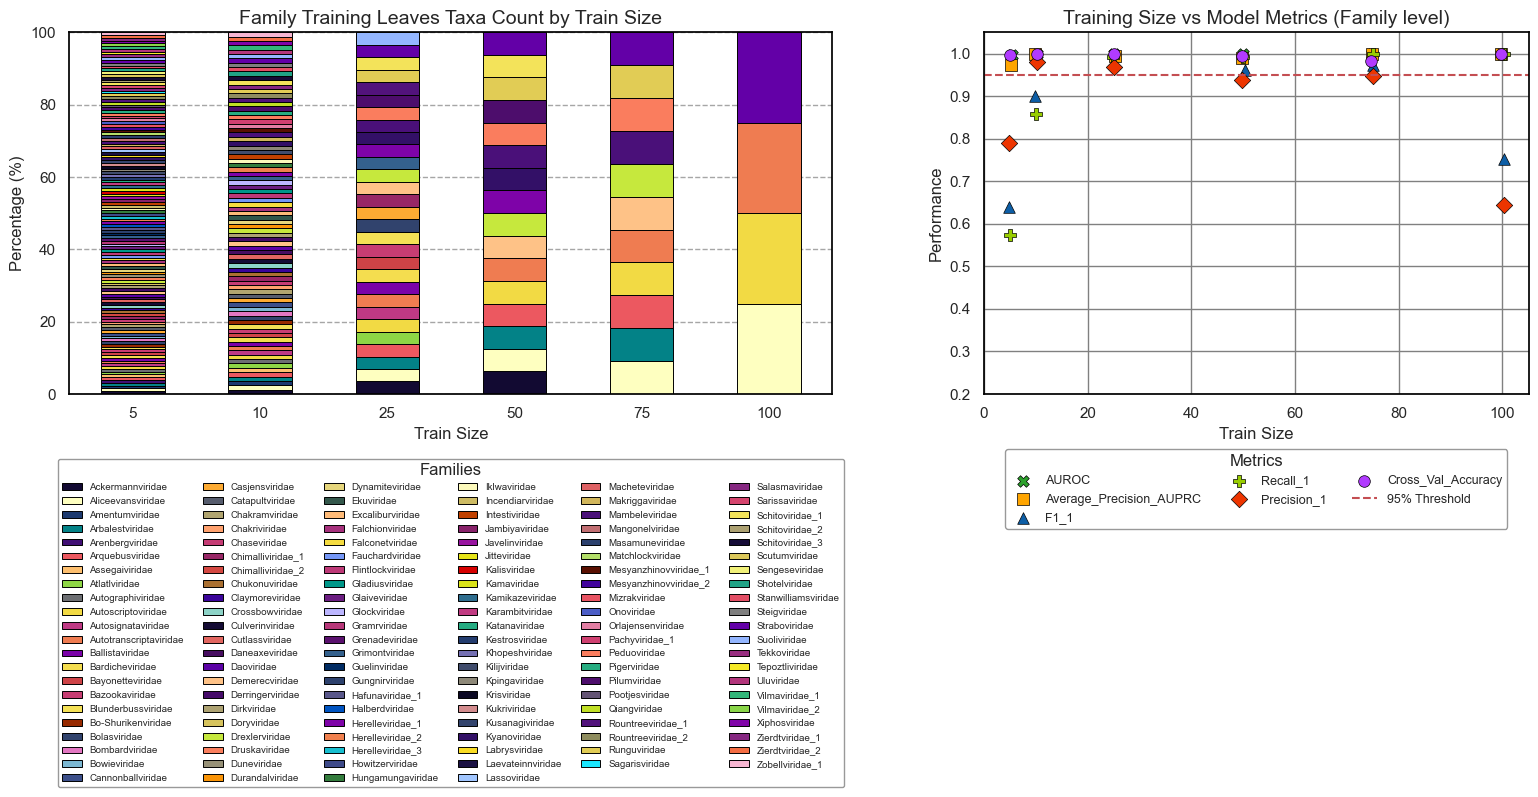

In [111]:
plot_training_metrics(family_results, combined_palette, rank="Family", output_file="../plots/family_training_metrics.png",
                      bottom_spacing=0.6, num_col_legend=6, bbox_to_anchor1_y=-1.1, bbox_to_anchor2_y=-0.39
                     )

# 1.3. Subfamily

In [73]:
filtered_df = filter_low_count_taxa(df, rank='Subfamily', min_count=5)
X_train, X_test, y_train, y_test = create_train_test(filtered_df, training_matrix_T, rank='Subfamily')
subfamily_results, subfamily_feature_importance = train_binary_classifiers(X_train, X_test, y_train, y_test, training_matrix_T, min_taxa_count=5, rank='Subfamily')

Balancing all taxa to 5 instances each.
Balanced Train Shape: (880, 20289), Unique taxa: 176
Y Train Value Counts: Subfamily
Actaeavirinae       5
Amaltheavirinae     5
Pclasvirinae        5
Pelczarvirinae      5
Phoebevirinae       5
                   ..
Halimedevirinae     5
Hendrixvirinae_1    5
Hi'iakavirinae      5
Himaliavirinae      5
Xiangliuvirinae     5
Name: count, Length: 176, dtype: int64
Y Train Training Value Counts: count
5    176
Name: count, dtype: int64


Training Subfamily classifiers..:   0%|                                                        | 0/176 [00:00<?, ?it/s]

Training Actaeavirinae vs. rest with size 5


Training Subfamily classifiers..:   1%|▎                                               | 1/176 [00:10<29:17, 10.05s/it]

Training Amaltheavirinae vs. rest with size 5


Training Subfamily classifiers..:   1%|▌                                               | 2/176 [00:20<30:27, 10.50s/it]

Training Pclasvirinae vs. rest with size 5


Training Subfamily classifiers..:   2%|▊                                               | 3/176 [00:31<30:13, 10.48s/it]

Training Pelczarvirinae vs. rest with size 5


Training Subfamily classifiers..:   2%|█                                               | 4/176 [00:42<30:40, 10.70s/it]

Training Phoebevirinae vs. rest with size 5


Training Subfamily classifiers..:   3%|█▎                                              | 5/176 [00:52<29:39, 10.41s/it]

Training Picovirinae vs. rest with size 5


Training Subfamily classifiers..:   3%|█▋                                              | 6/176 [01:04<31:07, 10.98s/it]

Training Poltergeistvirinae vs. rest with size 5


Training Subfamily classifiers..:   4%|█▉                                              | 7/176 [01:15<30:59, 11.00s/it]

Training Polydeucesvirinae vs. rest with size 5


Training Subfamily classifiers..:   5%|██▏                                             | 8/176 [01:25<29:35, 10.57s/it]

Training Portiavirinae vs. rest with size 5


Training Subfamily classifiers..:   5%|██▍                                             | 9/176 [01:35<29:16, 10.52s/it]

Training Prometheusvirinae vs. rest with size 5


Training Subfamily classifiers..:   6%|██▋                                            | 10/176 [01:45<28:48, 10.41s/it]

Training Prosperovirinae vs. rest with size 5


Training Subfamily classifiers..:   6%|██▉                                            | 11/176 [01:54<27:14,  9.91s/it]

Training Proteusvirinae vs. rest with size 5


Training Subfamily classifiers..:   7%|███▏                                           | 12/176 [02:04<27:39, 10.12s/it]

Training Puckvirinae vs. rest with size 5


Training Subfamily classifiers..:   7%|███▍                                           | 13/176 [02:14<27:19, 10.06s/it]

Training Queuovirinae_1 vs. rest with size 5


Training Subfamily classifiers..:   8%|███▋                                           | 14/176 [02:25<27:53, 10.33s/it]

Training Queuovirinae_2 vs. rest with size 5


Training Subfamily classifiers..:   9%|████                                           | 15/176 [02:37<28:56, 10.79s/it]

Training Quijotevirinae vs. rest with size 5


Training Subfamily classifiers..:   9%|████▎                                          | 16/176 [02:47<28:13, 10.58s/it]

Training Rabinowitzvirinae vs. rest with size 5


Training Subfamily classifiers..:  10%|████▌                                          | 17/176 [02:57<27:06, 10.23s/it]

Training Rakietenvirinae_1 vs. rest with size 5


Training Subfamily classifiers..:  10%|████▊                                          | 18/176 [03:08<27:23, 10.40s/it]

Training Rakietenvirinae_2 vs. rest with size 5


Training Subfamily classifiers..:  11%|█████                                          | 19/176 [03:20<29:08, 11.14s/it]

Training Rheavirinae vs. rest with size 5


Training Subfamily classifiers..:  11%|█████▎                                         | 20/176 [03:31<28:29, 10.96s/it]

Training Rhodovirinae vs. rest with size 5


Training Subfamily classifiers..:  12%|█████▌                                         | 21/176 [03:42<28:05, 10.87s/it]

Training Pasiphaevirinae vs. rest with size 5


Training Subfamily classifiers..:  12%|█████▉                                         | 22/176 [03:52<27:29, 10.71s/it]

Training Pandoravirinae vs. rest with size 5


Training Subfamily classifiers..:  13%|██████▏                                        | 23/176 [04:02<27:04, 10.62s/it]

Training Ounavirinae vs. rest with size 5


Training Subfamily classifiers..:  14%|██████▍                                        | 24/176 [04:11<25:38, 10.12s/it]

Training Namakavirinae vs. rest with size 5


Training Subfamily classifiers..:  14%|██████▋                                        | 25/176 [04:21<25:16, 10.05s/it]

Training Metisvirinae vs. rest with size 5


Training Subfamily classifiers..:  15%|██████▉                                        | 26/176 [04:31<25:02, 10.01s/it]

Training Migulavirinae vs. rest with size 5


Training Subfamily classifiers..:  15%|███████▏                                       | 27/176 [04:41<24:27,  9.85s/it]

Training Mimasvirinae vs. rest with size 5


Training Subfamily classifiers..:  16%|███████▍                                       | 28/176 [04:50<23:59,  9.73s/it]

Training Mirandavirinae vs. rest with size 5


Training Subfamily classifiers..:  16%|███████▋                                       | 29/176 [04:59<23:31,  9.60s/it]

Training Mnemevirinae vs. rest with size 5


Training Subfamily classifiers..:  17%|████████                                       | 30/176 [05:09<23:29,  9.66s/it]

Training Molineuxvirinae vs. rest with size 5


Training Subfamily classifiers..:  18%|████████▎                                      | 31/176 [05:20<24:05,  9.97s/it]

Training Moonvirinae vs. rest with size 5


Training Subfamily classifiers..:  18%|████████▌                                      | 32/176 [05:29<23:34,  9.83s/it]

Training Naiadvirinae vs. rest with size 5


Training Subfamily classifiers..:  19%|████████▊                                      | 33/176 [05:39<23:10,  9.72s/it]

Training Nclasvirinae vs. rest with size 5


Training Subfamily classifiers..:  19%|█████████                                      | 34/176 [05:49<23:14,  9.82s/it]

Training Orthosievirinae vs. rest with size 5


Training Subfamily classifiers..:  20%|█████████▎                                     | 35/176 [05:57<22:14,  9.46s/it]

Training Neraxisvirinae vs. rest with size 5


Training Subfamily classifiers..:  20%|█████████▌                                     | 36/176 [06:08<22:46,  9.76s/it]

Training Nereidvirinae vs. rest with size 5


Training Subfamily classifiers..:  21%|█████████▉                                     | 37/176 [06:17<22:23,  9.67s/it]

Training Nesovirinae vs. rest with size 5


Training Subfamily classifiers..:  22%|██████████▏                                    | 38/176 [06:28<23:14, 10.10s/it]

Training Northropvirinae vs. rest with size 5


Training Subfamily classifiers..:  22%|██████████▍                                    | 39/176 [06:39<23:26, 10.27s/it]

Training Nymbaxtervirinae vs. rest with size 5


Training Subfamily classifiers..:  23%|██████████▋                                    | 40/176 [06:48<22:39,  9.99s/it]

Training Oafivirinae vs. rest with size 5


Training Subfamily classifiers..:  23%|██████████▉                                    | 41/176 [06:58<21:56,  9.75s/it]

Training Oberonvirinae vs. rest with size 5


Training Subfamily classifiers..:  24%|███████████▏                                   | 42/176 [07:08<22:06,  9.90s/it]

Training Opheliavirinae vs. rest with size 5


Training Subfamily classifiers..:  24%|███████████▍                                   | 43/176 [07:20<23:06, 10.43s/it]

Training Rocinantevirinae vs. rest with size 5


Training Subfamily classifiers..:  25%|███████████▊                                   | 44/176 [07:30<23:01, 10.47s/it]

Training Rogunavirinae vs. rest with size 5


Training Subfamily classifiers..:  26%|████████████                                   | 45/176 [07:40<22:46, 10.43s/it]

Training Rosalindvirinae vs. rest with size 5


Training Subfamily classifiers..:  26%|████████████▎                                  | 46/176 [07:51<22:32, 10.41s/it]

Training Twarogvirinae vs. rest with size 5


Training Subfamily classifiers..:  27%|████████████▌                                  | 47/176 [08:00<21:33, 10.03s/it]

Training Thalassavirinae vs. rest with size 5


Training Subfamily classifiers..:  27%|████████████▊                                  | 48/176 [08:10<21:05,  9.89s/it]

Training Thebevirinae vs. rest with size 5


Training Subfamily classifiers..:  28%|█████████████                                  | 49/176 [08:19<20:52,  9.87s/it]

Training Thestiasvirinae vs. rest with size 5


Training Subfamily classifiers..:  28%|█████████████▎                                 | 50/176 [08:30<20:58,  9.99s/it]

Training Threxiavirinae vs. rest with size 5


Training Subfamily classifiers..:  29%|█████████████▌                                 | 51/176 [08:41<21:43, 10.43s/it]

Training Titaniavirinae vs. rest with size 5


Training Subfamily classifiers..:  30%|█████████████▉                                 | 52/176 [08:52<21:33, 10.43s/it]

Training Titanvirinae vs. rest with size 5


Training Subfamily classifiers..:  30%|██████████████▏                                | 53/176 [09:02<21:39, 10.56s/it]

Training Toshachvirinae vs. rest with size 5


Training Subfamily classifiers..:  31%|██████████████▍                                | 54/176 [09:13<21:18, 10.48s/it]

Training Tritonvirinae vs. rest with size 5


Training Subfamily classifiers..:  31%|██████████████▋                                | 55/176 [09:24<21:25, 10.62s/it]

Training Twortvirinae vs. rest with size 5


Training Subfamily classifiers..:  32%|██████████████▉                                | 56/176 [09:33<20:38, 10.32s/it]

Training Tethysvirinae vs. rest with size 5


Training Subfamily classifiers..:  32%|███████████████▏                               | 57/176 [09:43<20:19, 10.25s/it]

Training Tybeckvirinae_1 vs. rest with size 5


Training Subfamily classifiers..:  33%|███████████████▍                               | 58/176 [09:53<20:03, 10.20s/it]

Training Umbrielvirinae vs. rest with size 5


Training Subfamily classifiers..:  34%|███████████████▊                               | 59/176 [10:04<20:16, 10.40s/it]

Training Vanthvirinae vs. rest with size 5


Training Subfamily classifiers..:  34%|████████████████                               | 60/176 [10:15<20:04, 10.38s/it]

Training Vequintavirinae_1 vs. rest with size 5


Training Subfamily classifiers..:  35%|████████████████▎                              | 61/176 [10:25<19:40, 10.27s/it]

Training Vequintavirinae_2 vs. rest with size 5


Training Subfamily classifiers..:  35%|████████████████▌                              | 62/176 [10:34<19:14, 10.13s/it]

Training Weiservirinae_1 vs. rest with size 5


Training Subfamily classifiers..:  36%|████████████████▊                              | 63/176 [10:45<19:18, 10.25s/it]

Training Weiservirinae_2 vs. rest with size 5


Training Subfamily classifiers..:  36%|█████████████████                              | 64/176 [10:55<18:50, 10.09s/it]

Training Weywotvirinae vs. rest with size 5


Training Subfamily classifiers..:  37%|█████████████████▎                             | 65/176 [11:06<19:10, 10.37s/it]

Training Tevenvirinae vs. rest with size 5


Training Subfamily classifiers..:  38%|█████████████████▋                             | 66/176 [11:15<18:41, 10.19s/it]

Training Tempevirinae_1 vs. rest with size 5


Training Subfamily classifiers..:  38%|█████████████████▉                             | 67/176 [11:26<18:46, 10.34s/it]

Training Rothmandenesvirinae vs. rest with size 5


Training Subfamily classifiers..:  39%|██████████████████▏                            | 68/176 [11:37<18:57, 10.54s/it]

Training Sepvirinae vs. rest with size 5


Training Subfamily classifiers..:  39%|██████████████████▍                            | 69/176 [11:47<18:33, 10.41s/it]

Training Ruthgordonvirinae vs. rest with size 5


Training Subfamily classifiers..:  40%|██████████████████▋                            | 70/176 [11:59<18:52, 10.69s/it]

Training Saffarvirinae vs. rest with size 5


Training Subfamily classifiers..:  40%|██████████████████▉                            | 71/176 [12:10<19:19, 11.04s/it]

Training Samhvirinae vs. rest with size 5


Training Subfamily classifiers..:  41%|███████████████████▏                           | 72/176 [12:22<19:29, 11.25s/it]

Training Sanchovirinae vs. rest with size 5


Training Subfamily classifiers..:  41%|███████████████████▍                           | 73/176 [12:34<19:49, 11.55s/it]

Training Saovirinae vs. rest with size 5


Training Subfamily classifiers..:  42%|███████████████████▊                           | 74/176 [12:44<18:45, 11.03s/it]

Training Sarlesvirinae_1 vs. rest with size 5


Training Subfamily classifiers..:  43%|████████████████████                           | 75/176 [12:55<18:39, 11.09s/it]

Training Sechaudvirinae_1 vs. rest with size 5


Training Subfamily classifiers..:  43%|████████████████████▎                          | 76/176 [13:07<18:31, 11.11s/it]

Training Sejongvirinae vs. rest with size 5


Training Subfamily classifiers..:  44%|████████████████████▌                          | 77/176 [13:17<18:03, 10.94s/it]

Training Setebosvirinae vs. rest with size 5


Training Subfamily classifiers..:  44%|████████████████████▊                          | 78/176 [13:28<17:53, 10.95s/it]

Training Tatarstanvirinae vs. rest with size 5


Training Subfamily classifiers..:  45%|█████████████████████                          | 79/176 [13:42<18:53, 11.69s/it]

Training Siarnaqvirinae vs. rest with size 5


Training Subfamily classifiers..:  45%|█████████████████████▎                         | 80/176 [13:54<19:04, 11.92s/it]

Training Skurskavirinae vs. rest with size 5


Training Subfamily classifiers..:  46%|█████████████████████▋                         | 81/176 [14:06<18:49, 11.88s/it]

Training Slopekvirinae vs. rest with size 5


Training Subfamily classifiers..:  47%|█████████████████████▉                         | 82/176 [14:19<19:23, 12.38s/it]

Training Staniewskivirinae vs. rest with size 5


Training Subfamily classifiers..:  47%|██████████████████████▏                        | 83/176 [14:31<18:45, 12.10s/it]

Training Stephanstirmvirinae vs. rest with size 5


Training Subfamily classifiers..:  48%|██████████████████████▍                        | 84/176 [14:42<18:13, 11.88s/it]

Training Studiervirinae_1 vs. rest with size 5


Training Subfamily classifiers..:  48%|██████████████████████▋                        | 85/176 [14:55<18:24, 12.14s/it]

Training Sycoraxvirinae vs. rest with size 5


Training Subfamily classifiers..:  49%|██████████████████████▉                        | 86/176 [15:07<18:22, 12.25s/it]

Training Taphaovirinae vs. rest with size 5


Training Subfamily classifiers..:  49%|███████████████████████▏                       | 87/176 [15:19<17:52, 12.05s/it]

Training Melnykvirinae vs. rest with size 5


Training Subfamily classifiers..:  50%|███████████████████████▌                       | 88/176 [15:32<17:59, 12.27s/it]

Training Mclasvirinae vs. rest with size 5


Training Subfamily classifiers..:  51%|███████████████████████▊                       | 89/176 [15:44<17:43, 12.22s/it]

Training Mccleskeyvirinae vs. rest with size 5


Training Subfamily classifiers..:  51%|████████████████████████                       | 90/176 [15:57<17:49, 12.43s/it]

Training Deejayvirinae vs. rest with size 5


Training Subfamily classifiers..:  52%|████████████████████████▎                      | 91/176 [16:09<17:31, 12.37s/it]

Training Carpovirinae vs. rest with size 5


Training Subfamily classifiers..:  52%|████████████████████████▌                      | 92/176 [16:21<17:02, 12.18s/it]

Training Ceeclamvirinae_1 vs. rest with size 5


Training Subfamily classifiers..:  53%|████████████████████████▊                      | 93/176 [16:33<16:49, 12.17s/it]

Training Ceeclamvirinae_2 vs. rest with size 5


Training Subfamily classifiers..:  53%|█████████████████████████                      | 94/176 [16:45<16:25, 12.02s/it]

Training Charonvirinae vs. rest with size 5


Training Subfamily classifiers..:  54%|█████████████████████████▎                     | 95/176 [16:57<16:29, 12.21s/it]

Training Cleopatravirinae vs. rest with size 5


Training Subfamily classifiers..:  55%|█████████████████████████▋                     | 96/176 [17:10<16:27, 12.35s/it]

Training Cressidavirinae vs. rest with size 5


Training Subfamily classifiers..:  55%|█████████████████████████▉                     | 97/176 [17:23<16:21, 12.43s/it]

Training Crudevirinae vs. rest with size 5


Training Subfamily classifiers..:  56%|██████████████████████████▏                    | 98/176 [17:36<16:21, 12.58s/it]

Training Cvivirinae vs. rest with size 5


Training Subfamily classifiers..:  56%|██████████████████████████▍                    | 99/176 [17:47<15:54, 12.40s/it]

Training Deeyouvirinae vs. rest with size 5


Training Subfamily classifiers..:  57%|██████████████████████████▏                   | 100/176 [17:59<15:32, 12.28s/it]

Training Callistovirinae vs. rest with size 5


Training Subfamily classifiers..:  57%|██████████████████████████▍                   | 101/176 [18:12<15:25, 12.34s/it]

Training Demetervirinae vs. rest with size 5


Training Subfamily classifiers..:  58%|██████████████████████████▋                   | 102/176 [18:24<14:58, 12.14s/it]

Training Desdemonavirinae vs. rest with size 5


Training Subfamily classifiers..:  59%|██████████████████████████▉                   | 103/176 [18:35<14:34, 11.99s/it]

Training Despinavirinae vs. rest with size 5


Training Subfamily classifiers..:  59%|███████████████████████████▏                  | 104/176 [18:47<14:10, 11.82s/it]

Training Dionevirinae vs. rest with size 5


Training Subfamily classifiers..:  60%|███████████████████████████▍                  | 105/176 [18:59<14:10, 11.98s/it]

Training Draugrvirinae vs. rest with size 5


Training Subfamily classifiers..:  60%|███████████████████████████▋                  | 106/176 [19:12<14:22, 12.33s/it]

Training Dulcineavirinae vs. rest with size 5


Training Subfamily classifiers..:  61%|███████████████████████████▉                  | 107/176 [19:24<14:02, 12.20s/it]

Training Dysnomiavirinae vs. rest with size 5


Training Subfamily classifiers..:  61%|████████████████████████████▏                 | 108/176 [19:37<13:56, 12.30s/it]

Training Elaravirinae vs. rest with size 5


Training Subfamily classifiers..:  62%|████████████████████████████▍                 | 109/176 [19:49<13:47, 12.35s/it]

Training Carmevirinae vs. rest with size 5


Training Subfamily classifiers..:  62%|████████████████████████████▊                 | 110/176 [20:02<13:43, 12.48s/it]

Training Calibanvirinae vs. rest with size 5


Training Subfamily classifiers..:  63%|█████████████████████████████                 | 111/176 [20:14<13:21, 12.34s/it]

Training Enceladusvirinae vs. rest with size 5


Training Subfamily classifiers..:  64%|█████████████████████████████▎                | 112/176 [20:26<12:58, 12.16s/it]

Training Bastillevirinae_3 vs. rest with size 5


Training Subfamily classifiers..:  64%|█████████████████████████████▌                | 113/176 [20:37<12:34, 11.98s/it]

Training Arielvirinae vs. rest with size 5


Training Subfamily classifiers..:  65%|█████████████████████████████▊                | 114/176 [20:49<12:21, 11.96s/it]

Training Arquatrovirinae vs. rest with size 5


Training Subfamily classifiers..:  65%|██████████████████████████████                | 115/176 [21:02<12:19, 12.13s/it]

Training Asinivirinae_1 vs. rest with size 5


Training Subfamily classifiers..:  66%|██████████████████████████████▎               | 116/176 [21:14<12:10, 12.17s/it]

Training Azeevirinae vs. rest with size 5


Training Subfamily classifiers..:  66%|██████████████████████████████▌               | 117/176 [21:26<12:02, 12.24s/it]

Training Azeredovirinae_1 vs. rest with size 5


Training Subfamily classifiers..:  67%|██████████████████████████████▊               | 118/176 [21:39<12:01, 12.44s/it]

Training Azeredovirinae_2 vs. rest with size 5


Training Subfamily classifiers..:  68%|███████████████████████████████               | 119/176 [21:51<11:45, 12.38s/it]

Training Bastillevirinae_1 vs. rest with size 5


Training Subfamily classifiers..:  68%|███████████████████████████████▎              | 120/176 [22:04<11:30, 12.33s/it]

Training Bastillevirinae_2 vs. rest with size 5


Training Subfamily classifiers..:  69%|███████████████████████████████▋              | 121/176 [22:15<11:06, 12.11s/it]

Training Bastillevirinae_4 vs. rest with size 5


Training Subfamily classifiers..:  69%|███████████████████████████████▉              | 122/176 [22:27<10:40, 11.87s/it]

Training Bronfenbrennervirinae_2 vs. rest with size 5


Training Subfamily classifiers..:  70%|████████████████████████████████▏             | 123/176 [22:40<10:46, 12.20s/it]

Training Bclasvirinae_1 vs. rest with size 5


Training Subfamily classifiers..:  70%|████████████████████████████████▍             | 124/176 [22:52<10:32, 12.16s/it]

Training Bclasvirinae_2 vs. rest with size 5


Training Subfamily classifiers..:  71%|████████████████████████████████▋             | 125/176 [23:03<10:15, 12.07s/it]

Training Beijerinckvirinae_1 vs. rest with size 5


Training Subfamily classifiers..:  72%|████████████████████████████████▉             | 126/176 [23:16<10:11, 12.23s/it]

Training Belindavirinae vs. rest with size 5


Training Subfamily classifiers..:  72%|█████████████████████████████████▏            | 127/176 [23:29<10:13, 12.51s/it]

Training Biancavirinae vs. rest with size 5


Training Subfamily classifiers..:  73%|█████████████████████████████████▍            | 128/176 [23:42<10:05, 12.62s/it]

Training Boydwoodruffvirinae vs. rest with size 5


Training Subfamily classifiers..:  73%|█████████████████████████████████▋            | 129/176 [23:53<09:34, 12.22s/it]

Training Brockvirinae_1 vs. rest with size 5


Training Subfamily classifiers..:  74%|█████████████████████████████████▉            | 130/176 [24:05<09:13, 12.03s/it]

Training Bronfenbrennervirinae_1 vs. rest with size 5


Training Subfamily classifiers..:  74%|██████████████████████████████████▏           | 131/176 [24:18<09:14, 12.33s/it]

Training Emilbogenvirinae vs. rest with size 5


Training Subfamily classifiers..:  75%|██████████████████████████████████▌           | 132/176 [24:30<08:53, 12.13s/it]

Training Enquatrovirinae vs. rest with size 5


Training Subfamily classifiers..:  76%|██████████████████████████████████▊           | 133/176 [24:42<08:45, 12.23s/it]

Training Markadamsvirinae vs. rest with size 5


Training Subfamily classifiers..:  76%|███████████████████████████████████           | 134/176 [24:54<08:31, 12.17s/it]

Training Kantovirinae vs. rest with size 5


Training Subfamily classifiers..:  77%|███████████████████████████████████▎          | 135/176 [25:07<08:30, 12.46s/it]

Training Ilmarëvirinae vs. rest with size 5


Training Subfamily classifiers..:  77%|███████████████████████████████████▌          | 136/176 [25:20<08:20, 12.52s/it]

Training Iovirinae vs. rest with size 5


Training Subfamily classifiers..:  78%|███████████████████████████████████▊          | 137/176 [25:32<07:59, 12.31s/it]

Training Jameshumphriesvirinae vs. rest with size 5


Training Subfamily classifiers..:  78%|████████████████████████████████████          | 138/176 [25:45<07:56, 12.53s/it]

Training Janusvirinae vs. rest with size 5


Training Subfamily classifiers..:  79%|████████████████████████████████████▎         | 139/176 [25:58<07:45, 12.58s/it]

Training Jasinskavirinae vs. rest with size 5


Training Subfamily classifiers..:  80%|████████████████████████████████████▌         | 140/176 [26:09<07:19, 12.22s/it]

Training Joanripponvirinae vs. rest with size 5


Training Subfamily classifiers..:  80%|████████████████████████████████████▊         | 141/176 [26:21<07:02, 12.07s/it]

Training Jondennisvirinae vs. rest with size 5


Training Subfamily classifiers..:  81%|█████████████████████████████████████         | 142/176 [26:34<07:01, 12.39s/it]

Training Julietvirinae vs. rest with size 5


Training Subfamily classifiers..:  81%|█████████████████████████████████████▍        | 143/176 [26:48<07:05, 12.89s/it]

Training Krylovirinae vs. rest with size 5


Training Subfamily classifiers..:  82%|█████████████████████████████████████▋        | 144/176 [27:01<06:55, 13.00s/it]

Training Iapetusvirinae vs. rest with size 5


Training Subfamily classifiers..:  82%|█████████████████████████████████████▉        | 145/176 [27:13<06:32, 12.67s/it]

Training Kutznervirinae_1 vs. rest with size 5


Training Subfamily classifiers..:  83%|██████████████████████████████████████▏       | 146/176 [27:25<06:13, 12.46s/it]

Training Langleyhallvirinae vs. rest with size 5


Training Subfamily classifiers..:  84%|██████████████████████████████████████▍       | 147/176 [27:37<05:56, 12.30s/it]

Training Larissavirinae vs. rest with size 5


Training Subfamily classifiers..:  84%|██████████████████████████████████████▋       | 148/176 [27:49<05:39, 12.13s/it]

Training Lclasvirinae vs. rest with size 5


Training Subfamily classifiers..:  85%|██████████████████████████████████████▉       | 149/176 [28:00<05:23, 12.00s/it]

Training Loccivirinae vs. rest with size 5


Training Subfamily classifiers..:  85%|███████████████████████████████████████▏      | 150/176 [28:12<05:11, 12.00s/it]

Training Loutivirinae vs. rest with size 5


Training Subfamily classifiers..:  86%|███████████████████████████████████████▍      | 151/176 [28:25<05:03, 12.12s/it]

Training Lysitheavirinae vs. rest with size 5


Training Subfamily classifiers..:  86%|███████████████████████████████████████▋      | 152/176 [28:37<04:49, 12.05s/it]

Training Majritivirinae vs. rest with size 5


Training Subfamily classifiers..:  87%|███████████████████████████████████████▉      | 153/176 [28:49<04:41, 12.23s/it]

Training Iiscvirinae vs. rest with size 5


Training Subfamily classifiers..:  88%|████████████████████████████████████████▎     | 154/176 [29:02<04:30, 12.29s/it]

Training Hyperionvirinae vs. rest with size 5


Training Subfamily classifiers..:  88%|████████████████████████████████████████▌     | 155/176 [29:14<04:16, 12.20s/it]

Training Epimetheusvirinae vs. rest with size 5


Training Subfamily classifiers..:  89%|████████████████████████████████████████▊     | 156/176 [29:26<04:04, 12.24s/it]

Training Gordonclarkvirinae vs. rest with size 5


Training Subfamily classifiers..:  89%|█████████████████████████████████████████     | 157/176 [29:38<03:50, 12.14s/it]

Training Ermolyevavirinae vs. rest with size 5


Training Subfamily classifiers..:  90%|█████████████████████████████████████████▎    | 158/176 [29:49<03:34, 11.93s/it]

Training Euphemevirinae vs. rest with size 5


Training Subfamily classifiers..:  90%|█████████████████████████████████████████▌    | 159/176 [30:02<03:27, 12.20s/it]

Training Euporievirinae vs. rest with size 5


Training Subfamily classifiers..:  91%|█████████████████████████████████████████▊    | 160/176 [30:14<03:14, 12.13s/it]

Training Europavirinae vs. rest with size 5


Training Subfamily classifiers..:  91%|██████████████████████████████████████████    | 161/176 [30:26<03:03, 12.21s/it]

Training Fortitudovirinae vs. rest with size 5


Training Subfamily classifiers..:  92%|██████████████████████████████████████████▎   | 162/176 [30:38<02:47, 11.99s/it]

Training Galateavirinae vs. rest with size 5


Training Subfamily classifiers..:  93%|██████████████████████████████████████████▌   | 163/176 [30:50<02:37, 12.11s/it]

Training Ganymedevirinae vs. rest with size 5


Training Subfamily classifiers..:  93%|██████████████████████████████████████████▊   | 164/176 [31:03<02:26, 12.24s/it]

Training Gclasvirinae vs. rest with size 5


Training Subfamily classifiers..:  94%|███████████████████████████████████████████▏  | 165/176 [31:16<02:17, 12.49s/it]

Training Gorgonvirinae vs. rest with size 5


Training Subfamily classifiers..:  94%|███████████████████████████████████████████▍  | 166/176 [31:28<02:02, 12.20s/it]

Training Humphriesvirinae vs. rest with size 5


Training Subfamily classifiers..:  95%|███████████████████████████████████████████▋  | 167/176 [31:40<01:51, 12.34s/it]

Training Gracegardnervirinae_1 vs. rest with size 5


Training Subfamily classifiers..:  95%|███████████████████████████████████████████▉  | 168/176 [31:52<01:38, 12.33s/it]

Training Gracegardnervirinae_2 vs. rest with size 5


Training Subfamily classifiers..:  96%|████████████████████████████████████████████▏ | 169/176 [32:05<01:26, 12.33s/it]

Training Guarnerosvirinae vs. rest with size 5


Training Subfamily classifiers..:  97%|████████████████████████████████████████████▍ | 170/176 [32:18<01:15, 12.58s/it]

Training Guernseyvirinae_1 vs. rest with size 5


Training Subfamily classifiers..:  97%|████████████████████████████████████████████▋ | 171/176 [32:31<01:03, 12.75s/it]

Training Halimedevirinae vs. rest with size 5


Training Subfamily classifiers..:  98%|████████████████████████████████████████████▉ | 172/176 [32:43<00:50, 12.63s/it]

Training Hendrixvirinae_1 vs. rest with size 5


Training Subfamily classifiers..:  98%|█████████████████████████████████████████████▏| 173/176 [32:56<00:37, 12.66s/it]

Training Hi'iakavirinae vs. rest with size 5


Training Subfamily classifiers..:  99%|█████████████████████████████████████████████▍| 174/176 [33:09<00:25, 12.79s/it]

Training Himaliavirinae vs. rest with size 5


Training Subfamily classifiers..:  99%|█████████████████████████████████████████████▋| 175/176 [33:21<00:12, 12.36s/it]

Training Xiangliuvirinae vs. rest with size 5


Training Subfamily classifiers..: 100%|██████████████████████████████████████████████| 176/176 [33:31<00:00, 11.43s/it]


Balancing all taxa to 7 instances each.
Balanced Train Shape: (812, 20289), Unique taxa: 116
Y Train Value Counts: Subfamily
Actaeavirinae        7
Ounavirinae          7
Rheavirinae          7
Rakietenvirinae_2    7
Rakietenvirinae_1    7
                    ..
Ganymedevirinae      7
Galateavirinae       7
Europavirinae        7
Ermolyevavirinae     7
Weywotvirinae        7
Name: count, Length: 116, dtype: int64
Y Train Training Value Counts: count
7    116
Name: count, dtype: int64


Training Subfamily classifiers..:   0%|                                                        | 0/116 [00:00<?, ?it/s]

Training Actaeavirinae vs. rest with size 7


Training Subfamily classifiers..:   1%|▍                                               | 1/116 [00:10<20:22, 10.63s/it]

Training Ounavirinae vs. rest with size 7


Training Subfamily classifiers..:   2%|▊                                               | 2/116 [00:20<19:43, 10.38s/it]

Training Rheavirinae vs. rest with size 7


Training Subfamily classifiers..:   3%|█▏                                              | 3/116 [00:31<19:52, 10.55s/it]

Training Rakietenvirinae_2 vs. rest with size 7


Training Subfamily classifiers..:   3%|█▋                                              | 4/116 [00:45<22:23, 11.99s/it]

Training Rakietenvirinae_1 vs. rest with size 7


Training Subfamily classifiers..:   4%|██                                              | 5/116 [00:57<22:11, 12.00s/it]

Training Rabinowitzvirinae vs. rest with size 7


Training Subfamily classifiers..:   5%|██▍                                             | 6/116 [01:07<20:36, 11.24s/it]

Training Quijotevirinae vs. rest with size 7


Training Subfamily classifiers..:   6%|██▉                                             | 7/116 [01:17<19:40, 10.83s/it]

Training Puckvirinae vs. rest with size 7


Training Subfamily classifiers..:   7%|███▎                                            | 8/116 [01:27<18:54, 10.51s/it]

Training Proteusvirinae vs. rest with size 7


Training Subfamily classifiers..:   8%|███▋                                            | 9/116 [01:37<18:22, 10.31s/it]

Training Polydeucesvirinae vs. rest with size 7


Training Subfamily classifiers..:   9%|████                                           | 10/116 [01:47<18:01, 10.21s/it]

Training Picovirinae vs. rest with size 7


Training Subfamily classifiers..:   9%|████▍                                          | 11/116 [01:59<19:03, 10.89s/it]

Training Phoebevirinae vs. rest with size 7


Training Subfamily classifiers..:  10%|████▊                                          | 12/116 [02:10<18:44, 10.81s/it]

Training Pelczarvirinae vs. rest with size 7


Training Subfamily classifiers..:  11%|█████▎                                         | 13/116 [02:21<18:56, 11.03s/it]

Training Pclasvirinae vs. rest with size 7


Training Subfamily classifiers..:  12%|█████▋                                         | 14/116 [02:32<18:22, 10.81s/it]

Training Oberonvirinae vs. rest with size 7


Training Subfamily classifiers..:  13%|██████                                         | 15/116 [02:42<18:00, 10.69s/it]

Training Amaltheavirinae vs. rest with size 7


Training Subfamily classifiers..:  14%|██████▍                                        | 16/116 [02:53<17:42, 10.63s/it]

Training Nymbaxtervirinae vs. rest with size 7


Training Subfamily classifiers..:  15%|██████▉                                        | 17/116 [03:03<17:42, 10.73s/it]

Training Northropvirinae vs. rest with size 7


Training Subfamily classifiers..:  16%|███████▎                                       | 18/116 [03:15<17:46, 10.88s/it]

Training Nereidvirinae vs. rest with size 7


Training Subfamily classifiers..:  16%|███████▋                                       | 19/116 [03:25<17:05, 10.57s/it]

Training Neraxisvirinae vs. rest with size 7


Training Subfamily classifiers..:  17%|████████                                       | 20/116 [03:36<17:26, 10.90s/it]

Training Nclasvirinae vs. rest with size 7


Training Subfamily classifiers..:  18%|████████▌                                      | 21/116 [03:47<17:08, 10.83s/it]

Training Namakavirinae vs. rest with size 7


Training Subfamily classifiers..:  19%|████████▉                                      | 22/116 [03:58<17:01, 10.87s/it]

Training Moonvirinae vs. rest with size 7


Training Subfamily classifiers..:  20%|█████████▎                                     | 23/116 [04:08<16:36, 10.71s/it]

Training Molineuxvirinae vs. rest with size 7


Training Subfamily classifiers..:  21%|█████████▋                                     | 24/116 [04:19<16:29, 10.76s/it]

Training Mirandavirinae vs. rest with size 7


Training Subfamily classifiers..:  22%|██████████▏                                    | 25/116 [04:29<15:53, 10.47s/it]

Training Mimasvirinae vs. rest with size 7


Training Subfamily classifiers..:  22%|██████████▌                                    | 26/116 [04:38<15:18, 10.20s/it]

Training Migulavirinae vs. rest with size 7


Training Subfamily classifiers..:  23%|██████████▉                                    | 27/116 [04:49<15:06, 10.19s/it]

Training Melnykvirinae vs. rest with size 7


Training Subfamily classifiers..:  24%|███████████▎                                   | 28/116 [05:01<15:44, 10.73s/it]

Training Rhodovirinae vs. rest with size 7


Training Subfamily classifiers..:  25%|███████████▊                                   | 29/116 [05:11<15:25, 10.64s/it]

Training Rocinantevirinae vs. rest with size 7


Training Subfamily classifiers..:  26%|████████████▏                                  | 30/116 [05:21<14:45, 10.29s/it]

Training Rogunavirinae vs. rest with size 7


Training Subfamily classifiers..:  27%|████████████▌                                  | 31/116 [05:31<14:34, 10.29s/it]

Training Rothmandenesvirinae vs. rest with size 7


Training Subfamily classifiers..:  28%|████████████▉                                  | 32/116 [05:41<14:28, 10.33s/it]

Training Weiservirinae_2 vs. rest with size 7


Training Subfamily classifiers..:  28%|█████████████▎                                 | 33/116 [05:51<14:03, 10.16s/it]

Training Weiservirinae_1 vs. rest with size 7


Training Subfamily classifiers..:  29%|█████████████▊                                 | 34/116 [06:01<13:53, 10.16s/it]

Training Vequintavirinae_1 vs. rest with size 7


Training Subfamily classifiers..:  30%|██████████████▏                                | 35/116 [06:11<13:23,  9.92s/it]

Training Vanthvirinae vs. rest with size 7


Training Subfamily classifiers..:  31%|██████████████▌                                | 36/116 [06:21<13:20, 10.00s/it]

Training Umbrielvirinae vs. rest with size 7


Training Subfamily classifiers..:  32%|██████████████▉                                | 37/116 [06:31<13:08,  9.98s/it]

Training Twortvirinae vs. rest with size 7


Training Subfamily classifiers..:  33%|███████████████▍                               | 38/116 [06:41<12:55,  9.94s/it]

Training Twarogvirinae vs. rest with size 7


Training Subfamily classifiers..:  34%|███████████████▊                               | 39/116 [06:50<12:38,  9.85s/it]

Training Tritonvirinae vs. rest with size 7


Training Subfamily classifiers..:  34%|████████████████▏                              | 40/116 [07:00<12:39,  9.99s/it]

Training Titanvirinae vs. rest with size 7


Training Subfamily classifiers..:  35%|████████████████▌                              | 41/116 [07:12<13:00, 10.41s/it]

Training Titaniavirinae vs. rest with size 7


Training Subfamily classifiers..:  36%|█████████████████                              | 42/116 [07:22<12:42, 10.30s/it]

Training Threxiavirinae vs. rest with size 7


Training Subfamily classifiers..:  37%|█████████████████▍                             | 43/116 [07:34<13:07, 10.79s/it]

Training Tevenvirinae vs. rest with size 7


Training Subfamily classifiers..:  38%|█████████████████▊                             | 44/116 [07:43<12:26, 10.37s/it]

Training Tethysvirinae vs. rest with size 7


Training Subfamily classifiers..:  39%|██████████████████▏                            | 45/116 [07:54<12:26, 10.51s/it]

Training Tempevirinae_1 vs. rest with size 7


Training Subfamily classifiers..:  40%|██████████████████▋                            | 46/116 [08:04<12:03, 10.33s/it]

Training Sycoraxvirinae vs. rest with size 7


Training Subfamily classifiers..:  41%|███████████████████                            | 47/116 [08:14<11:46, 10.24s/it]

Training Studiervirinae_1 vs. rest with size 7


Training Subfamily classifiers..:  41%|███████████████████▍                           | 48/116 [08:25<11:45, 10.37s/it]

Training Stephanstirmvirinae vs. rest with size 7


Training Subfamily classifiers..:  42%|███████████████████▊                           | 49/116 [08:34<11:14, 10.07s/it]

Training Staniewskivirinae vs. rest with size 7


Training Subfamily classifiers..:  43%|████████████████████▎                          | 50/116 [08:44<11:00, 10.00s/it]

Training Slopekvirinae vs. rest with size 7


Training Subfamily classifiers..:  44%|████████████████████▋                          | 51/116 [08:55<11:16, 10.40s/it]

Training Skurskavirinae vs. rest with size 7


Training Subfamily classifiers..:  45%|█████████████████████                          | 52/116 [09:05<10:53, 10.22s/it]

Training Sepvirinae vs. rest with size 7


Training Subfamily classifiers..:  46%|█████████████████████▍                         | 53/116 [09:15<10:40, 10.16s/it]

Training Sejongvirinae vs. rest with size 7


Training Subfamily classifiers..:  47%|█████████████████████▉                         | 54/116 [09:25<10:33, 10.21s/it]

Training Sechaudvirinae_1 vs. rest with size 7


Training Subfamily classifiers..:  47%|██████████████████████▎                        | 55/116 [09:36<10:31, 10.34s/it]

Training Sarlesvirinae_1 vs. rest with size 7


Training Subfamily classifiers..:  48%|██████████████████████▋                        | 56/116 [09:47<10:38, 10.64s/it]

Training Sanchovirinae vs. rest with size 7


Training Subfamily classifiers..:  49%|███████████████████████                        | 57/116 [10:00<10:57, 11.15s/it]

Training Mccleskeyvirinae vs. rest with size 7


Training Subfamily classifiers..:  50%|███████████████████████▌                       | 58/116 [10:10<10:38, 11.02s/it]

Training Markadamsvirinae vs. rest with size 7


Training Subfamily classifiers..:  51%|███████████████████████▉                       | 59/116 [10:20<10:07, 10.66s/it]

Training Loutivirinae vs. rest with size 7


Training Subfamily classifiers..:  52%|████████████████████████▎                      | 60/116 [10:31<09:53, 10.59s/it]

Training Emilbogenvirinae vs. rest with size 7


Training Subfamily classifiers..:  53%|████████████████████████▋                      | 61/116 [10:41<09:43, 10.61s/it]

Training Dulcineavirinae vs. rest with size 7


Training Subfamily classifiers..:  53%|█████████████████████████                      | 62/116 [10:51<09:25, 10.47s/it]

Training Dionevirinae vs. rest with size 7


Training Subfamily classifiers..:  54%|█████████████████████████▌                     | 63/116 [11:03<09:31, 10.79s/it]

Training Despinavirinae vs. rest with size 7


Training Subfamily classifiers..:  55%|█████████████████████████▉                     | 64/116 [11:13<09:14, 10.67s/it]

Training Deejayvirinae vs. rest with size 7


Training Subfamily classifiers..:  56%|██████████████████████████▎                    | 65/116 [11:23<08:52, 10.45s/it]

Training Cvivirinae vs. rest with size 7


Training Subfamily classifiers..:  57%|██████████████████████████▋                    | 66/116 [11:33<08:34, 10.29s/it]

Training Crudevirinae vs. rest with size 7


Training Subfamily classifiers..:  58%|███████████████████████████▏                   | 67/116 [11:44<08:37, 10.57s/it]

Training Cleopatravirinae vs. rest with size 7


Training Subfamily classifiers..:  59%|███████████████████████████▌                   | 68/116 [11:55<08:22, 10.46s/it]

Training Charonvirinae vs. rest with size 7


Training Subfamily classifiers..:  59%|███████████████████████████▉                   | 69/116 [12:05<08:08, 10.40s/it]

Training Ceeclamvirinae_2 vs. rest with size 7


Training Subfamily classifiers..:  60%|████████████████████████████▎                  | 70/116 [12:14<07:42, 10.06s/it]

Training Carpovirinae vs. rest with size 7


Training Subfamily classifiers..:  61%|████████████████████████████▊                  | 71/116 [12:24<07:26,  9.92s/it]

Training Callistovirinae vs. rest with size 7


Training Subfamily classifiers..:  62%|█████████████████████████████▏                 | 72/116 [12:34<07:24, 10.10s/it]

Training Bronfenbrennervirinae_2 vs. rest with size 7


Training Subfamily classifiers..:  63%|█████████████████████████████▌                 | 73/116 [12:45<07:22, 10.30s/it]

Training Bronfenbrennervirinae_1 vs. rest with size 7


Training Subfamily classifiers..:  64%|█████████████████████████████▉                 | 74/116 [12:56<07:20, 10.50s/it]

Training Boydwoodruffvirinae vs. rest with size 7


Training Subfamily classifiers..:  65%|██████████████████████████████▍                | 75/116 [13:06<07:01, 10.27s/it]

Training Beijerinckvirinae_1 vs. rest with size 7


Training Subfamily classifiers..:  66%|██████████████████████████████▊                | 76/116 [13:17<06:56, 10.42s/it]

Training Bclasvirinae_1 vs. rest with size 7


Training Subfamily classifiers..:  66%|███████████████████████████████▏               | 77/116 [13:26<06:40, 10.28s/it]

Training Bastillevirinae_3 vs. rest with size 7


Training Subfamily classifiers..:  67%|███████████████████████████████▌               | 78/116 [13:36<06:26, 10.18s/it]

Training Bastillevirinae_2 vs. rest with size 7


Training Subfamily classifiers..:  68%|████████████████████████████████               | 79/116 [13:46<06:10, 10.01s/it]

Training Bastillevirinae_1 vs. rest with size 7


Training Subfamily classifiers..:  69%|████████████████████████████████▍              | 80/116 [13:56<05:59,  9.99s/it]

Training Azeredovirinae_2 vs. rest with size 7


Training Subfamily classifiers..:  70%|████████████████████████████████▊              | 81/116 [14:07<05:56, 10.19s/it]

Training Azeredovirinae_1 vs. rest with size 7


Training Subfamily classifiers..:  71%|█████████████████████████████████▏             | 82/116 [14:17<05:51, 10.34s/it]

Training Azeevirinae vs. rest with size 7


Training Subfamily classifiers..:  72%|█████████████████████████████████▋             | 83/116 [14:28<05:40, 10.33s/it]

Training Asinivirinae_1 vs. rest with size 7


Training Subfamily classifiers..:  72%|██████████████████████████████████             | 84/116 [14:38<05:30, 10.33s/it]

Training Arquatrovirinae vs. rest with size 7


Training Subfamily classifiers..:  73%|██████████████████████████████████▍            | 85/116 [14:48<05:17, 10.24s/it]

Training Arielvirinae vs. rest with size 7


Training Subfamily classifiers..:  74%|██████████████████████████████████▊            | 86/116 [14:58<05:01, 10.04s/it]

Training Dysnomiavirinae vs. rest with size 7


Training Subfamily classifiers..:  75%|███████████████████████████████████▎           | 87/116 [15:08<04:53, 10.12s/it]

Training Enceladusvirinae vs. rest with size 7


Training Subfamily classifiers..:  76%|███████████████████████████████████▋           | 88/116 [15:17<04:38,  9.93s/it]

Training Loccivirinae vs. rest with size 7


Training Subfamily classifiers..:  77%|████████████████████████████████████           | 89/116 [15:27<04:26,  9.87s/it]

Training Enquatrovirinae vs. rest with size 7


Training Subfamily classifiers..:  78%|████████████████████████████████████▍          | 90/116 [15:37<04:17,  9.90s/it]

Training Lclasvirinae vs. rest with size 7


Training Subfamily classifiers..:  78%|████████████████████████████████████▊          | 91/116 [15:48<04:12, 10.09s/it]

Training Larissavirinae vs. rest with size 7


Training Subfamily classifiers..:  79%|█████████████████████████████████████▎         | 92/116 [15:57<03:59,  9.98s/it]

Training Krylovirinae vs. rest with size 7


Training Subfamily classifiers..:  80%|█████████████████████████████████████▋         | 93/116 [16:08<03:55, 10.26s/it]

Training Kantovirinae vs. rest with size 7


Training Subfamily classifiers..:  81%|██████████████████████████████████████         | 94/116 [16:19<03:49, 10.41s/it]

Training Joanripponvirinae vs. rest with size 7


Training Subfamily classifiers..:  82%|██████████████████████████████████████▍        | 95/116 [16:29<03:33, 10.16s/it]

Training Jasinskavirinae vs. rest with size 7


Training Subfamily classifiers..:  83%|██████████████████████████████████████▉        | 96/116 [16:38<03:18,  9.92s/it]

Training Janusvirinae vs. rest with size 7


Training Subfamily classifiers..:  84%|███████████████████████████████████████▎       | 97/116 [16:48<03:11, 10.07s/it]

Training Iovirinae vs. rest with size 7


Training Subfamily classifiers..:  84%|███████████████████████████████████████▋       | 98/116 [16:58<03:01, 10.07s/it]

Training Ilmarëvirinae vs. rest with size 7


Training Subfamily classifiers..:  85%|████████████████████████████████████████       | 99/116 [17:08<02:50, 10.03s/it]

Training Iiscvirinae vs. rest with size 7


Training Subfamily classifiers..:  86%|███████████████████████████████████████▋      | 100/116 [17:19<02:42, 10.18s/it]

Training Iapetusvirinae vs. rest with size 7


Training Subfamily classifiers..:  87%|████████████████████████████████████████      | 101/116 [17:30<02:34, 10.31s/it]

Training Hyperionvirinae vs. rest with size 7


Training Subfamily classifiers..:  88%|████████████████████████████████████████▍     | 102/116 [17:40<02:24, 10.30s/it]

Training Himaliavirinae vs. rest with size 7


Training Subfamily classifiers..:  89%|████████████████████████████████████████▊     | 103/116 [17:50<02:14, 10.36s/it]

Training Hi'iakavirinae vs. rest with size 7


Training Subfamily classifiers..:  90%|█████████████████████████████████████████▏    | 104/116 [18:01<02:04, 10.37s/it]

Training Hendrixvirinae_1 vs. rest with size 7


Training Subfamily classifiers..:  91%|█████████████████████████████████████████▋    | 105/116 [18:11<01:55, 10.47s/it]

Training Guernseyvirinae_1 vs. rest with size 7


Training Subfamily classifiers..:  91%|██████████████████████████████████████████    | 106/116 [18:22<01:45, 10.56s/it]

Training Guarnerosvirinae vs. rest with size 7


Training Subfamily classifiers..:  92%|██████████████████████████████████████████▍   | 107/116 [18:34<01:37, 10.86s/it]

Training Gracegardnervirinae_2 vs. rest with size 7


Training Subfamily classifiers..:  93%|██████████████████████████████████████████▊   | 108/116 [18:44<01:25, 10.71s/it]

Training Gracegardnervirinae_1 vs. rest with size 7


Training Subfamily classifiers..:  94%|███████████████████████████████████████████▏  | 109/116 [18:54<01:13, 10.52s/it]

Training Gordonclarkvirinae vs. rest with size 7


Training Subfamily classifiers..:  95%|███████████████████████████████████████████▌  | 110/116 [19:04<01:01, 10.24s/it]

Training Gclasvirinae vs. rest with size 7


Training Subfamily classifiers..:  96%|████████████████████████████████████████████  | 111/116 [19:14<00:51, 10.38s/it]

Training Ganymedevirinae vs. rest with size 7


Training Subfamily classifiers..:  97%|████████████████████████████████████████████▍ | 112/116 [19:25<00:41, 10.44s/it]

Training Galateavirinae vs. rest with size 7


Training Subfamily classifiers..:  97%|████████████████████████████████████████████▊ | 113/116 [19:35<00:31, 10.42s/it]

Training Europavirinae vs. rest with size 7


Training Subfamily classifiers..:  98%|█████████████████████████████████████████████▏| 114/116 [19:47<00:21, 10.73s/it]

Training Ermolyevavirinae vs. rest with size 7


Training Subfamily classifiers..:  99%|█████████████████████████████████████████████▌| 115/116 [19:56<00:10, 10.39s/it]

Training Weywotvirinae vs. rest with size 7


Training Subfamily classifiers..: 100%|██████████████████████████████████████████████| 116/116 [20:07<00:00, 10.41s/it]


Balancing all taxa to 10 instances each.
Balanced Train Shape: (870, 20289), Unique taxa: 87
Y Train Value Counts: Subfamily
Arielvirinae             10
Ounavirinae              10
Rocinantevirinae         10
Rheavirinae              10
Rakietenvirinae_1        10
                         ..
Gracegardnervirinae_1    10
Gordonclarkvirinae       10
Gclasvirinae             10
Ganymedevirinae          10
Weiservirinae_1          10
Name: count, Length: 87, dtype: int64
Y Train Training Value Counts: count
10    87
Name: count, dtype: int64


Training Subfamily classifiers..:   0%|                                                         | 0/87 [00:00<?, ?it/s]

Training Arielvirinae vs. rest with size 10


Training Subfamily classifiers..:   1%|▌                                                | 1/87 [00:10<14:23, 10.04s/it]

Training Ounavirinae vs. rest with size 10


Training Subfamily classifiers..:   2%|█▏                                               | 2/87 [00:20<14:11, 10.01s/it]

Training Rocinantevirinae vs. rest with size 10


Training Subfamily classifiers..:   3%|█▋                                               | 3/87 [00:30<14:33, 10.40s/it]

Training Rheavirinae vs. rest with size 10


Training Subfamily classifiers..:   5%|██▎                                              | 4/87 [00:42<15:04, 10.90s/it]

Training Rakietenvirinae_1 vs. rest with size 10


Training Subfamily classifiers..:   6%|██▊                                              | 5/87 [00:54<15:12, 11.13s/it]

Training Rabinowitzvirinae vs. rest with size 10


Training Subfamily classifiers..:   7%|███▍                                             | 6/87 [01:05<14:55, 11.05s/it]

Training Quijotevirinae vs. rest with size 10


Training Subfamily classifiers..:   8%|███▉                                             | 7/87 [01:16<14:49, 11.12s/it]

Training Proteusvirinae vs. rest with size 10


Training Subfamily classifiers..:   9%|████▌                                            | 8/87 [01:27<14:31, 11.03s/it]

Training Polydeucesvirinae vs. rest with size 10


Training Subfamily classifiers..:  10%|█████                                            | 9/87 [01:37<14:10, 10.90s/it]

Training Pclasvirinae vs. rest with size 10


Training Subfamily classifiers..:  11%|█████▌                                          | 10/87 [01:49<14:09, 11.03s/it]

Training Oberonvirinae vs. rest with size 10


Training Subfamily classifiers..:  13%|██████                                          | 11/87 [01:59<13:49, 10.91s/it]

Training Rothmandenesvirinae vs. rest with size 10


Training Subfamily classifiers..:  14%|██████▌                                         | 12/87 [02:11<13:56, 11.15s/it]

Training Nymbaxtervirinae vs. rest with size 10


Training Subfamily classifiers..:  15%|███████▏                                        | 13/87 [02:22<13:42, 11.11s/it]

Training Northropvirinae vs. rest with size 10


Training Subfamily classifiers..:  16%|███████▋                                        | 14/87 [02:33<13:38, 11.22s/it]

Training Nereidvirinae vs. rest with size 10


Training Subfamily classifiers..:  17%|████████▎                                       | 15/87 [02:44<13:20, 11.11s/it]

Training Neraxisvirinae vs. rest with size 10


Training Subfamily classifiers..:  18%|████████▊                                       | 16/87 [02:57<13:39, 11.54s/it]

Training Nclasvirinae vs. rest with size 10


Training Subfamily classifiers..:  20%|█████████▍                                      | 17/87 [03:07<13:09, 11.28s/it]

Training Moonvirinae vs. rest with size 10


Training Subfamily classifiers..:  21%|█████████▉                                      | 18/87 [03:18<12:46, 11.11s/it]

Training Molineuxvirinae vs. rest with size 10


Training Subfamily classifiers..:  22%|██████████▍                                     | 19/87 [03:31<13:05, 11.56s/it]

Training Mirandavirinae vs. rest with size 10


Training Subfamily classifiers..:  23%|███████████                                     | 20/87 [03:43<13:05, 11.72s/it]

Training Rogunavirinae vs. rest with size 10


Training Subfamily classifiers..:  24%|███████████▌                                    | 21/87 [03:55<13:11, 11.99s/it]

Training Sanchovirinae vs. rest with size 10


Training Subfamily classifiers..:  25%|████████████▏                                   | 22/87 [04:09<13:21, 12.32s/it]

Training Migulavirinae vs. rest with size 10


Training Subfamily classifiers..:  26%|████████████▋                                   | 23/87 [04:19<12:34, 11.78s/it]

Training Tevenvirinae vs. rest with size 10


Training Subfamily classifiers..:  28%|█████████████▏                                  | 24/87 [04:29<11:48, 11.24s/it]

Training Vequintavirinae_1 vs. rest with size 10


Training Subfamily classifiers..:  29%|█████████████▊                                  | 25/87 [04:39<11:20, 10.97s/it]

Training Vanthvirinae vs. rest with size 10


Training Subfamily classifiers..:  30%|██████████████▎                                 | 26/87 [04:50<11:04, 10.89s/it]

Training Umbrielvirinae vs. rest with size 10


Training Subfamily classifiers..:  31%|██████████████▉                                 | 27/87 [05:01<10:46, 10.77s/it]

Training Twortvirinae vs. rest with size 10


Training Subfamily classifiers..:  32%|███████████████▍                                | 28/87 [05:11<10:21, 10.54s/it]

Training Twarogvirinae vs. rest with size 10


Training Subfamily classifiers..:  33%|████████████████                                | 29/87 [05:20<09:59, 10.34s/it]

Training Tritonvirinae vs. rest with size 10


Training Subfamily classifiers..:  34%|████████████████▌                               | 30/87 [05:31<09:50, 10.36s/it]

Training Titanvirinae vs. rest with size 10


Training Subfamily classifiers..:  36%|█████████████████                               | 31/87 [05:43<10:04, 10.79s/it]

Training Titaniavirinae vs. rest with size 10


Training Subfamily classifiers..:  37%|█████████████████▋                              | 32/87 [05:54<10:01, 10.94s/it]

Training Tethysvirinae vs. rest with size 10


Training Subfamily classifiers..:  38%|██████████████████▏                             | 33/87 [06:04<09:44, 10.82s/it]

Training Sarlesvirinae_1 vs. rest with size 10


Training Subfamily classifiers..:  39%|██████████████████▊                             | 34/87 [06:16<09:40, 10.96s/it]

Training Tempevirinae_1 vs. rest with size 10


Training Subfamily classifiers..:  40%|███████████████████▎                            | 35/87 [06:26<09:24, 10.85s/it]

Training Studiervirinae_1 vs. rest with size 10


Training Subfamily classifiers..:  41%|███████████████████▊                            | 36/87 [06:38<09:27, 11.13s/it]

Training Stephanstirmvirinae vs. rest with size 10


Training Subfamily classifiers..:  43%|████████████████████▍                           | 37/87 [06:48<09:04, 10.89s/it]

Training Slopekvirinae vs. rest with size 10


Training Subfamily classifiers..:  44%|████████████████████▉                           | 38/87 [07:00<09:09, 11.22s/it]

Training Skurskavirinae vs. rest with size 10


Training Subfamily classifiers..:  45%|█████████████████████▌                          | 39/87 [07:10<08:40, 10.84s/it]

Training Sepvirinae vs. rest with size 10


Training Subfamily classifiers..:  46%|██████████████████████                          | 40/87 [07:21<08:26, 10.77s/it]

Training Sejongvirinae vs. rest with size 10


Training Subfamily classifiers..:  47%|██████████████████████▌                         | 41/87 [07:32<08:20, 10.88s/it]

Training Sechaudvirinae_1 vs. rest with size 10


Training Subfamily classifiers..:  48%|███████████████████████▏                        | 42/87 [07:44<08:25, 11.23s/it]

Training Mimasvirinae vs. rest with size 10


Training Subfamily classifiers..:  49%|███████████████████████▋                        | 43/87 [07:55<08:01, 10.95s/it]

Training Melnykvirinae vs. rest with size 10


Training Subfamily classifiers..:  51%|████████████████████████▎                       | 44/87 [08:07<08:07, 11.33s/it]

Training Arquatrovirinae vs. rest with size 10


Training Subfamily classifiers..:  52%|████████████████████████▊                       | 45/87 [08:17<07:48, 11.14s/it]

Training Ceeclamvirinae_2 vs. rest with size 10


Training Subfamily classifiers..:  53%|█████████████████████████▍                      | 46/87 [08:27<07:18, 10.71s/it]

Training Emilbogenvirinae vs. rest with size 10


Training Subfamily classifiers..:  54%|█████████████████████████▉                      | 47/87 [08:38<07:07, 10.68s/it]

Training Dysnomiavirinae vs. rest with size 10


Training Subfamily classifiers..:  55%|██████████████████████████▍                     | 48/87 [08:49<07:00, 10.79s/it]

Training Dulcineavirinae vs. rest with size 10


Training Subfamily classifiers..:  56%|███████████████████████████                     | 49/87 [08:59<06:45, 10.68s/it]

Training Dionevirinae vs. rest with size 10


Training Subfamily classifiers..:  57%|███████████████████████████▌                    | 50/87 [09:11<06:48, 11.05s/it]

Training Deejayvirinae vs. rest with size 10


Training Subfamily classifiers..:  59%|████████████████████████████▏                   | 51/87 [09:21<06:28, 10.78s/it]

Training Cvivirinae vs. rest with size 10


Training Subfamily classifiers..:  60%|████████████████████████████▋                   | 52/87 [09:31<06:09, 10.56s/it]

Training Crudevirinae vs. rest with size 10


Training Subfamily classifiers..:  61%|█████████████████████████████▏                  | 53/87 [09:42<05:58, 10.56s/it]

Training Charonvirinae vs. rest with size 10


Training Subfamily classifiers..:  62%|█████████████████████████████▊                  | 54/87 [09:53<05:49, 10.60s/it]

Training Callistovirinae vs. rest with size 10


Training Subfamily classifiers..:  63%|██████████████████████████████▎                 | 55/87 [10:03<05:39, 10.62s/it]

Training Enquatrovirinae vs. rest with size 10


Training Subfamily classifiers..:  64%|██████████████████████████████▉                 | 56/87 [10:14<05:31, 10.68s/it]

Training Bronfenbrennervirinae_1 vs. rest with size 10


Training Subfamily classifiers..:  66%|███████████████████████████████▍                | 57/87 [10:25<05:20, 10.68s/it]

Training Boydwoodruffvirinae vs. rest with size 10


Training Subfamily classifiers..:  67%|████████████████████████████████                | 58/87 [10:34<04:59, 10.33s/it]

Training Beijerinckvirinae_1 vs. rest with size 10


Training Subfamily classifiers..:  68%|████████████████████████████████▌               | 59/87 [10:46<04:59, 10.69s/it]

Training Bclasvirinae_1 vs. rest with size 10


Training Subfamily classifiers..:  69%|█████████████████████████████████               | 60/87 [10:57<04:49, 10.71s/it]

Training Bastillevirinae_1 vs. rest with size 10


Training Subfamily classifiers..:  70%|█████████████████████████████████▋              | 61/87 [11:07<04:35, 10.59s/it]

Training Azeredovirinae_2 vs. rest with size 10


Training Subfamily classifiers..:  71%|██████████████████████████████████▏             | 62/87 [11:18<04:31, 10.85s/it]

Training Azeredovirinae_1 vs. rest with size 10


Training Subfamily classifiers..:  72%|██████████████████████████████████▊             | 63/87 [11:30<04:25, 11.05s/it]

Training Azeevirinae vs. rest with size 10


Training Subfamily classifiers..:  74%|███████████████████████████████████▎            | 64/87 [11:40<04:11, 10.92s/it]

Training Enceladusvirinae vs. rest with size 10


Training Subfamily classifiers..:  75%|███████████████████████████████████▊            | 65/87 [11:51<03:57, 10.78s/it]

Training Ermolyevavirinae vs. rest with size 10


Training Subfamily classifiers..:  76%|████████████████████████████████████▍           | 66/87 [12:01<03:43, 10.66s/it]

Training Mccleskeyvirinae vs. rest with size 10


Training Subfamily classifiers..:  77%|████████████████████████████████████▉           | 67/87 [12:13<03:38, 10.90s/it]

Training Iiscvirinae vs. rest with size 10


Training Subfamily classifiers..:  78%|█████████████████████████████████████▌          | 68/87 [12:24<03:28, 10.98s/it]

Training Markadamsvirinae vs. rest with size 10


Training Subfamily classifiers..:  79%|██████████████████████████████████████          | 69/87 [12:34<03:14, 10.81s/it]

Training Loutivirinae vs. rest with size 10


Training Subfamily classifiers..:  80%|██████████████████████████████████████▌         | 70/87 [12:45<03:03, 10.82s/it]

Training Lclasvirinae vs. rest with size 10


Training Subfamily classifiers..:  82%|███████████████████████████████████████▏        | 71/87 [12:56<02:51, 10.74s/it]

Training Krylovirinae vs. rest with size 10


Training Subfamily classifiers..:  83%|███████████████████████████████████████▋        | 72/87 [13:07<02:43, 10.90s/it]

Training Joanripponvirinae vs. rest with size 10


Training Subfamily classifiers..:  84%|████████████████████████████████████████▎       | 73/87 [13:18<02:31, 10.79s/it]

Training Jasinskavirinae vs. rest with size 10


Training Subfamily classifiers..:  85%|████████████████████████████████████████▊       | 74/87 [13:27<02:16, 10.51s/it]

Training Iovirinae vs. rest with size 10


Training Subfamily classifiers..:  86%|█████████████████████████████████████████▍      | 75/87 [13:38<02:04, 10.40s/it]

Training Ilmarëvirinae vs. rest with size 10


Training Subfamily classifiers..:  87%|█████████████████████████████████████████▉      | 76/87 [13:48<01:55, 10.48s/it]

Training Iapetusvirinae vs. rest with size 10


Training Subfamily classifiers..:  89%|██████████████████████████████████████████▍     | 77/87 [13:59<01:45, 10.52s/it]

Training Europavirinae vs. rest with size 10


Training Subfamily classifiers..:  90%|███████████████████████████████████████████     | 78/87 [14:10<01:36, 10.71s/it]

Training Hi'iakavirinae vs. rest with size 10


Training Subfamily classifiers..:  91%|███████████████████████████████████████████▌    | 79/87 [14:21<01:27, 10.94s/it]

Training Hendrixvirinae_1 vs. rest with size 10


Training Subfamily classifiers..:  92%|████████████████████████████████████████████▏   | 80/87 [14:32<01:16, 10.91s/it]

Training Guernseyvirinae_1 vs. rest with size 10


Training Subfamily classifiers..:  93%|████████████████████████████████████████████▋   | 81/87 [14:43<01:05, 10.98s/it]

Training Guarnerosvirinae vs. rest with size 10


Training Subfamily classifiers..:  94%|█████████████████████████████████████████████▏  | 82/87 [14:56<00:56, 11.32s/it]

Training Gracegardnervirinae_1 vs. rest with size 10


Training Subfamily classifiers..:  95%|█████████████████████████████████████████████▊  | 83/87 [15:06<00:44, 11.13s/it]

Training Gordonclarkvirinae vs. rest with size 10


Training Subfamily classifiers..:  97%|██████████████████████████████████████████████▎ | 84/87 [15:17<00:32, 10.99s/it]

Training Gclasvirinae vs. rest with size 10


Training Subfamily classifiers..:  98%|██████████████████████████████████████████████▉ | 85/87 [15:28<00:22, 11.03s/it]

Training Ganymedevirinae vs. rest with size 10


Training Subfamily classifiers..:  99%|███████████████████████████████████████████████▍| 86/87 [15:39<00:10, 10.99s/it]

Training Weiservirinae_1 vs. rest with size 10


Training Subfamily classifiers..: 100%|████████████████████████████████████████████████| 87/87 [15:50<00:00, 10.92s/it]


Balancing all taxa to 15 instances each.
Balanced Train Shape: (705, 20289), Unique taxa: 47
Y Train Value Counts: Subfamily
Arielvirinae             15
Slopekvirinae            15
Oberonvirinae            15
Ounavirinae              15
Pclasvirinae             15
Quijotevirinae           15
Rheavirinae              15
Rocinantevirinae         15
Rogunavirinae            15
Rothmandenesvirinae      15
Sepvirinae               15
Stephanstirmvirinae      15
Molineuxvirinae          15
Studiervirinae_1         15
Tempevirinae_1           15
Tethysvirinae            15
Tevenvirinae             15
Titaniavirinae           15
Titanvirinae             15
Tritonvirinae            15
Twortvirinae             15
Umbrielvirinae           15
Moonvirinae              15
Melnykvirinae            15
Arquatrovirinae          15
Emilbogenvirinae         15
Azeredovirinae_1         15
Azeredovirinae_2         15
Bclasvirinae_1           15
Beijerinckvirinae_1      15
Callistovirinae          15
Charonv

Training Subfamily classifiers..:   0%|                                                         | 0/47 [00:00<?, ?it/s]

Training Arielvirinae vs. rest with size 15


Training Subfamily classifiers..:   2%|█                                                | 1/47 [00:09<06:57,  9.07s/it]

Training Slopekvirinae vs. rest with size 15


Training Subfamily classifiers..:   4%|██                                               | 2/47 [00:20<07:39, 10.21s/it]

Training Oberonvirinae vs. rest with size 15


Training Subfamily classifiers..:   6%|███▏                                             | 3/47 [00:29<07:08,  9.73s/it]

Training Ounavirinae vs. rest with size 15


Training Subfamily classifiers..:   9%|████▏                                            | 4/47 [00:38<06:44,  9.40s/it]

Training Pclasvirinae vs. rest with size 15


Training Subfamily classifiers..:  11%|█████▏                                           | 5/47 [00:47<06:32,  9.35s/it]

Training Quijotevirinae vs. rest with size 15


Training Subfamily classifiers..:  13%|██████▎                                          | 6/47 [00:57<06:28,  9.47s/it]

Training Rheavirinae vs. rest with size 15


Training Subfamily classifiers..:  15%|███████▎                                         | 7/47 [01:07<06:33,  9.85s/it]

Training Rocinantevirinae vs. rest with size 15


Training Subfamily classifiers..:  17%|████████▎                                        | 8/47 [01:17<06:23,  9.84s/it]

Training Rogunavirinae vs. rest with size 15


Training Subfamily classifiers..:  19%|█████████▍                                       | 9/47 [01:27<06:10,  9.75s/it]

Training Rothmandenesvirinae vs. rest with size 15


Training Subfamily classifiers..:  21%|██████████▏                                     | 10/47 [01:36<06:01,  9.77s/it]

Training Sepvirinae vs. rest with size 15


Training Subfamily classifiers..:  23%|███████████▏                                    | 11/47 [01:46<05:45,  9.61s/it]

Training Stephanstirmvirinae vs. rest with size 15


Training Subfamily classifiers..:  26%|████████████▎                                   | 12/47 [01:54<05:25,  9.30s/it]

Training Molineuxvirinae vs. rest with size 15


Training Subfamily classifiers..:  28%|█████████████▎                                  | 13/47 [02:05<05:29,  9.70s/it]

Training Studiervirinae_1 vs. rest with size 15


Training Subfamily classifiers..:  30%|██████████████▎                                 | 14/47 [02:15<05:25,  9.85s/it]

Training Tempevirinae_1 vs. rest with size 15


Training Subfamily classifiers..:  32%|███████████████▎                                | 15/47 [02:24<05:08,  9.65s/it]

Training Tethysvirinae vs. rest with size 15


Training Subfamily classifiers..:  34%|████████████████▎                               | 16/47 [02:34<05:00,  9.70s/it]

Training Tevenvirinae vs. rest with size 15


Training Subfamily classifiers..:  36%|█████████████████▎                              | 17/47 [02:43<04:43,  9.45s/it]

Training Titaniavirinae vs. rest with size 15


Training Subfamily classifiers..:  38%|██████████████████▍                             | 18/47 [02:53<04:38,  9.60s/it]

Training Titanvirinae vs. rest with size 15


Training Subfamily classifiers..:  40%|███████████████████▍                            | 19/47 [03:03<04:36,  9.88s/it]

Training Tritonvirinae vs. rest with size 15


Training Subfamily classifiers..:  43%|████████████████████▍                           | 20/47 [03:13<04:21,  9.67s/it]

Training Twortvirinae vs. rest with size 15


Training Subfamily classifiers..:  45%|█████████████████████▍                          | 21/47 [03:21<04:03,  9.35s/it]

Training Umbrielvirinae vs. rest with size 15


Training Subfamily classifiers..:  47%|██████████████████████▍                         | 22/47 [03:31<03:54,  9.37s/it]

Training Moonvirinae vs. rest with size 15


Training Subfamily classifiers..:  49%|███████████████████████▍                        | 23/47 [03:41<03:50,  9.61s/it]

Training Melnykvirinae vs. rest with size 15


Training Subfamily classifiers..:  51%|████████████████████████▌                       | 24/47 [03:53<03:58, 10.39s/it]

Training Arquatrovirinae vs. rest with size 15


Training Subfamily classifiers..:  53%|█████████████████████████▌                      | 25/47 [04:03<03:48, 10.39s/it]

Training Emilbogenvirinae vs. rest with size 15


Training Subfamily classifiers..:  55%|██████████████████████████▌                     | 26/47 [04:13<03:31, 10.08s/it]

Training Azeredovirinae_1 vs. rest with size 15


Training Subfamily classifiers..:  57%|███████████████████████████▌                    | 27/47 [04:23<03:22, 10.13s/it]

Training Azeredovirinae_2 vs. rest with size 15


Training Subfamily classifiers..:  60%|████████████████████████████▌                   | 28/47 [04:33<03:12, 10.16s/it]

Training Bclasvirinae_1 vs. rest with size 15


Training Subfamily classifiers..:  62%|█████████████████████████████▌                  | 29/47 [04:43<02:59,  9.95s/it]

Training Beijerinckvirinae_1 vs. rest with size 15


Training Subfamily classifiers..:  64%|██████████████████████████████▋                 | 30/47 [04:53<02:50, 10.01s/it]

Training Callistovirinae vs. rest with size 15


Training Subfamily classifiers..:  66%|███████████████████████████████▋                | 31/47 [05:03<02:41, 10.06s/it]

Training Charonvirinae vs. rest with size 15


Training Subfamily classifiers..:  68%|████████████████████████████████▋               | 32/47 [05:13<02:28,  9.91s/it]

Training Cvivirinae vs. rest with size 15


Training Subfamily classifiers..:  70%|█████████████████████████████████▋              | 33/47 [05:21<02:13,  9.51s/it]

Training Dionevirinae vs. rest with size 15


Training Subfamily classifiers..:  72%|██████████████████████████████████▋             | 34/47 [05:32<02:07,  9.82s/it]

Training Dulcineavirinae vs. rest with size 15


Training Subfamily classifiers..:  74%|███████████████████████████████████▋            | 35/47 [05:41<01:54,  9.57s/it]

Training Europavirinae vs. rest with size 15


Training Subfamily classifiers..:  77%|████████████████████████████████████▊           | 36/47 [05:51<01:46,  9.65s/it]

Training Markadamsvirinae vs. rest with size 15


Training Subfamily classifiers..:  79%|█████████████████████████████████████▊          | 37/47 [06:00<01:34,  9.49s/it]

Training Ganymedevirinae vs. rest with size 15


Training Subfamily classifiers..:  81%|██████████████████████████████████████▊         | 38/47 [06:09<01:25,  9.50s/it]

Training Gordonclarkvirinae vs. rest with size 15


Training Subfamily classifiers..:  83%|███████████████████████████████████████▊        | 39/47 [06:18<01:14,  9.31s/it]

Training Gracegardnervirinae_1 vs. rest with size 15


Training Subfamily classifiers..:  85%|████████████████████████████████████████▊       | 40/47 [06:27<01:04,  9.27s/it]

Training Guernseyvirinae_1 vs. rest with size 15


Training Subfamily classifiers..:  87%|█████████████████████████████████████████▊      | 41/47 [06:37<00:56,  9.38s/it]

Training Iapetusvirinae vs. rest with size 15


Training Subfamily classifiers..:  89%|██████████████████████████████████████████▉     | 42/47 [06:46<00:47,  9.43s/it]

Training Iovirinae vs. rest with size 15


Training Subfamily classifiers..:  91%|███████████████████████████████████████████▉    | 43/47 [06:56<00:37,  9.38s/it]

Training Krylovirinae vs. rest with size 15


Training Subfamily classifiers..:  94%|████████████████████████████████████████████▉   | 44/47 [07:07<00:29,  9.84s/it]

Training Lclasvirinae vs. rest with size 15


Training Subfamily classifiers..:  96%|█████████████████████████████████████████████▉  | 45/47 [07:16<00:19,  9.64s/it]

Training Loutivirinae vs. rest with size 15


Training Subfamily classifiers..:  98%|██████████████████████████████████████████████▉ | 46/47 [07:25<00:09,  9.51s/it]

Training Weiservirinae_1 vs. rest with size 15


Training Subfamily classifiers..: 100%|████████████████████████████████████████████████| 47/47 [07:35<00:00,  9.68s/it]


Balancing all taxa to 20 instances each.
Balanced Train Shape: (620, 20289), Unique taxa: 31
Y Train Value Counts: Subfamily
Arquatrovirinae          20
Oberonvirinae            20
Twortvirinae             20
Tritonvirinae            20
Titanvirinae             20
Titaniavirinae           20
Tevenvirinae             20
Tempevirinae_1           20
Studiervirinae_1         20
Slopekvirinae            20
Rothmandenesvirinae      20
Rocinantevirinae         20
Rheavirinae              20
Quijotevirinae           20
Ounavirinae              20
Moonvirinae              20
Azeredovirinae_1         20
Molineuxvirinae          20
Melnykvirinae            20
Markadamsvirinae         20
Loutivirinae             20
Iovirinae                20
Iapetusvirinae           20
Gracegardnervirinae_1    20
Ganymedevirinae          20
Europavirinae            20
Dulcineavirinae          20
Cvivirinae               20
Callistovirinae          20
Bclasvirinae_1           20
Weiservirinae_1          20
Name: c

Training Subfamily classifiers..:   0%|                                                         | 0/31 [00:00<?, ?it/s]

Training Arquatrovirinae vs. rest with size 20


Training Subfamily classifiers..:   3%|█▌                                               | 1/31 [00:09<04:39,  9.30s/it]

Training Oberonvirinae vs. rest with size 20


Training Subfamily classifiers..:   6%|███▏                                             | 2/31 [00:17<04:15,  8.81s/it]

Training Twortvirinae vs. rest with size 20


Training Subfamily classifiers..:  10%|████▋                                            | 3/31 [00:25<03:58,  8.50s/it]

Training Tritonvirinae vs. rest with size 20


Training Subfamily classifiers..:  13%|██████▎                                          | 4/31 [00:35<03:59,  8.86s/it]

Training Titanvirinae vs. rest with size 20


Training Subfamily classifiers..:  16%|███████▉                                         | 5/31 [00:44<03:53,  8.98s/it]

Training Titaniavirinae vs. rest with size 20


Training Subfamily classifiers..:  19%|█████████▍                                       | 6/31 [00:53<03:47,  9.09s/it]

Training Tevenvirinae vs. rest with size 20


Training Subfamily classifiers..:  23%|███████████                                      | 7/31 [01:01<03:29,  8.75s/it]

Training Tempevirinae_1 vs. rest with size 20


Training Subfamily classifiers..:  26%|████████████▋                                    | 8/31 [01:10<03:19,  8.66s/it]

Training Studiervirinae_1 vs. rest with size 20


Training Subfamily classifiers..:  29%|██████████████▏                                  | 9/31 [01:19<03:14,  8.84s/it]

Training Slopekvirinae vs. rest with size 20


Training Subfamily classifiers..:  32%|███████████████▍                                | 10/31 [01:29<03:10,  9.08s/it]

Training Rothmandenesvirinae vs. rest with size 20


Training Subfamily classifiers..:  35%|█████████████████                               | 11/31 [01:38<03:00,  9.05s/it]

Training Rocinantevirinae vs. rest with size 20


Training Subfamily classifiers..:  39%|██████████████████▌                             | 12/31 [01:47<02:50,  9.00s/it]

Training Rheavirinae vs. rest with size 20


Training Subfamily classifiers..:  42%|████████████████████▏                           | 13/31 [01:56<02:44,  9.12s/it]

Training Quijotevirinae vs. rest with size 20


Training Subfamily classifiers..:  45%|█████████████████████▋                          | 14/31 [02:05<02:35,  9.12s/it]

Training Ounavirinae vs. rest with size 20


Training Subfamily classifiers..:  48%|███████████████████████▏                        | 15/31 [02:13<02:21,  8.84s/it]

Training Moonvirinae vs. rest with size 20


Training Subfamily classifiers..:  52%|████████████████████████▊                       | 16/31 [02:22<02:14,  8.94s/it]

Training Azeredovirinae_1 vs. rest with size 20


Training Subfamily classifiers..:  55%|██████████████████████████▎                     | 17/31 [02:32<02:06,  9.01s/it]

Training Molineuxvirinae vs. rest with size 20


Training Subfamily classifiers..:  58%|███████████████████████████▊                    | 18/31 [02:42<02:02,  9.39s/it]

Training Melnykvirinae vs. rest with size 20


Training Subfamily classifiers..:  61%|█████████████████████████████▍                  | 19/31 [02:52<01:56,  9.71s/it]

Training Markadamsvirinae vs. rest with size 20


Training Subfamily classifiers..:  65%|██████████████████████████████▉                 | 20/31 [03:01<01:43,  9.38s/it]

Training Loutivirinae vs. rest with size 20


Training Subfamily classifiers..:  68%|████████████████████████████████▌               | 21/31 [03:10<01:32,  9.21s/it]

Training Iovirinae vs. rest with size 20


Training Subfamily classifiers..:  71%|██████████████████████████████████              | 22/31 [03:18<01:20,  8.98s/it]

Training Iapetusvirinae vs. rest with size 20


Training Subfamily classifiers..:  74%|███████████████████████████████████▌            | 23/31 [03:27<01:11,  8.99s/it]

Training Gracegardnervirinae_1 vs. rest with size 20


Training Subfamily classifiers..:  77%|█████████████████████████████████████▏          | 24/31 [03:36<01:01,  8.82s/it]

Training Ganymedevirinae vs. rest with size 20


Training Subfamily classifiers..:  81%|██████████████████████████████████████▋         | 25/31 [03:45<00:53,  8.90s/it]

Training Europavirinae vs. rest with size 20


Training Subfamily classifiers..:  84%|████████████████████████████████████████▎       | 26/31 [03:54<00:44,  8.99s/it]

Training Dulcineavirinae vs. rest with size 20


Training Subfamily classifiers..:  87%|█████████████████████████████████████████▊      | 27/31 [04:02<00:35,  8.86s/it]

Training Cvivirinae vs. rest with size 20


Training Subfamily classifiers..:  90%|███████████████████████████████████████████▎    | 28/31 [04:11<00:26,  8.71s/it]

Training Callistovirinae vs. rest with size 20


Training Subfamily classifiers..:  94%|████████████████████████████████████████████▉   | 29/31 [04:21<00:18,  9.01s/it]

Training Bclasvirinae_1 vs. rest with size 20


Training Subfamily classifiers..:  97%|██████████████████████████████████████████████▍ | 30/31 [04:30<00:09,  9.12s/it]

Training Weiservirinae_1 vs. rest with size 20


Training Subfamily classifiers..: 100%|████████████████████████████████████████████████| 31/31 [04:39<00:00,  9.00s/it]


Balancing all taxa to 30 instances each.
Balanced Train Shape: (480, 20289), Unique taxa: 16
Y Train Value Counts: Subfamily
Arquatrovirinae          30
Callistovirinae          30
Cvivirinae               30
Europavirinae            30
Ganymedevirinae          30
Gracegardnervirinae_1    30
Iovirinae                30
Markadamsvirinae         30
Moonvirinae              30
Quijotevirinae           30
Slopekvirinae            30
Studiervirinae_1         30
Tempevirinae_1           30
Tevenvirinae             30
Titanvirinae             30
Weiservirinae_1          30
Name: count, dtype: int64
Y Train Training Value Counts: count
30    16
Name: count, dtype: int64


Training Subfamily classifiers..:   0%|                                                         | 0/16 [00:00<?, ?it/s]

Training Arquatrovirinae vs. rest with size 30


Training Subfamily classifiers..:   6%|███                                              | 1/16 [00:07<01:57,  7.83s/it]

Training Callistovirinae vs. rest with size 30


Training Subfamily classifiers..:  12%|██████▏                                          | 2/16 [00:15<01:48,  7.73s/it]

Training Cvivirinae vs. rest with size 30


Training Subfamily classifiers..:  19%|█████████▏                                       | 3/16 [00:22<01:36,  7.39s/it]

Training Europavirinae vs. rest with size 30


Training Subfamily classifiers..:  25%|████████████▎                                    | 4/16 [00:30<01:33,  7.78s/it]

Training Ganymedevirinae vs. rest with size 30


Training Subfamily classifiers..:  31%|███████████████▎                                 | 5/16 [00:38<01:25,  7.76s/it]

Training Gracegardnervirinae_1 vs. rest with size 30


Training Subfamily classifiers..:  38%|██████████████████▍                              | 6/16 [00:46<01:16,  7.69s/it]

Training Iovirinae vs. rest with size 30


Training Subfamily classifiers..:  44%|█████████████████████▍                           | 7/16 [00:53<01:08,  7.61s/it]

Training Markadamsvirinae vs. rest with size 30


Training Subfamily classifiers..:  50%|████████████████████████▌                        | 8/16 [01:00<01:00,  7.51s/it]

Training Moonvirinae vs. rest with size 30


Training Subfamily classifiers..:  56%|███████████████████████████▌                     | 9/16 [01:09<00:54,  7.78s/it]

Training Quijotevirinae vs. rest with size 30


Training Subfamily classifiers..:  62%|██████████████████████████████                  | 10/16 [01:17<00:46,  7.79s/it]

Training Slopekvirinae vs. rest with size 30


Training Subfamily classifiers..:  69%|█████████████████████████████████               | 11/16 [01:25<00:39,  7.94s/it]

Training Studiervirinae_1 vs. rest with size 30


Training Subfamily classifiers..:  75%|████████████████████████████████████            | 12/16 [01:33<00:32,  8.07s/it]

Training Tempevirinae_1 vs. rest with size 30


Training Subfamily classifiers..:  81%|███████████████████████████████████████         | 13/16 [01:41<00:24,  8.00s/it]

Training Tevenvirinae vs. rest with size 30


Training Subfamily classifiers..:  88%|██████████████████████████████████████████      | 14/16 [01:49<00:15,  7.84s/it]

Training Titanvirinae vs. rest with size 30


Training Subfamily classifiers..:  94%|█████████████████████████████████████████████   | 15/16 [01:57<00:07,  7.89s/it]

Training Weiservirinae_1 vs. rest with size 30


Training Subfamily classifiers..: 100%|████████████████████████████████████████████████| 16/16 [02:05<00:00,  7.83s/it]


Models saved and results stored in classification_models_Subfamily_train_sizes.csv


In [55]:
subfamily_results = pd.read_csv('../data/classifier_performance/classification_models_Subfamily_train_sizes.csv')
subfamily_feature_importance = pd.read_csv('../data/classifier_performance/feature_importances_Subfamily_train_sizes.csv')

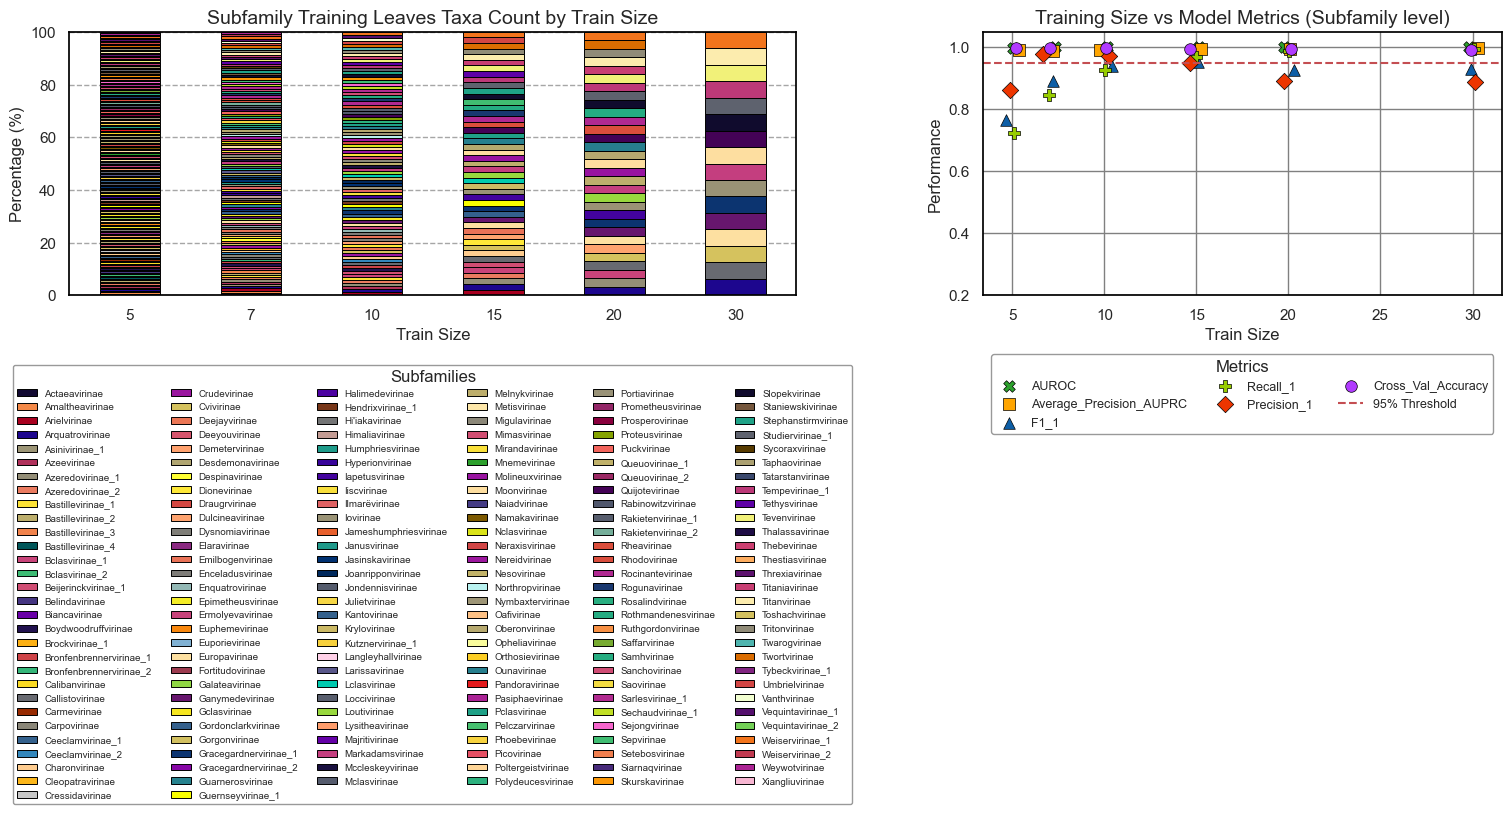

In [125]:
#bbox_to_anchor=(0.5, -2.0),bbox_to_anchor=(0.5, -0.4),
plot_training_metrics(subfamily_results, combined_palette, rank="Subfamily", output_file="../plots/subfamily_training_metrics.png",
                      bottom_spacing=0.65, num_col_legend=6, bbox_to_anchor1_y=-1.95, bbox_to_anchor2_y=-0.55
                     )

# 1.4. Genus

In [77]:
filtered_df = filter_low_count_taxa(df, rank='Genus', min_count=5)
X_train, X_test, y_train, y_test = create_train_test(filtered_df, training_matrix_T, rank='Genus')
genera_results, genera_feature_importance = train_binary_classifiers(X_train, X_test, y_train, y_test, training_matrix_T, min_taxa_count=5, rank='Genus')

Balancing all taxa to 5 instances each.
Balanced Train Shape: (725, 20289), Unique taxa: 145
Y Train Value Counts: Genus
Acanvirus           5
Kostyavirus         5
Oslovirus           5
Paclarkvirus_1      5
Pahexavirus         5
                   ..
Elveevirus          5
Epseptimavirus_1    5
Erskinevirus        5
Faithunavirus       5
Yuavirus            5
Name: count, Length: 145, dtype: int64
Y Train Training Value Counts: count
5    145
Name: count, dtype: int64


Training Genus classifiers..:   0%|                                                            | 0/145 [00:00<?, ?it/s]

Training Acanvirus vs. rest with size 5


Training Genus classifiers..:   1%|▎                                                   | 1/145 [00:05<12:06,  5.05s/it]

Training Kostyavirus vs. rest with size 5


Training Genus classifiers..:   1%|▋                                                   | 2/145 [00:09<11:25,  4.79s/it]

Training Oslovirus vs. rest with size 5


Training Genus classifiers..:   2%|█                                                   | 3/145 [00:14<11:26,  4.84s/it]

Training Paclarkvirus_1 vs. rest with size 5


Training Genus classifiers..:   3%|█▍                                                  | 4/145 [00:19<11:40,  4.97s/it]

Training Pahexavirus vs. rest with size 5


Training Genus classifiers..:   3%|█▊                                                  | 5/145 [00:25<11:52,  5.09s/it]

Training Pakpunavirus vs. rest with size 5


Training Genus classifiers..:   4%|██▏                                                 | 6/145 [00:29<11:34,  5.00s/it]

Training Paopuvirus vs. rest with size 5


Training Genus classifiers..:   5%|██▌                                                 | 7/145 [00:36<13:05,  5.69s/it]

Training Pbunavirus vs. rest with size 5


Training Genus classifiers..:   6%|██▊                                                 | 8/145 [00:42<12:58,  5.68s/it]

Training Pecentumvirus vs. rest with size 5


Training Genus classifiers..:   6%|███▏                                                | 9/145 [00:47<12:22,  5.46s/it]

Training Peduovirus vs. rest with size 5


Training Genus classifiers..:   7%|███▌                                               | 10/145 [00:53<12:21,  5.49s/it]

Training Pegunavirus vs. rest with size 5


Training Genus classifiers..:   8%|███▊                                               | 11/145 [00:58<12:08,  5.43s/it]

Training Phapecoctavirus vs. rest with size 5


Training Genus classifiers..:   8%|████▏                                              | 12/145 [01:03<11:50,  5.34s/it]

Training Phikmvvirus vs. rest with size 5


Training Genus classifiers..:   9%|████▌                                              | 13/145 [01:09<11:59,  5.45s/it]

Training Phimunavirus vs. rest with size 5


Training Genus classifiers..:  10%|████▉                                              | 14/145 [01:14<11:58,  5.49s/it]

Training Piorkowskivirus_1 vs. rest with size 5


Training Genus classifiers..:  10%|█████▎                                             | 15/145 [01:20<11:59,  5.53s/it]

Training Ponsvirus vs. rest with size 5


Training Genus classifiers..:  11%|█████▋                                             | 16/145 [01:26<11:53,  5.53s/it]

Training Przondovirus_1 vs. rest with size 5


Training Genus classifiers..:  12%|█████▉                                             | 17/145 [01:31<11:58,  5.61s/it]

Training Mydovirus vs. rest with size 5


Training Genus classifiers..:  12%|██████▎                                            | 18/145 [01:36<11:32,  5.45s/it]

Training Mudcatvirus vs. rest with size 5


Training Genus classifiers..:  13%|██████▋                                            | 19/145 [01:42<11:18,  5.38s/it]

Training Mosigvirus vs. rest with size 5


Training Genus classifiers..:  14%|███████                                            | 20/145 [01:47<11:07,  5.34s/it]

Training Liefievirus vs. rest with size 5


Training Genus classifiers..:  14%|███████▍                                           | 21/145 [01:53<11:17,  5.46s/it]

Training Krischvirus vs. rest with size 5


Training Genus classifiers..:  15%|███████▋                                           | 22/145 [01:59<11:37,  5.67s/it]

Training Kroosvirus_1 vs. rest with size 5


Training Genus classifiers..:  16%|████████                                           | 23/145 [02:05<11:44,  5.78s/it]

Training Kuravirus vs. rest with size 5


Training Genus classifiers..:  17%|████████▍                                          | 24/145 [02:11<11:38,  5.77s/it]

Training Kuttervirus_1 vs. rest with size 5


Training Genus classifiers..:  17%|████████▊                                          | 25/145 [02:16<11:25,  5.71s/it]

Training Lazarusvirus vs. rest with size 5


Training Genus classifiers..:  18%|█████████▏                                         | 26/145 [02:22<11:09,  5.62s/it]

Training Lederbergvirus vs. rest with size 5


Training Genus classifiers..:  19%|█████████▍                                         | 27/145 [02:28<11:27,  5.82s/it]

Training Likavirus vs. rest with size 5


Training Genus classifiers..:  19%|█████████▊                                         | 28/145 [02:34<11:30,  5.91s/it]

Training Montyvirus vs. rest with size 5


Training Genus classifiers..:  20%|██████████▏                                        | 29/145 [02:40<11:27,  5.93s/it]

Training Lillamyvirus vs. rest with size 5


Training Genus classifiers..:  21%|██████████▌                                        | 30/145 [02:46<11:36,  6.06s/it]

Training Limdunavirus vs. rest with size 5


Training Genus classifiers..:  21%|██████████▉                                        | 31/145 [02:52<11:33,  6.08s/it]

Training Litunavirus vs. rest with size 5


Training Genus classifiers..:  22%|███████████▎                                       | 32/145 [02:58<11:21,  6.03s/it]

Training Microwolfvirus_1 vs. rest with size 5


Training Genus classifiers..:  23%|███████████▌                                       | 33/145 [03:04<11:17,  6.05s/it]

Training Moineauvirus_1 vs. rest with size 5


Training Genus classifiers..:  23%|███████████▉                                       | 34/145 [03:11<11:28,  6.20s/it]

Training Moineauvirus_2 vs. rest with size 5


Training Genus classifiers..:  24%|████████████▎                                      | 35/145 [03:17<11:28,  6.26s/it]

Training Pseudotevenvirus vs. rest with size 5


Training Genus classifiers..:  25%|████████████▋                                      | 36/145 [03:23<10:56,  6.02s/it]

Training Rogunavirus_1 vs. rest with size 5


Training Genus classifiers..:  26%|█████████████                                      | 37/145 [03:29<10:56,  6.08s/it]

Training Rosemountvirus vs. rest with size 5


Training Genus classifiers..:  26%|█████████████▎                                     | 38/145 [03:35<10:57,  6.15s/it]

Training Vectrevirus_1 vs. rest with size 5


Training Genus classifiers..:  27%|█████████████▋                                     | 39/145 [03:42<11:10,  6.33s/it]

Training Trigintaduovirus vs. rest with size 5


Training Genus classifiers..:  28%|██████████████                                     | 40/145 [03:49<11:11,  6.40s/it]

Training Tsamsavirus vs. rest with size 5


Training Genus classifiers..:  28%|██████████████▍                                    | 41/145 [03:54<10:44,  6.20s/it]

Training Tulanevirus vs. rest with size 5


Training Genus classifiers..:  29%|██████████████▊                                    | 42/145 [04:00<10:32,  6.14s/it]

Training Tunavirus_1 vs. rest with size 5


Training Genus classifiers..:  30%|███████████████                                    | 43/145 [04:08<11:07,  6.54s/it]

Training Turbidovirus vs. rest with size 5


Training Genus classifiers..:  30%|███████████████▍                                   | 44/145 [04:16<11:41,  6.95s/it]

Training Vansinderenvirus_1 vs. rest with size 5


Training Genus classifiers..:  31%|███████████████▊                                   | 45/145 [04:24<12:10,  7.30s/it]

Training Vequintavirus_1 vs. rest with size 5


Training Genus classifiers..:  32%|████████████████▏                                  | 46/145 [04:31<11:56,  7.24s/it]

Training Traversvirus_1 vs. rest with size 5


Training Genus classifiers..:  32%|████████████████▌                                  | 47/145 [04:39<12:08,  7.43s/it]

Training Veracruzvirus_1 vs. rest with size 5


Training Genus classifiers..:  33%|████████████████▉                                  | 48/145 [04:50<13:34,  8.40s/it]

Training Vividuovirus vs. rest with size 5


Training Genus classifiers..:  34%|█████████████████▏                                 | 49/145 [04:57<12:57,  8.10s/it]

Training Warwickvirus vs. rest with size 5


Training Genus classifiers..:  34%|█████████████████▌                                 | 50/145 [05:05<12:59,  8.21s/it]

Training Webervirus_1 vs. rest with size 5


Training Genus classifiers..:  35%|█████████████████▉                                 | 51/145 [05:11<11:50,  7.56s/it]

Training Wizardvirus_1 vs. rest with size 5


Training Genus classifiers..:  36%|██████████████████▎                                | 52/145 [05:17<10:50,  7.00s/it]

Training Yangvirus vs. rest with size 5


Training Genus classifiers..:  37%|██████████████████▋                                | 53/145 [05:23<10:02,  6.55s/it]

Training Triavirus_1 vs. rest with size 5


Training Genus classifiers..:  37%|██████████████████▉                                | 54/145 [05:29<09:57,  6.56s/it]

Training Tlsvirus_1 vs. rest with size 5


Training Genus classifiers..:  38%|███████████████████▎                               | 55/145 [05:36<09:45,  6.50s/it]

Training Rosenblumvirus_1 vs. rest with size 5


Training Genus classifiers..:  39%|███████████████████▋                               | 56/145 [05:43<09:55,  6.69s/it]

Training Syrbvirus vs. rest with size 5


Training Genus classifiers..:  39%|████████████████████                               | 57/145 [05:50<09:54,  6.75s/it]

Training Samistivirus vs. rest with size 5


Training Genus classifiers..:  40%|████████████████████▍                              | 58/145 [05:55<09:17,  6.41s/it]

Training Sircambvirus vs. rest with size 5


Training Genus classifiers..:  41%|████████████████████▊                              | 59/145 [06:02<09:09,  6.39s/it]

Training Skatevirus_1 vs. rest with size 5


Training Genus classifiers..:  41%|█████████████████████                              | 60/145 [06:07<08:48,  6.21s/it]

Training Skunavirus_1 vs. rest with size 5


Training Genus classifiers..:  42%|█████████████████████▍                             | 61/145 [06:14<09:01,  6.44s/it]

Training Skunavirus_2 vs. rest with size 5


Training Genus classifiers..:  43%|█████████████████████▊                             | 62/145 [06:21<09:02,  6.53s/it]

Training Skunavirus_3 vs. rest with size 5


Training Genus classifiers..:  43%|██████████████████████▏                            | 63/145 [06:28<08:55,  6.53s/it]

Training Taipeivirus vs. rest with size 5


Training Genus classifiers..:  44%|██████████████████████▌                            | 64/145 [06:33<08:28,  6.27s/it]

Training Tigrvirus vs. rest with size 5


Training Genus classifiers..:  45%|██████████████████████▊                            | 65/145 [06:40<08:32,  6.41s/it]

Training Teetrevirus_1 vs. rest with size 5


Training Genus classifiers..:  46%|███████████████████████▏                           | 66/145 [06:47<08:27,  6.43s/it]

Training Tepukevirus vs. rest with size 5


Training Genus classifiers..:  46%|███████████████████████▌                           | 67/145 [06:52<08:03,  6.19s/it]

Training Tequatrovirus vs. rest with size 5


Training Genus classifiers..:  47%|███████████████████████▉                           | 68/145 [06:58<07:46,  6.06s/it]

Training Tequintavirus vs. rest with size 5


Training Genus classifiers..:  48%|████████████████████████▎                          | 69/145 [07:04<07:32,  5.95s/it]

Training Teseptimavirus_1 vs. rest with size 5


Training Genus classifiers..:  48%|████████████████████████▌                          | 70/145 [07:11<07:50,  6.27s/it]

Training Thalassavirus vs. rest with size 5


Training Genus classifiers..:  49%|████████████████████████▉                          | 71/145 [07:16<07:27,  6.05s/it]

Training Kratiovirus vs. rest with size 5


Training Genus classifiers..:  50%|█████████████████████████▎                         | 72/145 [07:22<07:22,  6.06s/it]

Training Korravirus_1 vs. rest with size 5


Training Genus classifiers..:  50%|█████████████████████████▋                         | 73/145 [07:30<08:01,  6.69s/it]

Training Agricanvirus vs. rest with size 5


Training Genus classifiers..:  51%|██████████████████████████                         | 74/145 [07:37<07:46,  6.57s/it]

Training Kenoshavirus vs. rest with size 5


Training Genus classifiers..:  52%|██████████████████████████▍                        | 75/145 [07:43<07:32,  6.47s/it]

Training Caeruleovirus vs. rest with size 5


Training Genus classifiers..:  52%|██████████████████████████▋                        | 76/145 [07:49<07:07,  6.20s/it]

Training Camvirus vs. rest with size 5


Training Genus classifiers..:  53%|███████████████████████████                        | 77/145 [07:55<07:04,  6.24s/it]

Training Carltongylesvirus vs. rest with size 5


Training Genus classifiers..:  54%|███████████████████████████▍                       | 78/145 [08:01<06:54,  6.19s/it]

Training Casadabanvirus vs. rest with size 5


Training Genus classifiers..:  54%|███████████████████████████▊                       | 79/145 [08:07<06:44,  6.13s/it]

Training Ceduovirus_1 vs. rest with size 5


Training Genus classifiers..:  55%|████████████████████████████▏                      | 80/145 [08:14<07:00,  6.46s/it]

Training Ceduovirus_2 vs. rest with size 5


Training Genus classifiers..:  56%|████████████████████████████▍                      | 81/145 [08:21<06:52,  6.45s/it]

Training Cequinquevirus vs. rest with size 5


Training Genus classifiers..:  57%|████████████████████████████▊                      | 82/145 [08:27<06:47,  6.46s/it]

Training Charlievirus_1 vs. rest with size 5


Training Genus classifiers..:  57%|█████████████████████████████▏                     | 83/145 [08:33<06:30,  6.30s/it]

Training Cheoctovirus_1 vs. rest with size 5


Training Genus classifiers..:  58%|█████████████████████████████▌                     | 84/145 [08:40<06:29,  6.39s/it]

Training Cheoctovirus_2 vs. rest with size 5


Training Genus classifiers..:  59%|█████████████████████████████▉                     | 85/145 [08:46<06:17,  6.29s/it]

Training Cheoctovirus_3 vs. rest with size 5


Training Genus classifiers..:  59%|██████████████████████████████▏                    | 86/145 [08:52<06:11,  6.30s/it]

Training Cheoctovirus_4 vs. rest with size 5


Training Genus classifiers..:  60%|██████████████████████████████▌                    | 87/145 [08:58<06:04,  6.28s/it]

Training Cheoctovirus_5 vs. rest with size 5


Training Genus classifiers..:  61%|██████████████████████████████▉                    | 88/145 [09:04<05:56,  6.25s/it]

Training Cheoctovirus_6 vs. rest with size 5


Training Genus classifiers..:  61%|███████████████████████████████▎                   | 89/145 [09:11<05:57,  6.38s/it]

Training Cheoctovirus_7 vs. rest with size 5


Training Genus classifiers..:  62%|███████████████████████████████▋                   | 90/145 [09:17<05:45,  6.28s/it]

Training Caelumvirus vs. rest with size 5


Training Genus classifiers..:  63%|████████████████████████████████                   | 91/145 [09:23<05:38,  6.27s/it]

Training Buchavirus_1 vs. rest with size 5


Training Genus classifiers..:  63%|████████████████████████████████▎                  | 92/145 [09:29<05:28,  6.19s/it]

Training Bruynoghevirus vs. rest with size 5


Training Genus classifiers..:  64%|████████████████████████████████▋                  | 93/145 [09:35<05:19,  6.14s/it]

Training Beenievirus_1 vs. rest with size 5


Training Genus classifiers..:  65%|█████████████████████████████████                  | 94/145 [09:41<05:11,  6.12s/it]

Training Agtrevirus vs. rest with size 5


Training Genus classifiers..:  66%|█████████████████████████████████▍                 | 95/145 [09:47<04:58,  5.98s/it]

Training Alexandravirus vs. rest with size 5


Training Genus classifiers..:  66%|█████████████████████████████████▊                 | 96/145 [09:52<04:44,  5.80s/it]

Training Anayavirus_1 vs. rest with size 5


Training Genus classifiers..:  67%|██████████████████████████████████                 | 97/145 [09:58<04:41,  5.86s/it]

Training Anayavirus_2 vs. rest with size 5


Training Genus classifiers..:  68%|██████████████████████████████████▍                | 98/145 [10:04<04:36,  5.88s/it]

Training Andromedavirus vs. rest with size 5


Training Genus classifiers..:  68%|██████████████████████████████████▊                | 99/145 [10:11<04:34,  5.98s/it]

Training Backyardiganvirus vs. rest with size 5


Training Genus classifiers..:  69%|██████████████████████████████████▍               | 100/145 [10:17<04:28,  5.97s/it]

Training Benedictvirus vs. rest with size 5


Training Genus classifiers..:  70%|██████████████████████████████████▊               | 101/145 [10:22<04:21,  5.95s/it]

Training Brussowvirus_2 vs. rest with size 5


Training Genus classifiers..:  70%|███████████████████████████████████▏              | 102/145 [10:29<04:23,  6.13s/it]

Training Berlinvirus vs. rest with size 5


Training Genus classifiers..:  71%|███████████████████████████████████▌              | 103/145 [10:36<04:28,  6.39s/it]

Training Biseptimavirus_1 vs. rest with size 5


Training Genus classifiers..:  72%|███████████████████████████████████▊              | 104/145 [10:42<04:19,  6.32s/it]

Training Bixzunavirus vs. rest with size 5


Training Genus classifiers..:  72%|████████████████████████████████████▏             | 105/145 [10:48<04:02,  6.06s/it]

Training Brizovirus vs. rest with size 5


Training Genus classifiers..:  73%|████████████████████████████████████▌             | 106/145 [10:53<03:50,  5.90s/it]

Training Bronvirus vs. rest with size 5


Training Genus classifiers..:  74%|████████████████████████████████████▉             | 107/145 [10:59<03:44,  5.92s/it]

Training Brussowvirus_1 vs. rest with size 5


Training Genus classifiers..:  74%|█████████████████████████████████████▏            | 108/145 [11:05<03:43,  6.04s/it]

Training Chivirus_1 vs. rest with size 5


Training Genus classifiers..:  75%|█████████████████████████████████████▌            | 109/145 [11:12<03:38,  6.08s/it]

Training Claudivirus vs. rest with size 5


Training Genus classifiers..:  76%|█████████████████████████████████████▉            | 110/145 [11:19<03:43,  6.37s/it]

Training Coopervirus_1 vs. rest with size 5


Training Genus classifiers..:  77%|██████████████████████████████████████▎           | 111/145 [11:25<03:31,  6.23s/it]

Training Gustavvirus vs. rest with size 5


Training Genus classifiers..:  77%|██████████████████████████████████████▌           | 112/145 [11:31<03:31,  6.39s/it]

Training Friunavirus_1 vs. rest with size 5


Training Genus classifiers..:  78%|██████████████████████████████████████▉           | 113/145 [11:38<03:24,  6.38s/it]

Training Fromanvirus_1 vs. rest with size 5


Training Genus classifiers..:  79%|███████████████████████████████████████▎          | 114/145 [11:44<03:14,  6.27s/it]

Training Gamaleyavirus_1 vs. rest with size 5


Training Genus classifiers..:  79%|███████████████████████████████████████▋          | 115/145 [11:50<03:04,  6.14s/it]

Training Gaprivervirus vs. rest with size 5


Training Genus classifiers..:  80%|████████████████████████████████████████          | 116/145 [11:55<02:53,  6.00s/it]

Training Ghunavirus_1 vs. rest with size 5


Training Genus classifiers..:  81%|████████████████████████████████████████▎         | 117/145 [12:02<02:52,  6.16s/it]

Training Gladiatorvirus vs. rest with size 5


Training Genus classifiers..:  81%|████████████████████████████████████████▋         | 118/145 [12:08<02:43,  6.05s/it]

Training Haloferacalesvirus vs. rest with size 5


Training Genus classifiers..:  82%|█████████████████████████████████████████         | 119/145 [12:14<02:38,  6.11s/it]

Training Fernvirus_1 vs. rest with size 5


Training Genus classifiers..:  83%|█████████████████████████████████████████▍        | 120/145 [12:20<02:31,  6.08s/it]

Training Ilzatvirus vs. rest with size 5


Training Genus classifiers..:  83%|█████████████████████████████████████████▋        | 121/145 [12:26<02:26,  6.11s/it]

Training Jerseyvirus_1 vs. rest with size 5


Training Genus classifiers..:  84%|██████████████████████████████████████████        | 122/145 [12:32<02:20,  6.12s/it]

Training Jiaodavirus vs. rest with size 5


Training Genus classifiers..:  85%|██████████████████████████████████████████▍       | 123/145 [12:38<02:12,  6.01s/it]

Training Justusliebigvirus vs. rest with size 5


Training Genus classifiers..:  86%|██████████████████████████████████████████▊       | 124/145 [12:44<02:04,  5.93s/it]

Training Kayfunavirus_1 vs. rest with size 5


Training Genus classifiers..:  86%|███████████████████████████████████████████       | 125/145 [12:50<02:01,  6.07s/it]

Training Kayvirus vs. rest with size 5


Training Genus classifiers..:  87%|███████████████████████████████████████████▍      | 126/145 [12:56<01:52,  5.93s/it]

Training Fishburnevirus vs. rest with size 5


Training Genus classifiers..:  88%|███████████████████████████████████████████▊      | 127/145 [13:01<01:46,  5.91s/it]

Training Feofaniavirus vs. rest with size 5


Training Genus classifiers..:  88%|████████████████████████████████████████████▏     | 128/145 [13:09<01:46,  6.28s/it]

Training Copernicusvirus_1 vs. rest with size 5


Training Genus classifiers..:  89%|████████████████████████████████████████████▍     | 129/145 [13:16<01:44,  6.53s/it]

Training Drulisvirus_2 vs. rest with size 5


Training Genus classifiers..:  90%|████████████████████████████████████████████▊     | 130/145 [13:22<01:39,  6.60s/it]

Training Coventryvirus vs. rest with size 5


Training Genus classifiers..:  90%|█████████████████████████████████████████████▏    | 131/145 [13:29<01:30,  6.44s/it]

Training Dhakavirus vs. rest with size 5


Training Genus classifiers..:  91%|█████████████████████████████████████████████▌    | 132/145 [13:34<01:18,  6.05s/it]

Training Dhillonvirus vs. rest with size 5


Training Genus classifiers..:  92%|█████████████████████████████████████████████▊    | 133/145 [13:40<01:13,  6.12s/it]

Training Dongdastvirus vs. rest with size 5


Training Genus classifiers..:  92%|██████████████████████████████████████████████▏   | 134/145 [13:46<01:05,  5.95s/it]

Training Dpdavirus vs. rest with size 5


Training Genus classifiers..:  93%|██████████████████████████████████████████████▌   | 135/145 [13:52<01:01,  6.12s/it]

Training Drulisvirus_1 vs. rest with size 5


Training Genus classifiers..:  94%|██████████████████████████████████████████████▉   | 136/145 [13:59<00:56,  6.25s/it]

Training Efquatrovirus_1 vs. rest with size 5


Training Genus classifiers..:  94%|███████████████████████████████████████████████▏  | 137/145 [14:05<00:50,  6.28s/it]

Training Felixounavirus vs. rest with size 5


Training Genus classifiers..:  95%|███████████████████████████████████████████████▌  | 138/145 [14:11<00:43,  6.17s/it]

Training Eganvirus vs. rest with size 5


Training Genus classifiers..:  96%|███████████████████████████████████████████████▉  | 139/145 [14:18<00:38,  6.35s/it]

Training Elemovirus vs. rest with size 5


Training Genus classifiers..:  97%|████████████████████████████████████████████████▎ | 140/145 [14:23<00:30,  6.20s/it]

Training Elveevirus vs. rest with size 5


Training Genus classifiers..:  97%|████████████████████████████████████████████████▌ | 141/145 [14:30<00:25,  6.35s/it]

Training Epseptimavirus_1 vs. rest with size 5


Training Genus classifiers..:  98%|████████████████████████████████████████████████▉ | 142/145 [14:36<00:18,  6.20s/it]

Training Erskinevirus vs. rest with size 5


Training Genus classifiers..:  99%|█████████████████████████████████████████████████▎| 143/145 [14:42<00:12,  6.12s/it]

Training Faithunavirus vs. rest with size 5


Training Genus classifiers..:  99%|█████████████████████████████████████████████████▋| 144/145 [14:48<00:06,  6.02s/it]

Training Yuavirus vs. rest with size 5


Training Genus classifiers..: 100%|██████████████████████████████████████████████████| 145/145 [14:54<00:00,  6.17s/it]


Balancing all taxa to 7 instances each.
Balanced Train Shape: (602, 20289), Unique taxa: 86
Y Train Value Counts: Genus
Alexandravirus      7
Paopuvirus          7
Pseudotevenvirus    7
Przondovirus_1      7
Phimunavirus        7
                   ..
Felixounavirus      7
Epseptimavirus_1    7
Eganvirus           7
Efquatrovirus_1     7
Yuavirus            7
Name: count, Length: 86, dtype: int64
Y Train Training Value Counts: count
7    86
Name: count, dtype: int64


Training Genus classifiers..:   0%|                                                             | 0/86 [00:00<?, ?it/s]

Training Alexandravirus vs. rest with size 7


Training Genus classifiers..:   1%|▌                                                    | 1/86 [00:04<06:49,  4.81s/it]

Training Paopuvirus vs. rest with size 7


Training Genus classifiers..:   2%|█▏                                                   | 2/86 [00:10<07:40,  5.48s/it]

Training Pseudotevenvirus vs. rest with size 7


Training Genus classifiers..:   3%|█▊                                                   | 3/86 [00:15<07:19,  5.30s/it]

Training Przondovirus_1 vs. rest with size 7


Training Genus classifiers..:   5%|██▍                                                  | 4/86 [00:21<07:32,  5.51s/it]

Training Phimunavirus vs. rest with size 7


Training Genus classifiers..:   6%|███                                                  | 5/86 [00:27<07:22,  5.46s/it]

Training Phikmvvirus vs. rest with size 7


Training Genus classifiers..:   7%|███▋                                                 | 6/86 [00:32<07:21,  5.52s/it]

Training Phapecoctavirus vs. rest with size 7


Training Genus classifiers..:   8%|████▎                                                | 7/86 [00:37<06:57,  5.29s/it]

Training Peduovirus vs. rest with size 7


Training Genus classifiers..:   9%|████▉                                                | 8/86 [00:43<07:04,  5.44s/it]

Training Pecentumvirus vs. rest with size 7


Training Genus classifiers..:  10%|█████▌                                               | 9/86 [00:48<06:51,  5.34s/it]

Training Pbunavirus vs. rest with size 7


Training Genus classifiers..:  12%|██████                                              | 10/86 [00:53<06:38,  5.24s/it]

Training Pakpunavirus vs. rest with size 7


Training Genus classifiers..:  13%|██████▋                                             | 11/86 [00:58<06:25,  5.15s/it]

Training Samistivirus vs. rest with size 7


Training Genus classifiers..:  14%|███████▎                                            | 12/86 [01:03<06:20,  5.15s/it]

Training Pahexavirus vs. rest with size 7


Training Genus classifiers..:  15%|███████▊                                            | 13/86 [01:08<06:22,  5.25s/it]

Training Paclarkvirus_1 vs. rest with size 7


Training Genus classifiers..:  16%|████████▍                                           | 14/86 [01:14<06:23,  5.33s/it]

Training Mudcatvirus vs. rest with size 7


Training Genus classifiers..:  17%|█████████                                           | 15/86 [01:19<06:15,  5.29s/it]

Training Mosigvirus vs. rest with size 7


Training Genus classifiers..:  19%|█████████▋                                          | 16/86 [01:25<06:16,  5.38s/it]

Training Montyvirus vs. rest with size 7


Training Genus classifiers..:  20%|██████████▎                                         | 17/86 [01:30<06:10,  5.37s/it]

Training Moineauvirus_2 vs. rest with size 7


Training Genus classifiers..:  21%|██████████▉                                         | 18/86 [01:36<06:12,  5.47s/it]

Training Moineauvirus_1 vs. rest with size 7


Training Genus classifiers..:  22%|███████████▍                                        | 19/86 [01:42<06:15,  5.61s/it]

Training Litunavirus vs. rest with size 7


Training Genus classifiers..:  23%|████████████                                        | 20/86 [01:48<06:18,  5.73s/it]

Training Rosenblumvirus_1 vs. rest with size 7


Training Genus classifiers..:  24%|████████████▋                                       | 21/86 [01:55<06:37,  6.11s/it]

Training Sircambvirus vs. rest with size 7


Training Genus classifiers..:  26%|█████████████▎                                      | 22/86 [02:01<06:25,  6.02s/it]

Training Anayavirus_1 vs. rest with size 7


Training Genus classifiers..:  27%|█████████████▉                                      | 23/86 [02:06<06:03,  5.78s/it]

Training Tulanevirus vs. rest with size 7


Training Genus classifiers..:  28%|██████████████▌                                     | 24/86 [02:11<05:47,  5.60s/it]

Training Yangvirus vs. rest with size 7


Training Genus classifiers..:  29%|███████████████                                     | 25/86 [02:18<06:04,  5.97s/it]

Training Wizardvirus_1 vs. rest with size 7


Training Genus classifiers..:  30%|███████████████▋                                    | 26/86 [02:23<05:46,  5.78s/it]

Training Webervirus_1 vs. rest with size 7


Training Genus classifiers..:  31%|████████████████▎                                   | 27/86 [02:29<05:35,  5.69s/it]

Training Warwickvirus vs. rest with size 7


Training Genus classifiers..:  33%|████████████████▉                                   | 28/86 [02:34<05:23,  5.58s/it]

Training Vividuovirus vs. rest with size 7


Training Genus classifiers..:  34%|█████████████████▌                                  | 29/86 [02:42<05:56,  6.25s/it]

Training Vectrevirus_1 vs. rest with size 7


Training Genus classifiers..:  35%|██████████████████▏                                 | 30/86 [02:49<06:02,  6.47s/it]

Training Turbidovirus vs. rest with size 7


Training Genus classifiers..:  36%|██████████████████▋                                 | 31/86 [02:55<05:46,  6.30s/it]

Training Tunavirus_1 vs. rest with size 7


Training Genus classifiers..:  37%|███████████████████▎                                | 32/86 [03:01<05:38,  6.26s/it]

Training Triavirus_1 vs. rest with size 7


Training Genus classifiers..:  38%|███████████████████▉                                | 33/86 [03:08<05:49,  6.59s/it]

Training Skunavirus_1 vs. rest with size 7


Training Genus classifiers..:  40%|████████████████████▌                               | 34/86 [03:15<05:45,  6.64s/it]

Training Tlsvirus_1 vs. rest with size 7


Training Genus classifiers..:  41%|█████████████████████▏                              | 35/86 [03:20<05:21,  6.31s/it]

Training Thalassavirus vs. rest with size 7


Training Genus classifiers..:  42%|█████████████████████▊                              | 36/86 [03:25<04:56,  5.92s/it]

Training Teseptimavirus_1 vs. rest with size 7


Training Genus classifiers..:  43%|██████████████████████▎                             | 37/86 [03:32<04:52,  5.97s/it]

Training Tequintavirus vs. rest with size 7


Training Genus classifiers..:  44%|██████████████████████▉                             | 38/86 [03:37<04:34,  5.72s/it]

Training Tequatrovirus vs. rest with size 7


Training Genus classifiers..:  45%|███████████████████████▌                            | 39/86 [03:42<04:24,  5.62s/it]

Training Teetrevirus_1 vs. rest with size 7


Training Genus classifiers..:  47%|████████████████████████▏                           | 40/86 [03:48<04:28,  5.83s/it]

Training Skunavirus_3 vs. rest with size 7


Training Genus classifiers..:  48%|████████████████████████▊                           | 41/86 [03:54<04:23,  5.85s/it]

Training Skunavirus_2 vs. rest with size 7


Training Genus classifiers..:  49%|█████████████████████████▍                          | 42/86 [04:00<04:20,  5.93s/it]

Training Likavirus vs. rest with size 7


Training Genus classifiers..:  50%|██████████████████████████                          | 43/86 [04:06<04:10,  5.83s/it]

Training Lazarusvirus vs. rest with size 7


Training Genus classifiers..:  51%|██████████████████████████▌                         | 44/86 [04:12<04:10,  5.96s/it]

Training Kuttervirus_1 vs. rest with size 7


Training Genus classifiers..:  52%|███████████████████████████▏                        | 45/86 [04:19<04:18,  6.30s/it]

Training Ceduovirus_1 vs. rest with size 7


Training Genus classifiers..:  53%|███████████████████████████▊                        | 46/86 [04:27<04:25,  6.64s/it]

Training Claudivirus vs. rest with size 7


Training Genus classifiers..:  55%|████████████████████████████▍                       | 47/86 [04:34<04:30,  6.94s/it]

Training Chivirus_1 vs. rest with size 7


Training Genus classifiers..:  56%|█████████████████████████████                       | 48/86 [04:42<04:25,  6.98s/it]

Training Cheoctovirus_5 vs. rest with size 7


Training Genus classifiers..:  57%|█████████████████████████████▋                      | 49/86 [04:49<04:22,  7.10s/it]

Training Cheoctovirus_4 vs. rest with size 7


Training Genus classifiers..:  58%|██████████████████████████████▏                     | 50/86 [04:55<04:04,  6.78s/it]

Training Cheoctovirus_3 vs. rest with size 7


Training Genus classifiers..:  59%|██████████████████████████████▊                     | 51/86 [05:01<03:45,  6.44s/it]

Training Cheoctovirus_2 vs. rest with size 7


Training Genus classifiers..:  60%|███████████████████████████████▍                    | 52/86 [05:06<03:28,  6.12s/it]

Training Cheoctovirus_1 vs. rest with size 7


Training Genus classifiers..:  62%|████████████████████████████████                    | 53/86 [05:11<03:15,  5.93s/it]

Training Charlievirus_1 vs. rest with size 7


Training Genus classifiers..:  63%|████████████████████████████████▋                   | 54/86 [05:17<03:07,  5.85s/it]

Training Casadabanvirus vs. rest with size 7


Training Genus classifiers..:  64%|█████████████████████████████████▎                  | 55/86 [05:22<02:55,  5.68s/it]

Training Kuravirus vs. rest with size 7


Training Genus classifiers..:  65%|█████████████████████████████████▊                  | 56/86 [05:27<02:44,  5.50s/it]

Training Caelumvirus vs. rest with size 7


Training Genus classifiers..:  66%|██████████████████████████████████▍                 | 57/86 [05:33<02:41,  5.56s/it]

Training Brussowvirus_2 vs. rest with size 7


Training Genus classifiers..:  67%|███████████████████████████████████                 | 58/86 [05:39<02:40,  5.72s/it]

Training Brussowvirus_1 vs. rest with size 7


Training Genus classifiers..:  69%|███████████████████████████████████▋                | 59/86 [05:45<02:36,  5.79s/it]

Training Bixzunavirus vs. rest with size 7


Training Genus classifiers..:  70%|████████████████████████████████████▎               | 60/86 [05:50<02:23,  5.54s/it]

Training Berlinvirus vs. rest with size 7


Training Genus classifiers..:  71%|████████████████████████████████████▉               | 61/86 [05:56<02:23,  5.74s/it]

Training Benedictvirus vs. rest with size 7


Training Genus classifiers..:  72%|█████████████████████████████████████▍              | 62/86 [06:02<02:15,  5.65s/it]

Training Backyardiganvirus vs. rest with size 7


Training Genus classifiers..:  73%|██████████████████████████████████████              | 63/86 [06:07<02:07,  5.54s/it]

Training Anayavirus_2 vs. rest with size 7


Training Genus classifiers..:  74%|██████████████████████████████████████▋             | 64/86 [06:13<02:00,  5.50s/it]

Training Coopervirus_1 vs. rest with size 7


Training Genus classifiers..:  76%|███████████████████████████████████████▎            | 65/86 [06:18<01:54,  5.46s/it]

Training Copernicusvirus_1 vs. rest with size 7


Training Genus classifiers..:  77%|███████████████████████████████████████▉            | 66/86 [06:24<01:54,  5.74s/it]

Training Dhakavirus vs. rest with size 7


Training Genus classifiers..:  78%|████████████████████████████████████████▌           | 67/86 [06:29<01:45,  5.57s/it]

Training Drulisvirus_1 vs. rest with size 7


Training Genus classifiers..:  79%|█████████████████████████████████████████           | 68/86 [06:35<01:41,  5.63s/it]

Training Kratiovirus vs. rest with size 7


Training Genus classifiers..:  80%|█████████████████████████████████████████▋          | 69/86 [06:41<01:35,  5.63s/it]

Training Kostyavirus vs. rest with size 7


Training Genus classifiers..:  81%|██████████████████████████████████████████▎         | 70/86 [06:46<01:27,  5.47s/it]

Training Korravirus_1 vs. rest with size 7


Training Genus classifiers..:  83%|██████████████████████████████████████████▉         | 71/86 [06:51<01:20,  5.35s/it]

Training Kayvirus vs. rest with size 7


Training Genus classifiers..:  84%|███████████████████████████████████████████▌        | 72/86 [06:56<01:13,  5.22s/it]

Training Kayfunavirus_1 vs. rest with size 7


Training Genus classifiers..:  85%|████████████████████████████████████████████▏       | 73/86 [07:01<01:08,  5.28s/it]

Training Jerseyvirus_1 vs. rest with size 7


Training Genus classifiers..:  86%|████████████████████████████████████████████▋       | 74/86 [07:06<01:02,  5.18s/it]

Training Gladiatorvirus vs. rest with size 7


Training Genus classifiers..:  87%|█████████████████████████████████████████████▎      | 75/86 [07:11<00:55,  5.01s/it]

Training Ghunavirus_1 vs. rest with size 7


Training Genus classifiers..:  88%|█████████████████████████████████████████████▉      | 76/86 [07:16<00:51,  5.12s/it]

Training Gamaleyavirus_1 vs. rest with size 7


Training Genus classifiers..:  90%|██████████████████████████████████████████████▌     | 77/86 [07:21<00:45,  5.05s/it]

Training Fromanvirus_1 vs. rest with size 7


Training Genus classifiers..:  91%|███████████████████████████████████████████████▏    | 78/86 [07:26<00:39,  4.92s/it]

Training Friunavirus_1 vs. rest with size 7


Training Genus classifiers..:  92%|███████████████████████████████████████████████▊    | 79/86 [07:31<00:34,  4.97s/it]

Training Fishburnevirus vs. rest with size 7


Training Genus classifiers..:  93%|████████████████████████████████████████████████▎   | 80/86 [07:36<00:29,  4.99s/it]

Training Fernvirus_1 vs. rest with size 7


Training Genus classifiers..:  94%|████████████████████████████████████████████████▉   | 81/86 [07:41<00:25,  5.05s/it]

Training Felixounavirus vs. rest with size 7


Training Genus classifiers..:  95%|█████████████████████████████████████████████████▌  | 82/86 [07:46<00:19,  4.97s/it]

Training Epseptimavirus_1 vs. rest with size 7


Training Genus classifiers..:  97%|██████████████████████████████████████████████████▏ | 83/86 [07:51<00:14,  4.87s/it]

Training Eganvirus vs. rest with size 7


Training Genus classifiers..:  98%|██████████████████████████████████████████████████▊ | 84/86 [07:56<00:09,  4.99s/it]

Training Efquatrovirus_1 vs. rest with size 7


Training Genus classifiers..:  99%|███████████████████████████████████████████████████▍| 85/86 [08:01<00:05,  5.14s/it]

Training Yuavirus vs. rest with size 7


Training Genus classifiers..: 100%|████████████████████████████████████████████████████| 86/86 [08:06<00:00,  5.66s/it]


Balancing all taxa to 10 instances each.
Balanced Train Shape: (540, 20289), Unique taxa: 54
Y Train Value Counts: Genus
Alexandravirus       10
Skunavirus_2         10
Moineauvirus_2       10
Mosigvirus           10
Pahexavirus          10
Pbunavirus           10
Pecentumvirus        10
Peduovirus           10
Phapecoctavirus      10
Phikmvvirus          10
Przondovirus_1       10
Rosenblumvirus_1     10
Skunavirus_1         10
Teetrevirus_1        10
Anayavirus_1         10
Tequatrovirus        10
Tequintavirus        10
Teseptimavirus_1     10
Thalassavirus        10
Triavirus_1          10
Tunavirus_1          10
Turbidovirus         10
Vectrevirus_1        10
Vividuovirus         10
Warwickvirus         10
Webervirus_1         10
Moineauvirus_1       10
Likavirus            10
Kuttervirus_1        10
Kuravirus            10
Anayavirus_2         10
Backyardiganvirus    10
Benedictvirus        10
Berlinvirus          10
Bixzunavirus         10
Brussowvirus_1       10
Casadabanvirus 

Training Genus classifiers..:   0%|                                                             | 0/54 [00:00<?, ?it/s]

Training Alexandravirus vs. rest with size 10


Training Genus classifiers..:   2%|▉                                                    | 1/54 [00:04<03:51,  4.37s/it]

Training Skunavirus_2 vs. rest with size 10


Training Genus classifiers..:   4%|█▉                                                   | 2/54 [00:09<04:18,  4.97s/it]

Training Moineauvirus_2 vs. rest with size 10


Training Genus classifiers..:   6%|██▉                                                  | 3/54 [00:15<04:28,  5.27s/it]

Training Mosigvirus vs. rest with size 10


Training Genus classifiers..:   7%|███▉                                                 | 4/54 [00:19<04:06,  4.94s/it]

Training Pahexavirus vs. rest with size 10


Training Genus classifiers..:   9%|████▉                                                | 5/54 [00:24<04:04,  4.99s/it]

Training Pbunavirus vs. rest with size 10


Training Genus classifiers..:  11%|█████▉                                               | 6/54 [00:29<03:51,  4.82s/it]

Training Pecentumvirus vs. rest with size 10


Training Genus classifiers..:  13%|██████▊                                              | 7/54 [00:34<03:50,  4.91s/it]

Training Peduovirus vs. rest with size 10


Training Genus classifiers..:  15%|███████▊                                             | 8/54 [00:39<03:47,  4.94s/it]

Training Phapecoctavirus vs. rest with size 10


Training Genus classifiers..:  17%|████████▊                                            | 9/54 [00:43<03:31,  4.70s/it]

Training Phikmvvirus vs. rest with size 10


Training Genus classifiers..:  19%|█████████▋                                          | 10/54 [00:48<03:34,  4.88s/it]

Training Przondovirus_1 vs. rest with size 10


Training Genus classifiers..:  20%|██████████▌                                         | 11/54 [00:55<03:45,  5.24s/it]

Training Rosenblumvirus_1 vs. rest with size 10


Training Genus classifiers..:  22%|███████████▌                                        | 12/54 [01:01<03:50,  5.48s/it]

Training Skunavirus_1 vs. rest with size 10


Training Genus classifiers..:  24%|████████████▌                                       | 13/54 [01:06<03:47,  5.55s/it]

Training Teetrevirus_1 vs. rest with size 10


Training Genus classifiers..:  26%|█████████████▍                                      | 14/54 [01:13<03:57,  5.93s/it]

Training Anayavirus_1 vs. rest with size 10


Training Genus classifiers..:  28%|██████████████▍                                     | 15/54 [01:19<03:51,  5.93s/it]

Training Tequatrovirus vs. rest with size 10


Training Genus classifiers..:  30%|███████████████▍                                    | 16/54 [01:24<03:31,  5.56s/it]

Training Tequintavirus vs. rest with size 10


Training Genus classifiers..:  31%|████████████████▎                                   | 17/54 [01:29<03:26,  5.57s/it]

Training Teseptimavirus_1 vs. rest with size 10


Training Genus classifiers..:  33%|█████████████████▎                                  | 18/54 [01:37<03:43,  6.22s/it]

Training Thalassavirus vs. rest with size 10


Training Genus classifiers..:  35%|██████████████████▎                                 | 19/54 [01:44<03:46,  6.47s/it]

Training Triavirus_1 vs. rest with size 10


Training Genus classifiers..:  37%|███████████████████▎                                | 20/54 [01:51<03:44,  6.61s/it]

Training Tunavirus_1 vs. rest with size 10


Training Genus classifiers..:  39%|████████████████████▏                               | 21/54 [01:57<03:32,  6.43s/it]

Training Turbidovirus vs. rest with size 10


Training Genus classifiers..:  41%|█████████████████████▏                              | 22/54 [02:02<03:14,  6.08s/it]

Training Vectrevirus_1 vs. rest with size 10


Training Genus classifiers..:  43%|██████████████████████▏                             | 23/54 [02:08<03:05,  5.97s/it]

Training Vividuovirus vs. rest with size 10


Training Genus classifiers..:  44%|███████████████████████                             | 24/54 [02:13<02:50,  5.69s/it]

Training Warwickvirus vs. rest with size 10


Training Genus classifiers..:  46%|████████████████████████                            | 25/54 [02:19<02:45,  5.70s/it]

Training Webervirus_1 vs. rest with size 10


Training Genus classifiers..:  48%|█████████████████████████                           | 26/54 [02:24<02:38,  5.66s/it]

Training Moineauvirus_1 vs. rest with size 10


Training Genus classifiers..:  50%|██████████████████████████                          | 27/54 [02:30<02:33,  5.68s/it]

Training Likavirus vs. rest with size 10


Training Genus classifiers..:  52%|██████████████████████████▉                         | 28/54 [02:35<02:23,  5.53s/it]

Training Kuttervirus_1 vs. rest with size 10


Training Genus classifiers..:  54%|███████████████████████████▉                        | 29/54 [02:41<02:16,  5.46s/it]

Training Kuravirus vs. rest with size 10


Training Genus classifiers..:  56%|████████████████████████████▉                       | 30/54 [02:45<02:07,  5.31s/it]

Training Anayavirus_2 vs. rest with size 10


Training Genus classifiers..:  57%|█████████████████████████████▊                      | 31/54 [02:51<02:03,  5.35s/it]

Training Backyardiganvirus vs. rest with size 10


Training Genus classifiers..:  59%|██████████████████████████████▊                     | 32/54 [02:56<01:57,  5.34s/it]

Training Benedictvirus vs. rest with size 10


Training Genus classifiers..:  61%|███████████████████████████████▊                    | 33/54 [03:01<01:51,  5.30s/it]

Training Berlinvirus vs. rest with size 10


Training Genus classifiers..:  63%|████████████████████████████████▋                   | 34/54 [03:08<01:54,  5.74s/it]

Training Bixzunavirus vs. rest with size 10


Training Genus classifiers..:  65%|█████████████████████████████████▋                  | 35/54 [03:13<01:44,  5.52s/it]

Training Brussowvirus_1 vs. rest with size 10


Training Genus classifiers..:  67%|██████████████████████████████████▋                 | 36/54 [03:19<01:39,  5.53s/it]

Training Casadabanvirus vs. rest with size 10


Training Genus classifiers..:  69%|███████████████████████████████████▋                | 37/54 [03:24<01:32,  5.45s/it]

Training Ceduovirus_1 vs. rest with size 10


Training Genus classifiers..:  70%|████████████████████████████████████▌               | 38/54 [03:30<01:27,  5.48s/it]

Training Cheoctovirus_1 vs. rest with size 10


Training Genus classifiers..:  72%|█████████████████████████████████████▌              | 39/54 [03:35<01:22,  5.48s/it]

Training Cheoctovirus_2 vs. rest with size 10


Training Genus classifiers..:  74%|██████████████████████████████████████▌             | 40/54 [03:40<01:16,  5.44s/it]

Training Chivirus_1 vs. rest with size 10


Training Genus classifiers..:  76%|███████████████████████████████████████▍            | 41/54 [03:45<01:09,  5.32s/it]

Training Copernicusvirus_1 vs. rest with size 10


Training Genus classifiers..:  78%|████████████████████████████████████████▍           | 42/54 [03:51<01:06,  5.51s/it]

Training Drulisvirus_1 vs. rest with size 10


Training Genus classifiers..:  80%|█████████████████████████████████████████▍          | 43/54 [03:57<01:00,  5.51s/it]

Training Epseptimavirus_1 vs. rest with size 10


Training Genus classifiers..:  81%|██████████████████████████████████████████▎         | 44/54 [04:02<00:53,  5.34s/it]

Training Felixounavirus vs. rest with size 10


Training Genus classifiers..:  83%|███████████████████████████████████████████▎        | 45/54 [04:07<00:47,  5.29s/it]

Training Fernvirus_1 vs. rest with size 10


Training Genus classifiers..:  85%|████████████████████████████████████████████▎       | 46/54 [04:12<00:42,  5.26s/it]

Training Fishburnevirus vs. rest with size 10


Training Genus classifiers..:  87%|█████████████████████████████████████████████▎      | 47/54 [04:17<00:36,  5.23s/it]

Training Friunavirus_1 vs. rest with size 10


Training Genus classifiers..:  89%|██████████████████████████████████████████████▏     | 48/54 [04:23<00:32,  5.41s/it]

Training Fromanvirus_1 vs. rest with size 10


Training Genus classifiers..:  91%|███████████████████████████████████████████████▏    | 49/54 [04:29<00:27,  5.44s/it]

Training Ghunavirus_1 vs. rest with size 10


Training Genus classifiers..:  93%|████████████████████████████████████████████████▏   | 50/54 [04:36<00:23,  5.85s/it]

Training Kayfunavirus_1 vs. rest with size 10


Training Genus classifiers..:  94%|█████████████████████████████████████████████████   | 51/54 [04:42<00:17,  5.95s/it]

Training Kayvirus vs. rest with size 10


Training Genus classifiers..:  96%|██████████████████████████████████████████████████  | 52/54 [04:46<00:11,  5.58s/it]

Training Korravirus_1 vs. rest with size 10


Training Genus classifiers..:  98%|███████████████████████████████████████████████████ | 53/54 [04:52<00:05,  5.54s/it]

Training Wizardvirus_1 vs. rest with size 10


Training Genus classifiers..: 100%|████████████████████████████████████████████████████| 54/54 [04:57<00:00,  5.51s/it]


Balancing all taxa to 15 instances each.
Balanced Train Shape: (360, 20289), Unique taxa: 24
Y Train Value Counts: Genus
Berlinvirus         15
Casadabanvirus      15
Warwickvirus        15
Vividuovirus        15
Tequintavirus       15
Tequatrovirus       15
Skunavirus_2        15
Skunavirus_1        15
Przondovirus_1      15
Peduovirus          15
Pbunavirus          15
Pahexavirus         15
Moineauvirus_2      15
Moineauvirus_1      15
Kuttervirus_1       15
Korravirus_1        15
Kayvirus            15
Fromanvirus_1       15
Friunavirus_1       15
Felixounavirus      15
Epseptimavirus_1    15
Cheoctovirus_1      15
Ceduovirus_1        15
Webervirus_1        15
Name: count, dtype: int64
Y Train Training Value Counts: count
15    24
Name: count, dtype: int64


Training Genus classifiers..:   0%|                                                             | 0/24 [00:00<?, ?it/s]

Training Berlinvirus vs. rest with size 15


Training Genus classifiers..:   4%|██▏                                                  | 1/24 [00:05<01:55,  5.02s/it]

Training Casadabanvirus vs. rest with size 15


Training Genus classifiers..:   8%|████▍                                                | 2/24 [00:09<01:40,  4.56s/it]

Training Warwickvirus vs. rest with size 15


Training Genus classifiers..:  12%|██████▋                                              | 3/24 [00:13<01:31,  4.38s/it]

Training Vividuovirus vs. rest with size 15


Training Genus classifiers..:  17%|████████▊                                            | 4/24 [00:17<01:25,  4.25s/it]

Training Tequintavirus vs. rest with size 15


Training Genus classifiers..:  21%|███████████                                          | 5/24 [00:21<01:21,  4.31s/it]

Training Tequatrovirus vs. rest with size 15


Training Genus classifiers..:  25%|█████████████▎                                       | 6/24 [00:26<01:16,  4.25s/it]

Training Skunavirus_2 vs. rest with size 15


Training Genus classifiers..:  29%|███████████████▍                                     | 7/24 [00:30<01:16,  4.48s/it]

Training Skunavirus_1 vs. rest with size 15


Training Genus classifiers..:  33%|█████████████████▋                                   | 8/24 [00:36<01:15,  4.72s/it]

Training Przondovirus_1 vs. rest with size 15


Training Genus classifiers..:  38%|███████████████████▉                                 | 9/24 [00:41<01:12,  4.82s/it]

Training Peduovirus vs. rest with size 15


Training Genus classifiers..:  42%|█████████████████████▋                              | 10/24 [00:45<01:04,  4.64s/it]

Training Pbunavirus vs. rest with size 15


Training Genus classifiers..:  46%|███████████████████████▊                            | 11/24 [00:49<00:57,  4.45s/it]

Training Pahexavirus vs. rest with size 15


Training Genus classifiers..:  50%|██████████████████████████                          | 12/24 [00:53<00:53,  4.44s/it]

Training Moineauvirus_2 vs. rest with size 15


Training Genus classifiers..:  54%|████████████████████████████▏                       | 13/24 [00:58<00:49,  4.52s/it]

Training Moineauvirus_1 vs. rest with size 15


Training Genus classifiers..:  58%|██████████████████████████████▎                     | 14/24 [01:03<00:46,  4.61s/it]

Training Kuttervirus_1 vs. rest with size 15


Training Genus classifiers..:  62%|████████████████████████████████▌                   | 15/24 [01:07<00:39,  4.42s/it]

Training Korravirus_1 vs. rest with size 15


Training Genus classifiers..:  67%|██████████████████████████████████▋                 | 16/24 [01:11<00:35,  4.41s/it]

Training Kayvirus vs. rest with size 15


Training Genus classifiers..:  71%|████████████████████████████████████▊               | 17/24 [01:16<00:31,  4.45s/it]

Training Fromanvirus_1 vs. rest with size 15


Training Genus classifiers..:  75%|███████████████████████████████████████             | 18/24 [01:20<00:26,  4.48s/it]

Training Friunavirus_1 vs. rest with size 15


Training Genus classifiers..:  79%|█████████████████████████████████████████▏          | 19/24 [01:25<00:22,  4.50s/it]

Training Felixounavirus vs. rest with size 15


Training Genus classifiers..:  83%|███████████████████████████████████████████▎        | 20/24 [01:29<00:17,  4.40s/it]

Training Epseptimavirus_1 vs. rest with size 15


Training Genus classifiers..:  88%|█████████████████████████████████████████████▌      | 21/24 [01:33<00:13,  4.36s/it]

Training Cheoctovirus_1 vs. rest with size 15


Training Genus classifiers..:  92%|███████████████████████████████████████████████▋    | 22/24 [01:38<00:08,  4.31s/it]

Training Ceduovirus_1 vs. rest with size 15


Training Genus classifiers..:  96%|█████████████████████████████████████████████████▊  | 23/24 [01:42<00:04,  4.42s/it]

Training Webervirus_1 vs. rest with size 15


Training Genus classifiers..: 100%|████████████████████████████████████████████████████| 24/24 [01:46<00:00,  4.45s/it]


Balancing all taxa to 20 instances each.
Balanced Train Shape: (280, 20289), Unique taxa: 14
Y Train Value Counts: Genus
Epseptimavirus_1    20
Kayvirus            20
Kuttervirus_1       20
Moineauvirus_1      20
Moineauvirus_2      20
Pahexavirus         20
Pbunavirus          20
Peduovirus          20
Przondovirus_1      20
Skunavirus_1        20
Skunavirus_2        20
Tequatrovirus       20
Tequintavirus       20
Webervirus_1        20
Name: count, dtype: int64
Y Train Training Value Counts: count
20    14
Name: count, dtype: int64


Training Genus classifiers..:   0%|                                                             | 0/14 [00:00<?, ?it/s]

Training Epseptimavirus_1 vs. rest with size 20


Training Genus classifiers..:   7%|███▊                                                 | 1/14 [00:03<00:50,  3.91s/it]

Training Kayvirus vs. rest with size 20


Training Genus classifiers..:  14%|███████▌                                             | 2/14 [00:07<00:46,  3.87s/it]

Training Kuttervirus_1 vs. rest with size 20


Training Genus classifiers..:  21%|███████████▎                                         | 3/14 [00:11<00:40,  3.68s/it]

Training Moineauvirus_1 vs. rest with size 20


Training Genus classifiers..:  29%|███████████████▏                                     | 4/14 [00:15<00:40,  4.02s/it]

Training Moineauvirus_2 vs. rest with size 20


Training Genus classifiers..:  36%|██████████████████▉                                  | 5/14 [00:20<00:37,  4.15s/it]

Training Pahexavirus vs. rest with size 20


Training Genus classifiers..:  43%|██████████████████████▋                              | 6/14 [00:24<00:32,  4.10s/it]

Training Pbunavirus vs. rest with size 20


Training Genus classifiers..:  50%|██████████████████████████▌                          | 7/14 [00:27<00:27,  3.94s/it]

Training Peduovirus vs. rest with size 20


Training Genus classifiers..:  57%|██████████████████████████████▎                      | 8/14 [00:31<00:23,  3.85s/it]

Training Przondovirus_1 vs. rest with size 20


Training Genus classifiers..:  64%|██████████████████████████████████                   | 9/14 [00:35<00:19,  3.84s/it]

Training Skunavirus_1 vs. rest with size 20


Training Genus classifiers..:  71%|█████████████████████████████████████▏              | 10/14 [00:39<00:16,  4.13s/it]

Training Skunavirus_2 vs. rest with size 20


Training Genus classifiers..:  79%|████████████████████████████████████████▊           | 11/14 [00:45<00:13,  4.47s/it]

Training Tequatrovirus vs. rest with size 20


Training Genus classifiers..:  86%|████████████████████████████████████████████▌       | 12/14 [00:49<00:08,  4.32s/it]

Training Tequintavirus vs. rest with size 20


Training Genus classifiers..:  93%|████████████████████████████████████████████████▎   | 13/14 [00:53<00:04,  4.42s/it]

Training Webervirus_1 vs. rest with size 20


Training Genus classifiers..: 100%|████████████████████████████████████████████████████| 14/14 [00:57<00:00,  4.11s/it]


Balancing all taxa to 30 instances each.
Balanced Train Shape: (150, 20289), Unique taxa: 5
Y Train Value Counts: Genus
Kuttervirus_1     30
Moineauvirus_1    30
Pahexavirus       30
Skunavirus_1      30
Tequatrovirus     30
Name: count, dtype: int64
Y Train Training Value Counts: count
30    5
Name: count, dtype: int64


Training Genus classifiers..:   0%|                                                              | 0/5 [00:00<?, ?it/s]

Training Kuttervirus_1 vs. rest with size 30


Training Genus classifiers..:  20%|██████████▊                                           | 1/5 [00:02<00:11,  2.91s/it]

Training Moineauvirus_1 vs. rest with size 30


Training Genus classifiers..:  40%|█████████████████████▌                                | 2/5 [00:05<00:08,  3.00s/it]

Training Pahexavirus vs. rest with size 30


Training Genus classifiers..:  60%|████████████████████████████████▍                     | 3/5 [00:09<00:06,  3.12s/it]

Training Skunavirus_1 vs. rest with size 30


Training Genus classifiers..:  80%|███████████████████████████████████████████▏          | 4/5 [00:12<00:03,  3.08s/it]

Training Tequatrovirus vs. rest with size 30


Training Genus classifiers..: 100%|██████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.03s/it]


Models saved and results stored in classification_models_Genus_train_sizes.csv


In [62]:
genera_results = pd.read_csv('../data/classifier_performance/classification_models_Genus_train_sizes.csv')
genera_feature_importance = pd.read_csv('../data/classifier_performance/feature_importances_Genus_train_sizes.csv')

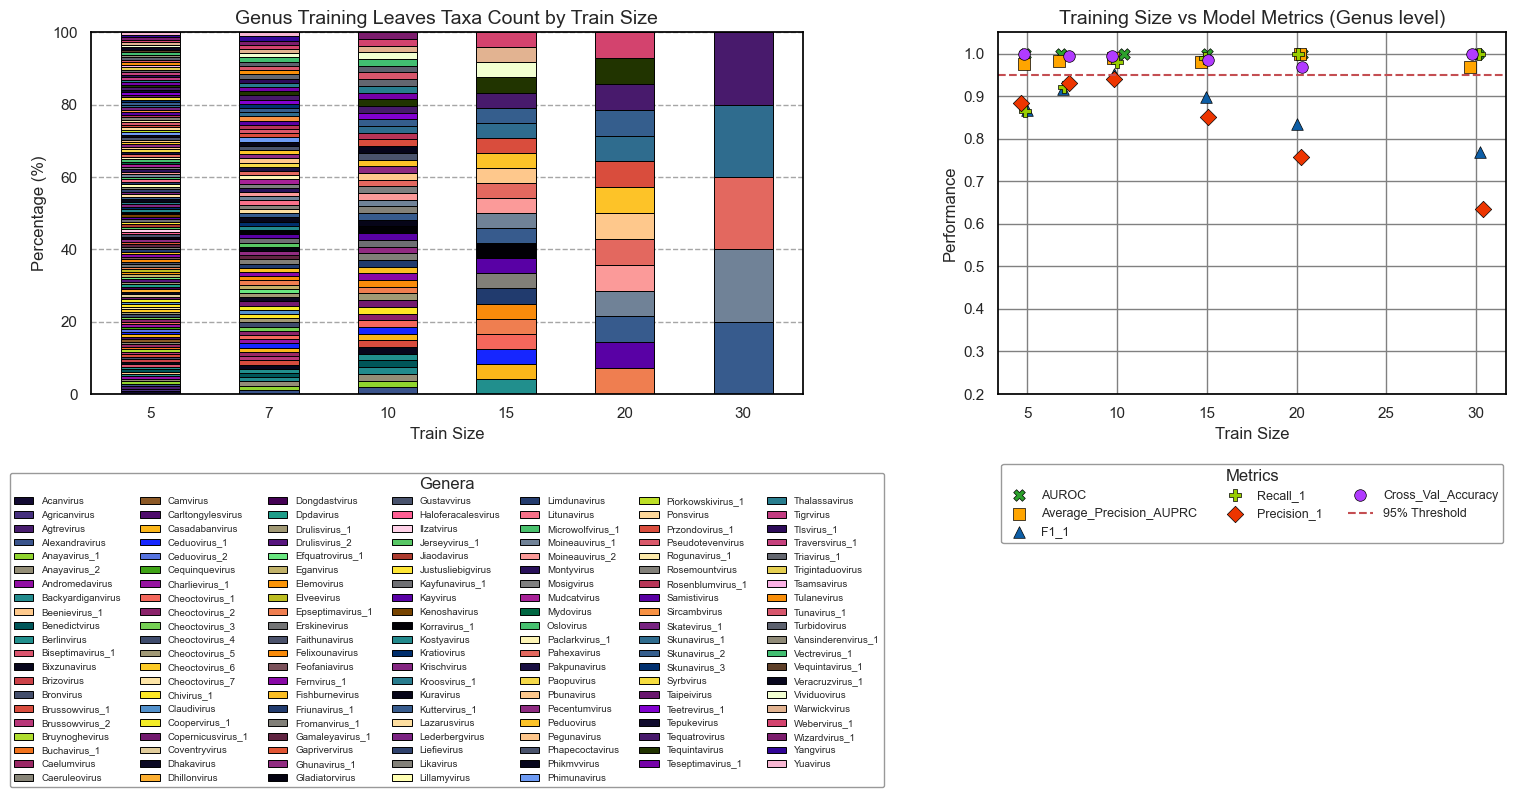

In [103]:
plot_training_metrics(genera_results, combined_palette, rank="Genus", output_file="../plots/genus_training_metrics.png",
                      bottom_spacing=0.6, num_col_legend=7, bbox_to_anchor1_y=-1.1, bbox_to_anchor2_y=-0.43
                     )

# 1.5. Combine into multi-panel plot..

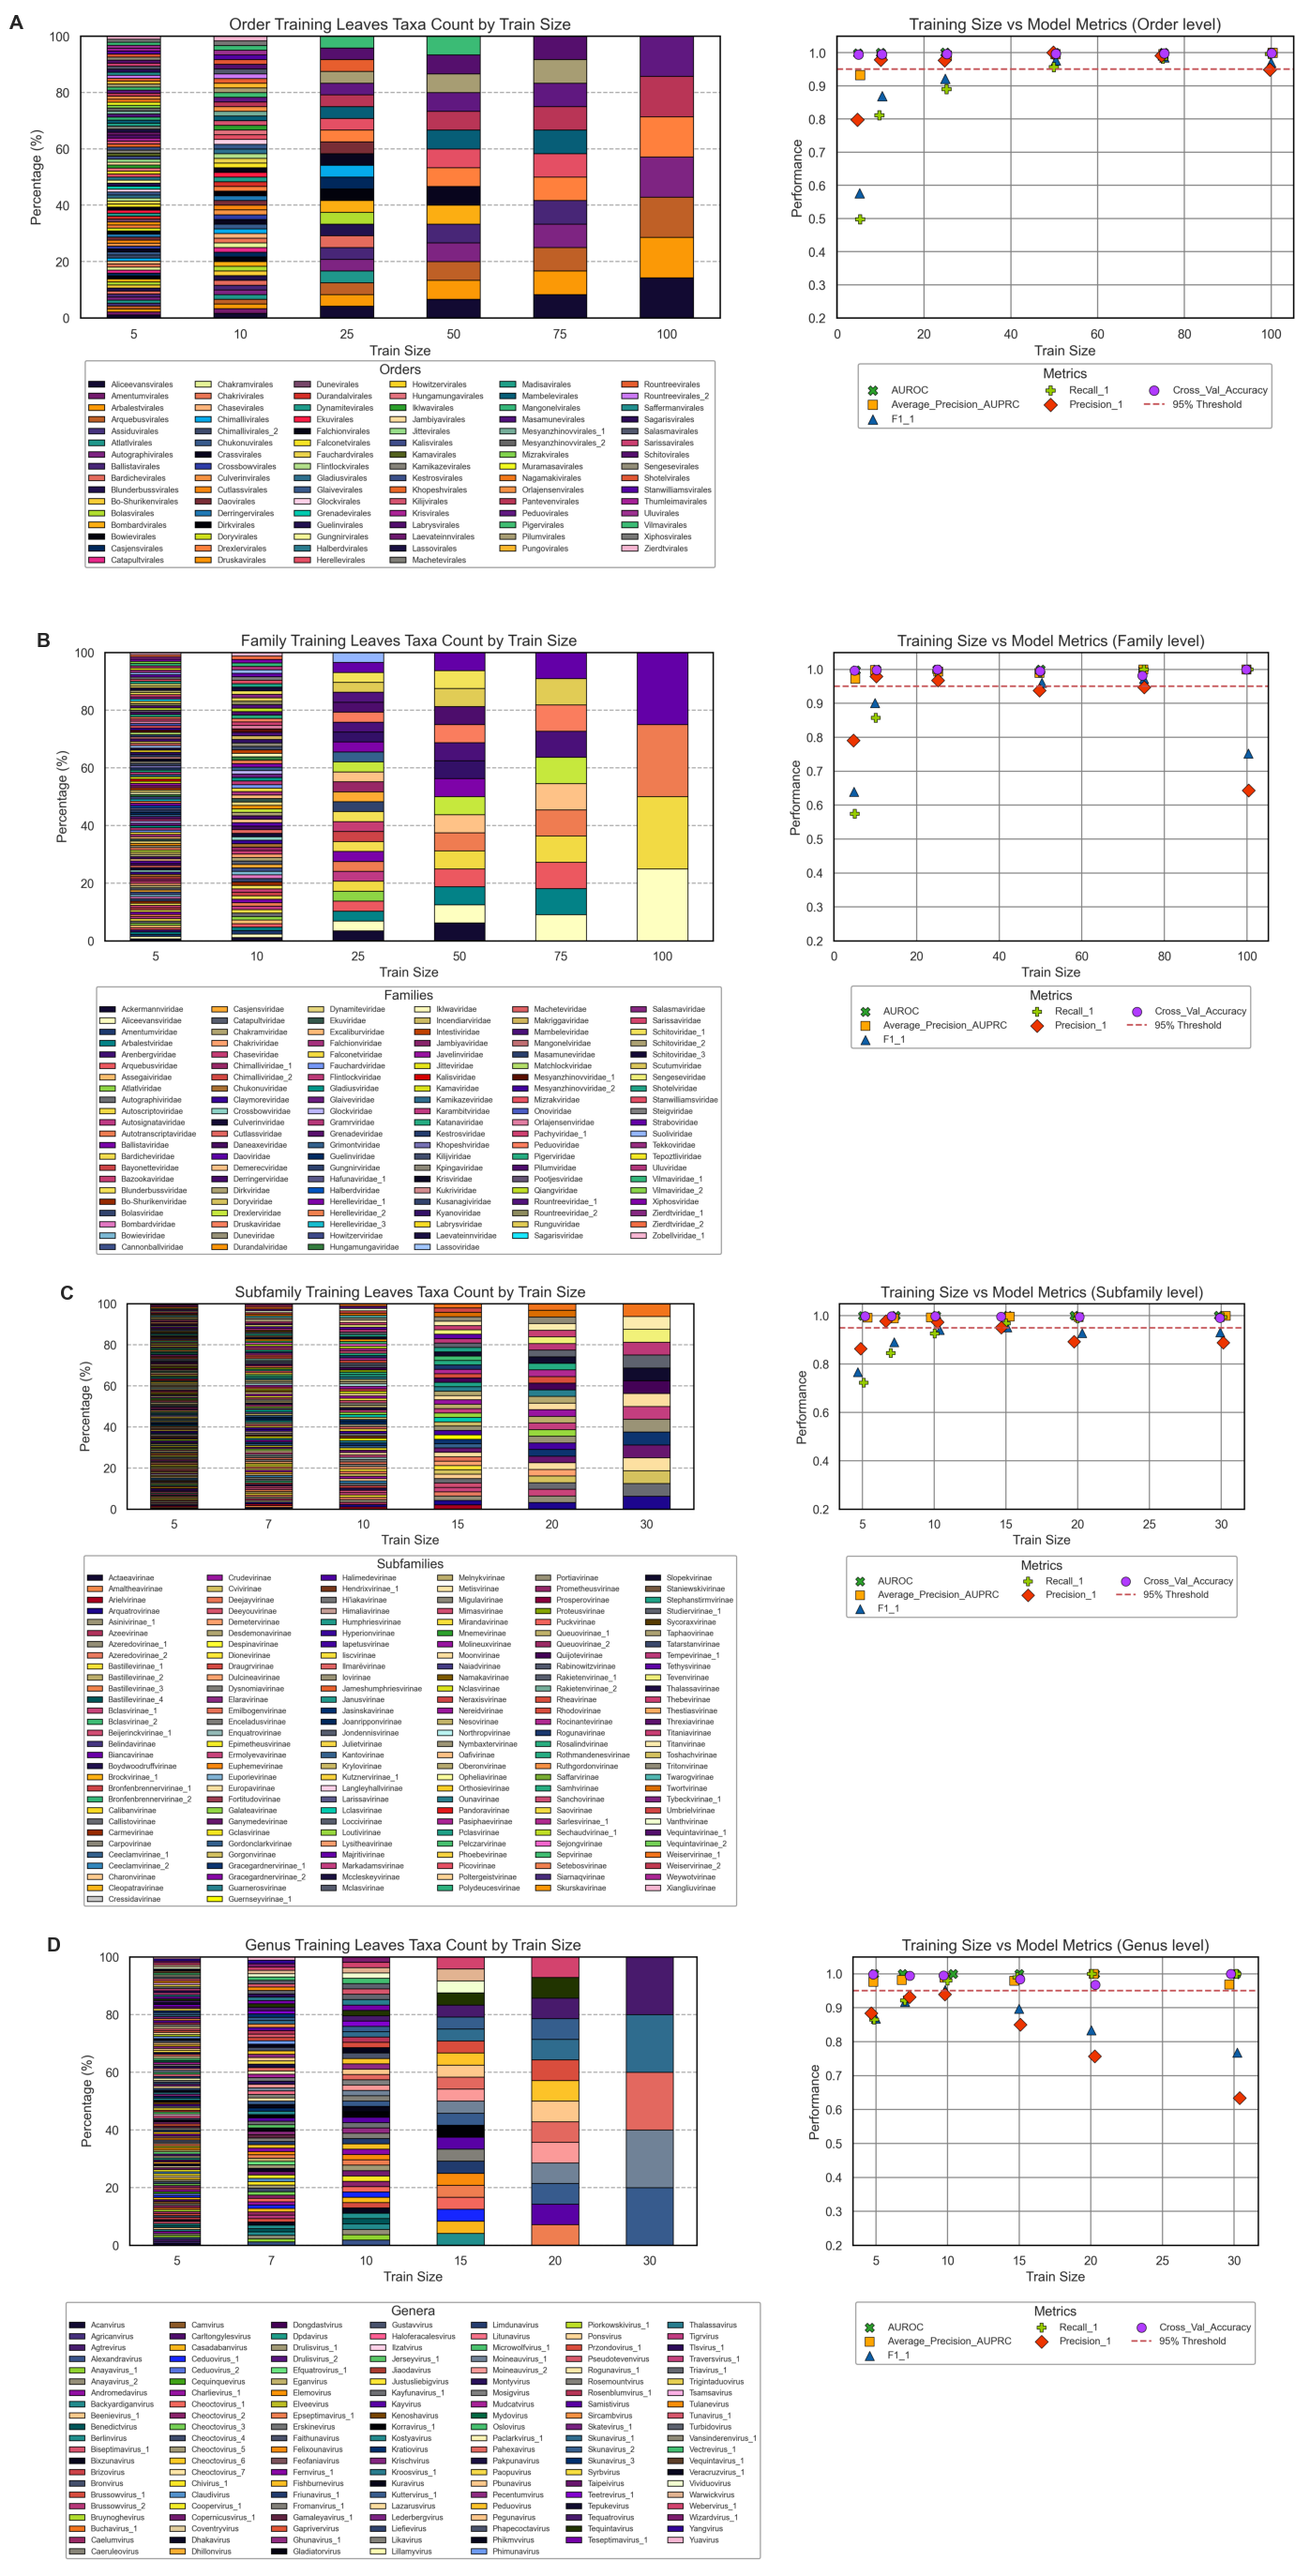

In [126]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, axs = plt.subplots(4, 1, figsize=(14, 28))  # 4 rows, 1 column

image_paths = [
    "../plots/order_training_metrics.png",
    "../plots/family_training_metrics.png",
    "../plots/subfamily_training_metrics.png",
    "../plots/genus_training_metrics.png"  
]

labels = ['A', 'B', 'C', 'D']

for ax, img_path, label in zip(axs, image_paths, labels):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')
    ax.text(-0.01, 0.99, label, transform=ax.transAxes,
            fontsize=15, fontweight='bold', va='top', ha='left')

plt.tight_layout()
plt.savefig("../plots/classifier_training_performance_by_rank.png", dpi=300)
plt.show()

# 🧠 Model Performance Summary by Taxonomic Rank

Classifier Training Results Overview

The model demonstrates consistently strong performance across all taxonomic ranks, with higher-level ranks (Order, Family) showing excellent robustness. As training size increases, performance converges across all metrics, although finer ranks (Subfamily, Genus) are more sensitive to sample size.
# 🔤 A. Order Level

    Training Diversity: The distribution of Orders across training sizes remains broad, with many taxa represented even at small sizes.

    Model Metrics:

        Performance remains very high across all metrics.

        AUROC, Recall, Average Precision, and Cross-Validation Accuracy remain near 1.0, even at very small training sizes (5–10).

        A slight dip in Precision is observed at the largest training sizes — potentially due to class imbalance or saturation with dominant clades.

    Conclusion: Order-level classification is highly stable and requires minimal training data to achieve excellent accuracy.

# 🧬 B. Family Level

    Training Diversity: Slightly higher complexity than Order level, with an increasing number of Families represented as train size grows.

    Model Metrics:

        All metrics exceed 0.95 once the training size reaches ≥25.

        F1 and Precision are slightly more variable at training sizes <10, but quickly stabilize.

        AUROC and Average Precision remain consistently high across all training sizes.

    Conclusion: Reliable performance across Families is achieved with a moderate training size. Family-level classifiers remain robust, especially in Recall and AUROC.

# 🧬 C. Subfamily Level

    Training Diversity: High diversity with many Subfamilies sparsely represented at low training sizes.

    Model Metrics:

        Precision shows notable sensitivity at low training sizes (5–7), with clear improvement after ≥10.

        AUROC and Average Precision remain near-perfect, indicating the model effectively separates true classes.

        Recall and F1 remain stable, suggesting consistent detection of positives.

    Conclusion: Subfamily-level prediction is effective but benefits significantly from a minimum training threshold (~10 examples). Low precision at small sizes may reflect overprediction.

# 🔬 D. Genus Level

    Training Diversity: Highest variability in taxon distribution, with some Genera dominating the training pool at small sizes.

    Model Metrics:

        AUROC and Average Precision are robust (≥0.95) across most sizes.

        Precision is notably lower at small training sizes (5–10), and stabilizes after ~20–25 examples per genus.

        F1 and Recall stay strong, indicating that the model detects most relevant taxa but may misclassify low-abundance genera.

    Conclusion: Genus-level classification is most challenging and sensitive to training data quantity. Still, the model shows promising performance with sufficient examples.

# 🏁 Takeaways

    The classifier performs consistently well across all ranks, with AUROC and Average Precision being the most stable metrics.

    Order and Family levels require very few examples to reach peak performance.

    Subfamily and especially Genus levels show greater dependency on training size, with Precision being the most variable metric.

    Once the training size per taxon exceeds 10–15 examples, performance across all ranks converges toward near-perfect scores.

    These results underscore the importance of balanced representation across taxa, particularly at finer taxonomic levels.

# 2. Train Production classifiers on all data...

In [28]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from joblib import Parallel, delayed

def train_classifier(X, y, taxon, rank, model_dir):
    """Train a classifier for a single taxon and save results."""
    print(f"Training classifier for {rank}: {taxon}")
    y_binary = (y[rank] == taxon).astype(int)  # Fix: correctly extract labels

    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
    model.fit(X, y_binary)

    feature_importances = dict(zip(X.columns, model.feature_importances_))

    model_filename = f"{model_dir}/{taxon}.pkl"
    with open(model_filename, "wb") as f:
        pickle.dump(model, f)

    return {
        "Level": rank,
        "Taxon": taxon,
        "Model_Path": model_filename
    }

def train_production_classifiers(X, y, rank='Order', model_dir=None):
    """Train classifiers on all data for each taxonomic level without splitting."""
    results = []
    feature_importances_all = []

    # Append rank to the base model_dir to create subfolder
    if model_dir is None:
        model_dir = f"models/production/{rank}"
    else:
        model_dir = os.path.join(model_dir, rank)

    os.makedirs(model_dir, exist_ok=True)

    taxa_unique = y[rank].unique()

    print(f"Training classifiers for {rank} on full dataset...")

    parallel_results = Parallel(n_jobs=-1)(
        delayed(train_classifier)(X, y, taxon, rank, model_dir)
        for taxon in tqdm(taxa_unique, desc=f"Training {rank} classifiers")
    )

    results.extend(parallel_results)

    results_df = pd.DataFrame(results)
    results_df.to_csv(os.path.join(model_dir, f"classification_models_{rank}.csv"), index=False)

    print(f"Models saved and results stored in {model_dir}")
    return results_df

In [29]:
X = df[training_matrix_T.columns]  # Feature matrix
y = df[['Order']]  # Target labels (must be a DataFrame)

In [30]:
# Drop rows where 'Order' is NaN
X_filtered = X[y['Order'].notna()]
y_filtered = y[y['Order'].notna()]

In [31]:
results_df = train_production_classifiers(X_filtered, 
                                          y_filtered, 
                                          rank='Order', 
                                          model_dir="../data/models/production")

Training classifiers for Order on full dataset...


Training Order classifiers: 100%|████████████████████████████████████████████████████| 159/159 [08:59<00:00,  3.39s/it]


Models saved and results stored in ../data/models/production\Order


In [32]:
X = df[training_matrix_T.columns] 
y = df[['Family']].dropna()  # Drop NaNs from y
X = X.loc[y.index]
results_df = train_production_classifiers(X, y, 
                                          rank='Family',
                                          model_dir="../data/models/production")

Training classifiers for Family on full dataset...


Training Family classifiers: 100%|███████████████████████████████████████████████████| 267/267 [14:45<00:00,  3.32s/it]


Models saved and results stored in ../data/models/production\Family


In [33]:
X = df[training_matrix_T.columns] 
y = df[['Subfamily']].dropna() 
X = X.loc[y.index] 
results_df = train_production_classifiers(X, y, 
                                          rank='Subfamily',
                                          model_dir="../data/models/production")

Training classifiers for Subfamily on full dataset...


Training Subfamily classifiers: 100%|████████████████████████████████████████████████| 502/502 [35:50<00:00,  4.28s/it]


Models saved and results stored in ../data/models/production\Subfamily


In [34]:
X = df[training_matrix_T.columns]
y = df[['Genus']].dropna()
X = X.loc[y.index]
results_df = train_production_classifiers(X, y, 
                                          rank='Genus', 
                                          model_dir="../data/models/production")

Training classifiers for Genus on full dataset...


Training Genus classifiers: 100%|████████████████████████████████████████████████| 1189/1189 [1:24:13<00:00,  4.25s/it]


Models saved and results stored in ../data/models/production\Genus


# 159 orders
# 267 families
# 502 subfamilies
# 1189 genera...

# 3. Get feature importances for all ranks

In [9]:
import os
import pickle
import pandas as pd
from tqdm import tqdm  # progress bar

ranks = ['Order', 'Family', 'Subfamily', 'Genus']
model_base_dir = "../data/models/production"

imp_dfs = {}
X = df[training_matrix_T.columns] 

for rank in ranks:
    print(f"\nLoading models for {rank}...")
    model_dir = os.path.join(model_base_dir, rank)
    model_files = [f for f in os.listdir(model_dir) if f.endswith(".pkl")]

    importance_rows = []

    for file in tqdm(model_files, desc=f"Processing {rank}", unit="model"):
        path = os.path.join(model_dir, file)
        taxon = file.replace(".pkl", "")
        
        with open(path, "rb") as f:
            model = pickle.load(f)
            importances = model.feature_importances_
            imp_series = pd.Series(importances, index=X.columns, name=taxon)
            importance_rows.append(imp_series)

    # Combine into DataFrame
    imp_df = pd.DataFrame(importance_rows)
    imp_dfs[rank] = imp_df


Loading models for Order...


Processing Order: 100%|███████████████████████████████████████████████████████████| 159/159 [00:05<00:00, 28.59model/s]



Loading models for Family...


Processing Family: 100%|██████████████████████████████████████████████████████████| 267/267 [00:07<00:00, 34.40model/s]



Loading models for Subfamily...


Processing Subfamily: 100%|███████████████████████████████████████████████████████| 502/502 [00:13<00:00, 36.08model/s]



Loading models for Genus...


Processing Genus: 100%|█████████████████████████████████████████████████████████| 1189/1189 [00:31<00:00, 37.96model/s]


In [12]:
# Step 1: Compute mean importance per feature for each rank
mean_imp_df = pd.DataFrame({
    rank: imp_dfs[rank].mean() for rank in imp_dfs
}).T  # shape: ranks × features

In [13]:
# Step 2: Select top N features globally (across all ranks)
top_n = 30
top_features = mean_imp_df.max().sort_values(ascending=False).head(top_n).index
mean_imp_top = mean_imp_df[top_features]

In [14]:
# looked up pfam annotations for hypothetical proteins...:
imp_dfs = {
    rank: df.rename(columns={
        'YP_009595775.1:hypothetical protein FDH00_gp17': 'YP_009595775.1:Phage minor tail protein L',
        'YP_010682209.1:hypothetical protein PQE84_gp32': 'YP_010682209.1:Poxvirus A22 protein',
        'YP_009594313.1:hypothetical protein FDG92_gp24':'YP_009594313.1:MGP3 C-terminal domain',
        'WQJ54370.1:MAG: UvsX-like recombinase ':'WQJ54370.1:UvsX-like recombinase'
    })
    for rank, df in imp_dfs.items()
}

In [15]:
def plot_top_features_by_rank(imp_dfs, top_n=10, main_title="Most Predictive Features by Taxonomic Rank"):
    """
    Plot the top N most important features for each taxonomic rank in separate subplots.

    Parameters:
        imp_dfs (dict): Dictionary of {rank: importance_df} with rows = taxa, columns = features.
        top_n (int): Number of top features to show per rank.
        main_title (str): Title for the entire figure.
    """
    n_ranks = len(imp_dfs)
    fig, axes = plt.subplots(1, n_ranks, figsize=(6 * n_ranks, 6), sharey=False)

    if n_ranks == 1:
        axes = [axes]

    for ax, (rank, df) in zip(axes, imp_dfs.items()):
        mean_imp = df.mean()
        top_feats = mean_imp.sort_values(ascending=False).head(top_n)

        sns.barplot(
            x=top_feats.values,
            y=top_feats.index,
            ax=ax,
            color="steelblue"  # Or any single color
        )
        ax.set_title(f"Top {top_n} Features: {rank}")
        ax.set_xlabel("Mean Importance")
        ax.set_ylabel("Feature")

    fig.suptitle(main_title, fontsize=25, weight='normal', y=0.97)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Reserve space for suptitle
    plt.savefig("../plots/classifier_most_predictive_features_by_rank.png", dpi=300)
    plt.show()

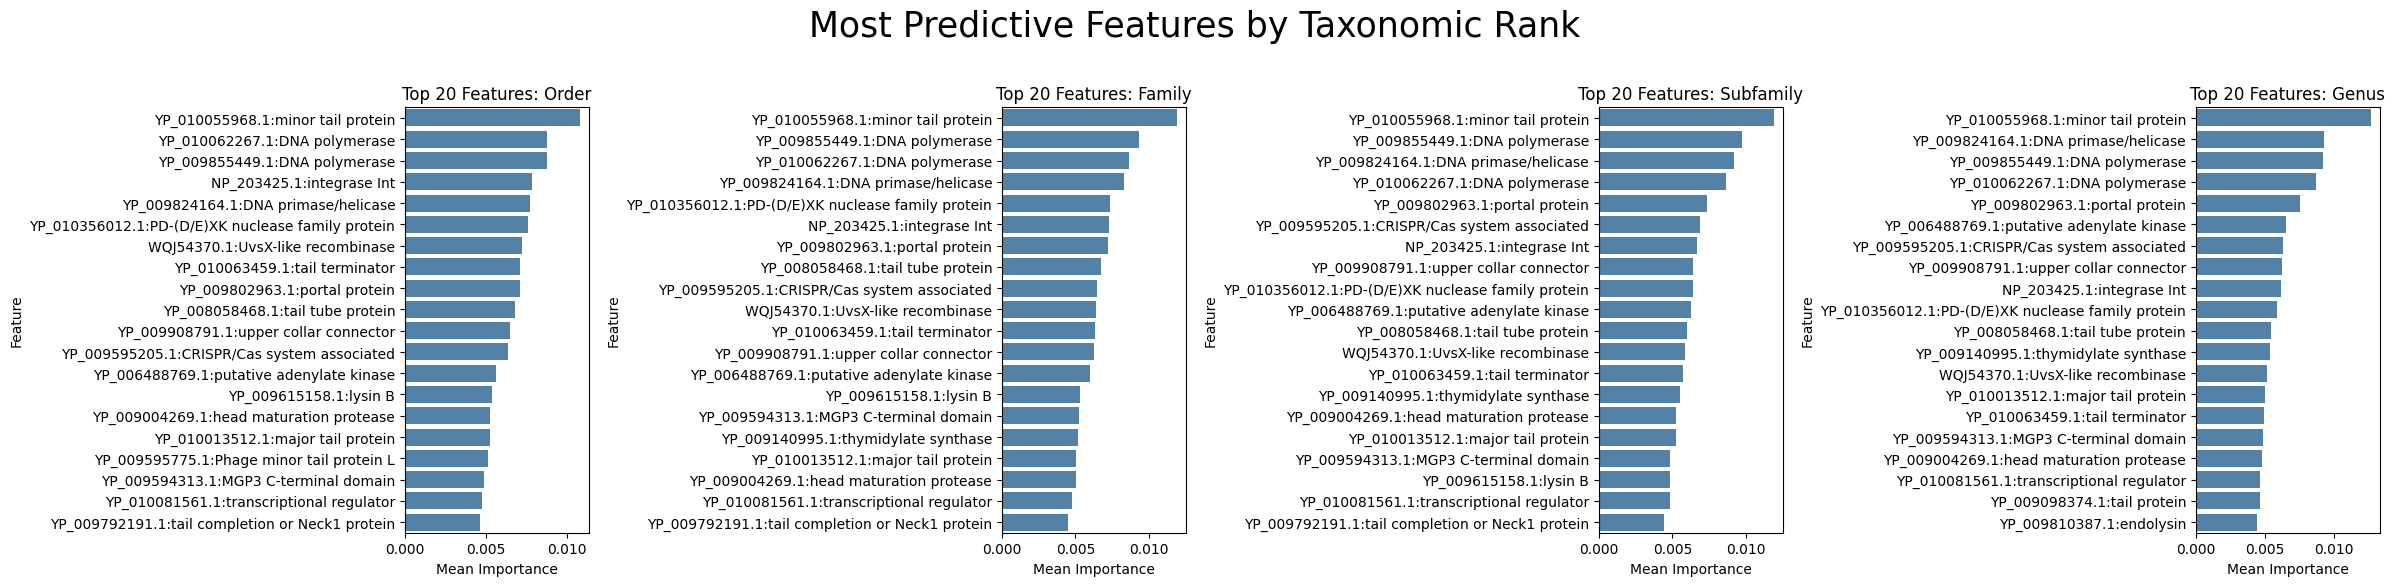

In [16]:
plot_top_features_by_rank(imp_dfs, top_n=20)

In [23]:
def classify_pfam(text):
    text = str(text).lower().replace('–', '-').replace('—', '-')

    if ":" in text:
        text = text.split(":", 1)[-1]

    if any(k in text for k in [
        "major capsid", "capsid", "head", "coat", "scaffold", "portal",
        "tail sheath", "tail tube", "neck", "connector", "virion protein",
        "tegument", "fibritin", "gp5", "gp8", "base plate", "surface protein", "gp10",
        "structural", "nucleocapsid", "baseplate", "fiber", "envelope", "virion",
        "collar", "head-tail joining", "injectosome", "translocase",
        "minor tail protein", "tail terminator", "major tail protein",
        "head maturation protease", "tail length tape measure", "tail completion", "neck1", "tail", "gp77"]):
        return "Structure"

    if any(k in text for k in [
        "terminase", "packaging", "dna packaging", "packaging motor", "gp17"]):
        return "Packaging"

    if any(k in text for k in [
        "toxin", "antitoxin", "toxin-antitoxin", "abortive infection", "abi",
        "restriction-modification", "ocr", "dna mimic", "immunity", "crispr",
        "crispr/cas", "anti-restriction"]):
        return "Defense"

    if any(k in text for k in [
        "polymerase", "helicase", "primase", "ligase", "replication", "replisome",
        "topoisomerase", "gyrase", "endonuclease", "exonuclease", "nuclease",
        "proofreading", "ribonucleotide", "methyltransferase", "uridyl", "mcm",
        "dna polymerase", "rna polymerase", "translation initiation",
        "transcription specificity", "reverse transcriptase", "transcription", "transcriptional",
        "thymidylate synthase", "a22"]):
        return "Replication"

    if any(k in text for k in [
        "integrase", "recombinase", "transposase", "transposon", "resolvase",
        "insertion sequence", "is element", "mu", "serine recombinase",
        "tyrosine recombinase", "giy-yig", "reca", "rect"]):
        return "Mobile Element"

    if any(k in text for k in [
        "holin", "endolysin", "lysin", "spanin", "cell wall degradation",
        "lysis", "muramidase", "rdd", "lysozyme", "amidase",
        "n-acetylmuramoyl", "alanine amidase"]):
        return "Lysis"

    if any(k in text for k in [
        "tail fiber", "tailspike", "rbp", "receptor", "adhesin", "adhesion",
        "host specificity", "tropism", "spike", "gp19", "gp12", "gp37", "gp38", "virulence", "mgp3"]):
        return "Infection"

    if any(k in text for k in [
        "channel", "porin", "transport", "permease", "symporter", "antiporter",
        "abc transporter"]):
        return "Transport"

    if any(k in text for k in [
        "kinase", "phosphatase", "oxidase", "dehydrogenase", "isomerase",
        "hydrolase", "enzyme", "transferase"]):
        return "Metabolism"

    if any(k in text for k in [
        "repressor", "activator", "regulator", "zinc finger", "helix-turn-helix",
        "ht-h", "sant", "marr", "sam-like", "ribbon-helix-helix"]):
        return "Regulation"

    if any(k in text for k in [
        "sensor", "response regulator", "histidine kinase", "quorum sensing",
        "chemotaxis", "two-component"]):
        return "Signaling"

    if any(k in text for k in [
        "ribosome", "ribosomal", "translation", "elongation factor",
        "initiation factor", "termination factor"]):
        return "Translation"

    if any(k in text for k in [
        "immune evasion", "vif", "tat", "modulator", "interferon", "bcl",
        "host interaction", "virulence factor"]):
        return "Host_modulation"

    if any(k in text for k in [
        "hypothetical", "unknown", "uncharacterised", "uncharacterized", "duf", "upf",
        "domain of unknown function", "family of unknown function"]):
        return "Unknown/Other"

    return "Unknown/Other"

In [24]:
# ok this one is perfect....!!!@!
def plot_siamcat_style_interpretation(imp_dfs, top_n=30):
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from matplotlib import gridspec
    import matplotlib.colors as mcolors


    from matplotlib.colors import BoundaryNorm, ListedColormap

    # Custom value breaks (e.g., like "<0.1%", "0.1–0.25%", etc.)
    value_breaks = [0, 0.0005, 0.001, 0.0025, 0.005, 0.008, 0.010, 0.0135]  # final upper edge slightly above max
    
    # Matching green shades (light → dark)
    colors = ["#f7fcf5", "#e5f5e0", "#c7e9c0", "#a1d99b", "#74c476", "#31a354", "#006d2c"]
    
    # Create colormap and normalization
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(value_breaks, ncolors=len(colors), clip=True)

    sns.set_style('ticks')

    # Step 1: Mean feature importance per rank
    mean_imp = {rank: df.mean(axis=0) for rank, df in imp_dfs.items()}
    imp_matrix = pd.DataFrame(mean_imp)

    # Step 2: Select top N features overall
    top_feats = imp_matrix.mean(axis=1).sort_values(ascending=False).head(top_n).index
    imp_top = imp_matrix.loc[top_feats]

    # # # Step 3: Function category mapping
    # if feature_to_function is None:
    #print(top_feats)
    feature_to_function = {feat: classify_pfam(feat) for feat in top_feats}

    function_palette = {
        'Structure': '#1f77b4',
        'Replication': '#2ca02c',
        'Transport': '#d62728',
        'Mobile Element': '#FADA7A',
        'Defense': '#9EC6F3',
        'Metabolism': '#B13BFF',
        'Lysis': '#e377c2',
        'Infection':'#FFB823',
        'Unknown/Other': '#7f7f7f' #,
        #'Other': 'gray'
    }
    #print(feature_to_function)
    function_labels = pd.Series(top_feats, index=top_feats).map(feature_to_function).fillna('Other')
    #print(function_labels)
    function_colors = function_labels.map(function_palette).fillna('gray')

    # Step 4: Layout
    fig = plt.figure(figsize=(16, max(10, top_n * 0.3)))

    # Shrink the gap column (was 0.1), increase others slightly
    gs = gridspec.GridSpec(1, 5, width_ratios=[1.25, 1, 0.1, 0.2, 0.3], wspace=0.1)

    # A. Feature Weights heatmap
    ax_weights = fig.add_subplot(gs[0, 0])
    vmax = np.abs(imp_top.values).max()
  
    sns.heatmap(
        imp_top,
        cmap="PiYG", center=0, cbar=True, ax=ax_weights, vmin=0,
        vmax=imp_top.values.max(), yticklabels=top_feats, cbar_kws={"label": "Weight"}
    )
    ax_weights.set_title("Feature Weights by Rank")
    ax_weights.set_xticklabels(imp_top.columns, rotation=90)

    # B. Feature weight distribution boxplot
    imp_top_T = imp_top.T.copy()
    imp_top_T.columns.name = None  # <- Removes "Weight" from being auto-used as axis label

    ax_box = fig.add_subplot(gs[0, 1])
    sns.boxplot(data=imp_top_T, orient='h', color='gray', linewidth=1, ax=ax_box)
    ax_box.set_yticks([])
    ax_box.set_ylabel("")
    #ax_box.set_xlabel("Weight")
    ax_box.set_title("Feature Weight Distribution")
    ax_box.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.6)

    # C. Function color strip
    ax_labels = fig.add_subplot(gs[0, 2])
    rgb_array = np.stack(function_colors.map(mcolors.to_rgb).to_numpy()).reshape((top_n, 1, 3))
    ax_labels.imshow(rgb_array, aspect='auto')
    ax_labels.set_xticks([])
    ax_labels.set_yticks([])
    ax_labels.set_title("Function")

    # D. Spacer (just a thin visual gap, no axis used)

    # E. Boxplot for weight captured
    imp_df = imp_dfs["Order"]
    weight_fraction = imp_df[top_feats].sum(axis=1) / imp_df.sum(axis=1)
    ax_captured = fig.add_subplot(gs[0, 4])
    sns.boxplot(
        y=weight_fraction,
        orient='v',
        width=0.4,
        fliersize=3,
        linewidth=1.5,
        ax=ax_captured,
        boxprops=dict(facecolor='none', edgecolor="#212121", linewidth=1.5),
        whiskerprops=dict(color="#212121", linewidth=1.5),
        capprops=dict(color="#212121", linewidth=1.5),
        medianprops=dict(color="#212121", linewidth=1.5),
        flierprops=dict(marker='o', markerfacecolor="#212121", markeredgecolor="#212121", 
                        markersize=4, linestyle='none', alpha=0.5)
    )

    pos = ax_captured.get_position()
    new_height = pos.height * 0.70
    ax_captured.set_position([0.8, pos.y0, pos.width, new_height])

    from matplotlib.patches import Patch

    handles = [
        Patch(facecolor=color, edgecolor='black', linewidth=0.5)
        for color in function_palette.values()
    ]
    labels = list(function_palette.keys())
    
    fig.legend(
        handles,
        labels,
        title="Functional Category",
        loc='upper center',
        bbox_to_anchor=(0.83, 0.91),
        fontsize=9,
        title_fontsize=10,
        handlelength=1.2,  # optional, tweak visual spacing
        handleheight=1.2
    )

    ax_weights.set_title("Feature Weights by Rank", fontsize=15)
    ax_box.set_title("Feature Weight Distribution", fontsize=15)
    ax_labels.set_title("Function", fontsize=15)
    ax_captured.set_title("Proportion of Model\nWeight Explained", fontsize=13)

    ax_weights.set_xlabel("Taxonomic Rank", fontsize=15)
    ax_weights.set_ylabel("Feature", fontsize=15)
    ax_weights.tick_params(axis='y', labelsize=14)
    
    ax_box.set_xlabel("Weight", fontsize=15)
    ax_box.set_ylabel("")
    
    ax_captured.set_ylabel("Fraction of Total Weight", fontsize=12)

    # Add Panel labesls...:
    ax_weights.text(-1.37, 1.05, "A", transform=ax_weights.transAxes,
                fontsize=18, fontweight='bold')
    
    ax_box.text(-0.05, 1.05, "B", transform=ax_box.transAxes,
                fontsize=18, fontweight='bold')
    
    ax_labels.text(-0.35, 1.05, "C", transform=ax_labels.transAxes,
                   fontsize=18, fontweight='bold')

    plt.suptitle("Random Forest Classifier: Top Predictive Features", fontsize=27, x=0.31, y=0.99)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig("../plots/siamcat_features_interpretation.png", bbox_inches='tight', dpi=300)

    plt.show()

C:\Users\crtuser\AppData\Local\Temp\ipykernel_10032\3211931374.py:188: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


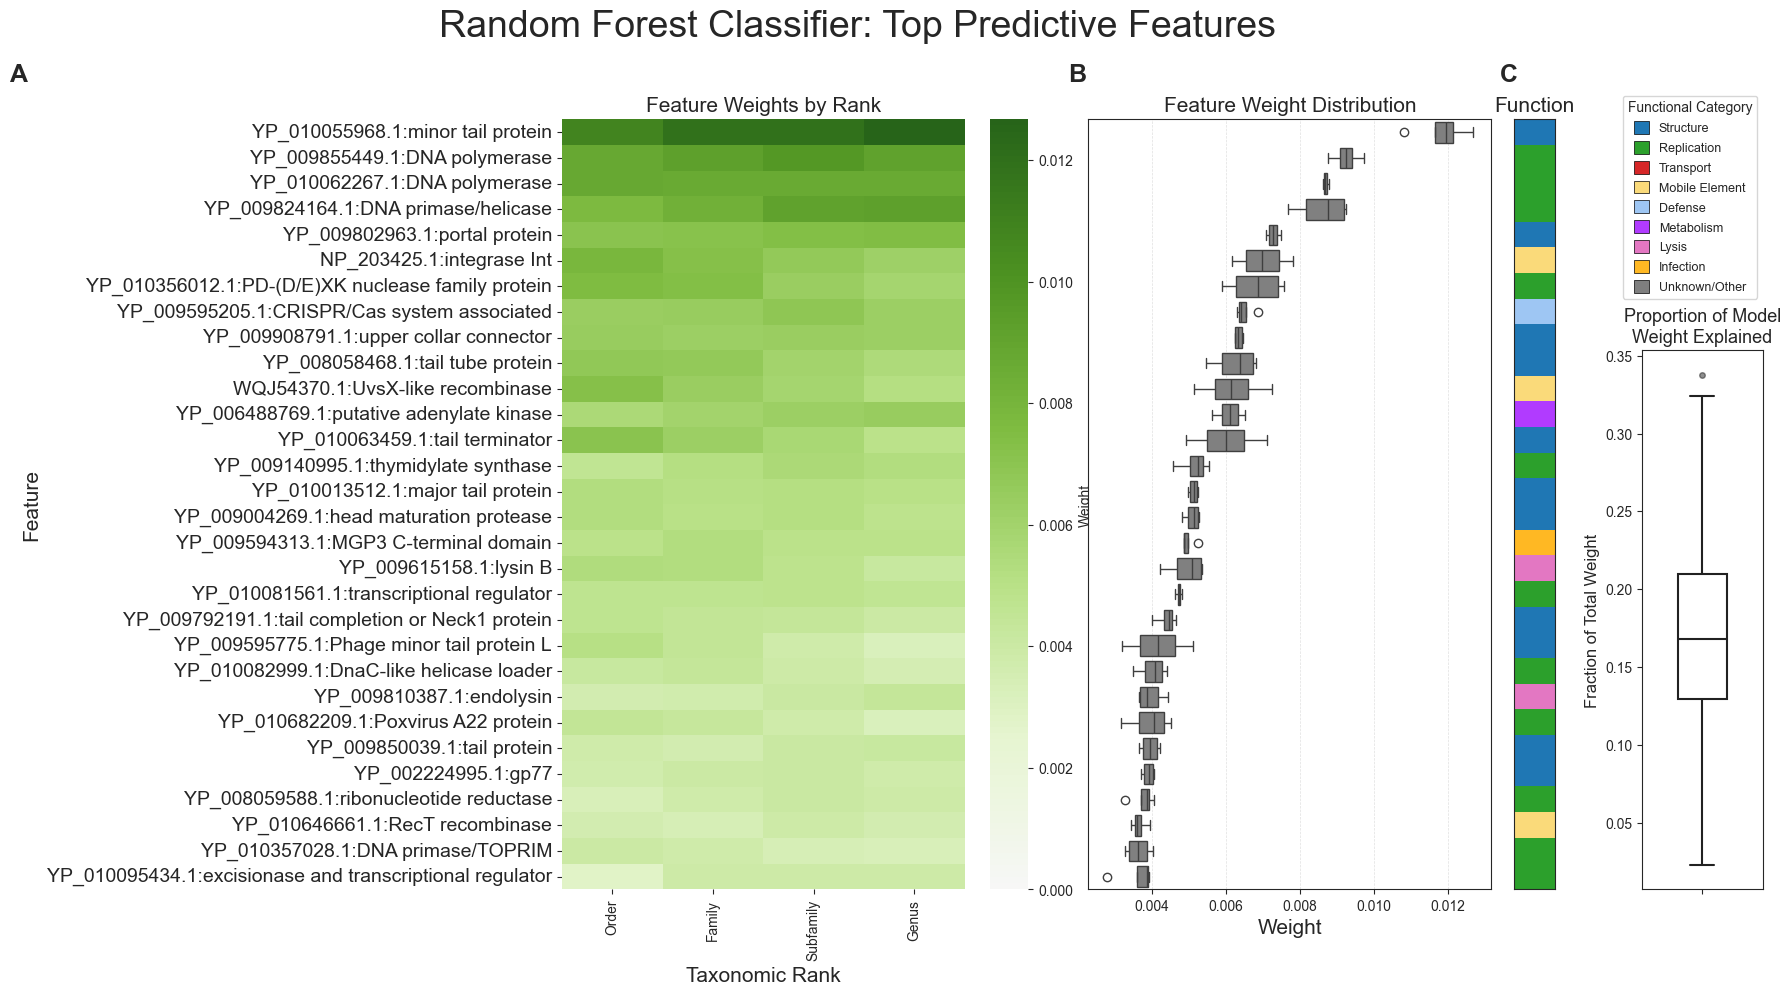

In [25]:
plot_siamcat_style_interpretation(imp_dfs, top_n=30)

In [16]:
# % of top 30 features that are structural or replicative
22/30

0.7333333333333333

The top 30 protein features account for ~15% of the total model importance, indicating that a small subset of features disproportionately drive taxonomic predictions. These proteins may represent core phylogenetic or functional signatures across viral Orders.

In [26]:
df.loc[df.Order=='Mjï¿½lnirvirales','Order']='Mjolnirvirales'

In [27]:
top_feats = top_features

In [28]:
rename_map = {
    'YP_009595775.1:hypothetical protein FDH00_gp17': 'YP_009595775.1:Phage minor tail protein L',
    'YP_010682209.1:hypothetical protein PQE84_gp32': 'YP_010682209.1:Poxvirus A22 protein',
    'YP_009594313.1:hypothetical protein FDG92_gp24':'YP_009594313.1:MGP3 C-terminal domain',
    'WQJ54370.1:MAG: UvsX-like recombinase ':'WQJ54370.1:UvsX-like recombinase'
}

In [30]:
# Apply to df
df = df.rename(columns=rename_map)

C:\Users\crtuser\anaconda3\envs\folding\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\Users\crtuser\anaconda3\envs\folding\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


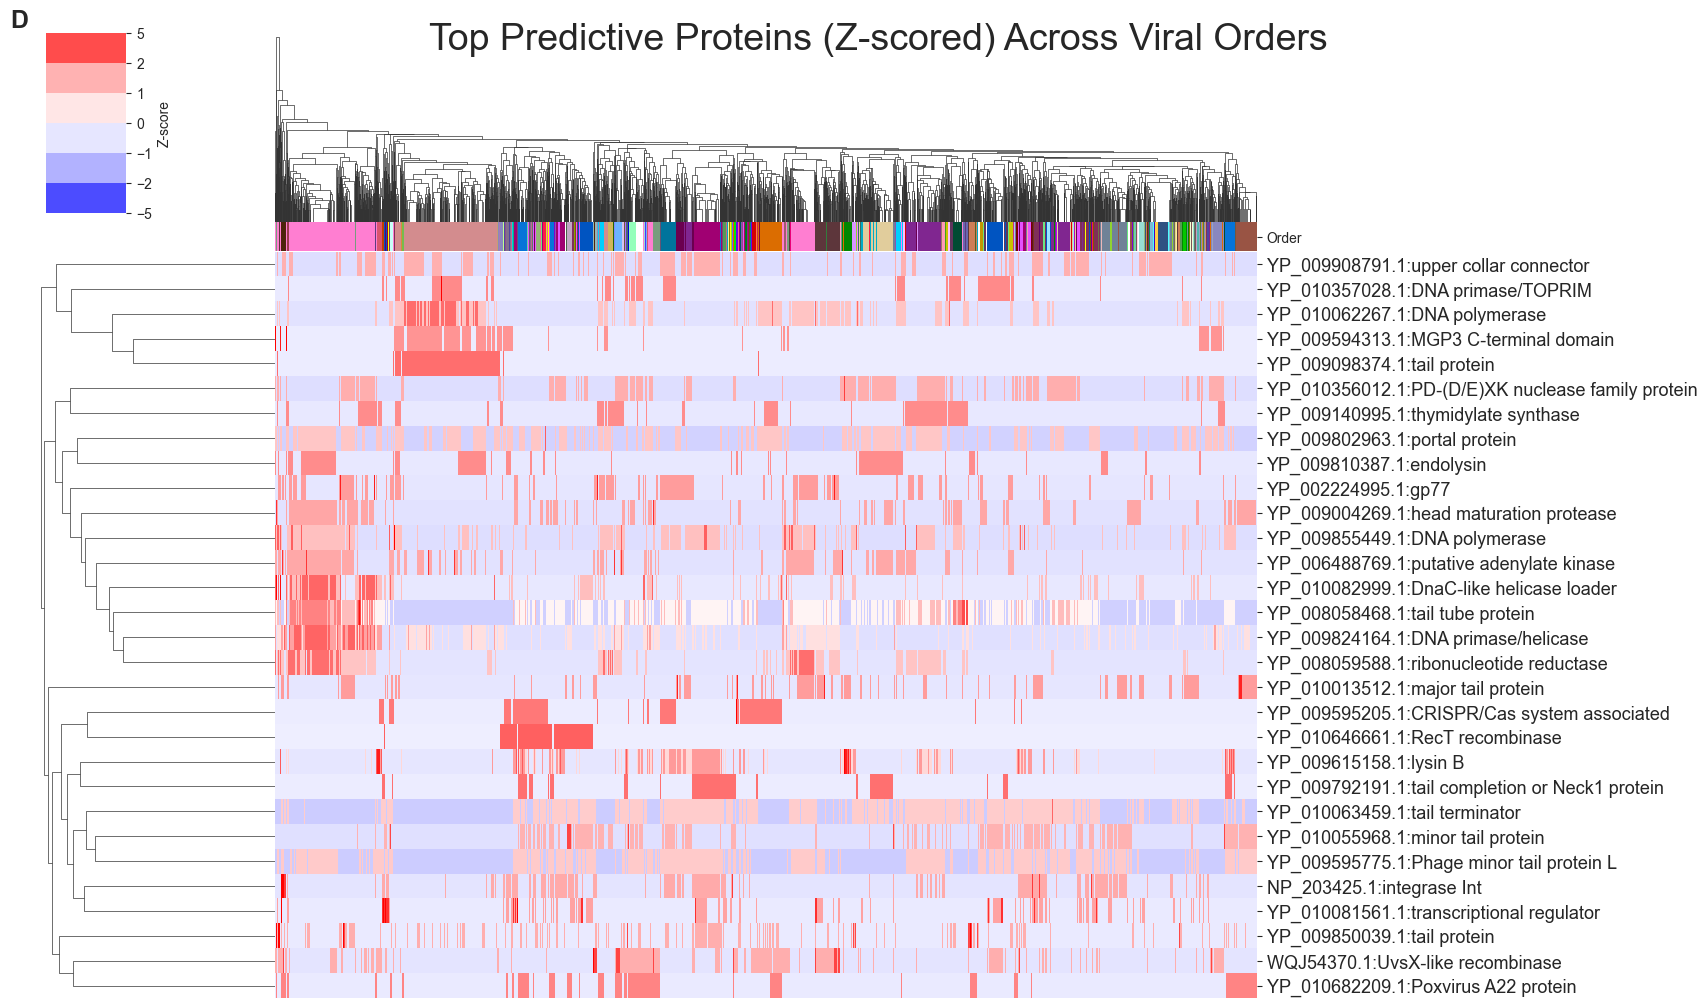

In [31]:
# Generate 154-color high-contrast palette
import colorcet as cc
import random
from scipy.stats import zscore

glasbey_colors = list(cc.glasbey)
while len(glasbey_colors) < 154:
    glasbey_colors += list(cc.glasbey)
final_palette = glasbey_colors[:154]
random.seed(42)
random.shuffle(final_palette)

# Compute z-score matrix
top_feats = [rename_map.get(f, f) for f in top_feats]
df[top_feats] = df[top_feats].apply(pd.to_numeric, errors='coerce')
z_df = df[top_feats].apply(zscore, axis=0)

# Map Orders to palette
z_df['Order'] = df['Order']
z_df = z_df.dropna(subset='Order').sort_values(by='Order')
orders = z_df['Order']
z_df = z_df.drop(columns='Order')
unique_orders = sorted(orders.unique())
order_colors = dict(zip(unique_orders, final_palette[:len(unique_orders)]))  # ← updated here
color_row = orders.map(order_colors)

from matplotlib.colors import ListedColormap, BoundaryNorm

boundaries = [-5, -2, -1, 0, 1, 2, 5]  # 7 bins => need 7 colors
colors = [
    "#AF3E3E",  # <= -2, deep red
    "#FAFFCA",  # -2 to -1, pale yellow
    '#E1EEBC',  # -1 to 0, pale green
    "#000000",  # 0 to 1, black
    '#F8F4E1',  # 1 to 2, white
    "#8DBCC7",  # 2 to 5, light blue
    "#5459AC"   # 5 to 10, darker blue
]


# Create colormap and normalization
cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries, ncolors=len(colors))

# Use in clustermap
g = sns.clustermap(
    z_df.T,
    col_colors=color_row,
    cmap='bwr',
    vmin=boundaries[0],
    vmax=boundaries[-1],
    figsize=(16, 10),
    xticklabels=False,
    yticklabels=True,
    cbar_kws={
        "label": "Z-score",
        "ticks": boundaries,
        "boundaries": boundaries
    }
)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=13)
g.ax_heatmap.text(
    -0.27, 1.3, "D", transform=g.ax_heatmap.transAxes,
    fontsize=18, fontweight='bold'
)

# ------------------- Reorder legend based on clustered column order -------------------
# # Get sample order from the clustered dendrogram
# col_order = g.dendrogram_col.reordered_ind
# ordered_samples = z_df.index[col_order]  # Get sample indices in clustered order
# ordered_orders = orders.loc[ordered_samples]  # Get their corresponding Orders

# # Get unique orders in appearance order (preserve order)
# from collections import OrderedDict
# ordered_unique_orders = list(OrderedDict.fromkeys(ordered_orders))

# # Remap legend handles in new order
# legend_handles = [Patch(color=order_colors[o], label=o) for o in ordered_unique_orders]

# # Plot legend
# g.fig.legend(
#     handles=legend_handles,
#     title="Order",
#     loc='upper center',
#     bbox_to_anchor=(0.5, -0.01),
#     bbox_transform=g.fig.transFigure,
#     ncol=8,
#     fontsize=9
# )

# # # Add legend
# legend_handles = [Patch(color=order_colors[o], label=o) for o in unique_orders]
# g.fig.legend(
#     handles=legend_handles,
#     title="Order",
#     loc='upper center',
#     bbox_to_anchor=(0.5,0),
#     bbox_transform=g.fig.transFigure,
#     ncol=8,
#     fontsize=9
# )
g.fig.suptitle("Top Predictive Proteins (Z-scored) Across Viral Orders", fontsize=27, y=0.99, x=0.54)
g.savefig("../plots/zscore_clustermap.png", bbox_inches='tight', dpi=300)
plt.show()

| Component              | Meaning                                                                                                                           |
| ---------------------- | --------------------------------------------------------------------------------------------------------------------------------- |
| **Rows (Y-axis)**      | Top features (e.g. genes/proteins/Pfams) selected based on model importance.                                                      |
| **Columns (X-axis)**   | Individual samples from your dataset.                                                                                             |
| **Color scale**        | Z-score of each feature’s abundance across samples:<br>• Negative (greenish): underrepresented<br>• Positive (brownish): enriched |
| **Top dendrogram**     | Hierarchical clustering of **samples** (columns) based on feature similarity.                                                     |
| **Side dendrogram**    | (Disabled in your code) would normally show clustering of **features**.                                                           |
| **Color bar (top)**    | Each column is color-coded by the sample’s `Order`.                                                                               |
| **Legend (bottom)**    | Color key for which color represents which `Order`.                                                                               |
| **Z-score bar (left)** | Indicates how standardized the feature values are.                                                                                |


In [32]:
from PIL import Image, ImageOps

def combine_plots_vertically(img1_path, img2_path, output_path, border=50, border_color="white"):
    img1 = Image.open(img1_path)
    img2 = Image.open(img2_path)

    # Make width consistent (resize if needed)
    width = max(img1.width, img2.width)
    img1 = img1.resize((width, int(img1.height * width / img1.width)))
    img2 = img2.resize((width, int(img2.height * width / img2.width)))

    # Create new image with combined height
    combined = Image.new("RGB", (width, img1.height + img2.height), color="white")
    combined.paste(img1, (0, 0))
    combined.paste(img2, (0, img1.height))

    # Add border around combined image
    bordered = ImageOps.expand(combined, border=border, fill=border_color)
    bordered.save(output_path)

# Example usage
combine_plots_vertically(
    "../plots/siamcat_features_interpretation.png",
    "../plots/zscore_clustermap.png",
    "../plots/features_figure.png",
    border=60,
    border_color="white"
)

print("woop")

woop


#  4. Novelty-aware post-prediction QC layer 👾🧬✨

## Compute Intra- and Inter- clade metrics

In [64]:
from sklearn.metrics import pairwise_distances
import pandas as pd
import numpy as np
from itertools import combinations
from tqdm import tqdm

def compute_clade_metrics(presence_matrix, metadata, rank='Family', similarity_metric='jaccard', distance_metric='euclidean'):
    """
    Compute intra- and inter-clade metrics (Euclidean & Jaccard) for a given taxonomic rank.

    Args:
        presence_matrix (pd.DataFrame): Genome x features presence/absence matrix.
        metadata (pd.DataFrame): DataFrame with index = genome IDs, and columns including the taxonomic ranks.
        rank (str): Taxonomic rank to compute metrics for. Must be a column in metadata.
        similarity_metric (str): Metric for % shared proteins (e.g. 'jaccard').
        distance_metric (str): Metric for distance (e.g. 'euclidean').

    Returns:
        intra_df (pd.DataFrame): Intra-clade similarity and distance.
        inter_df (pd.DataFrame): Inter-clade similarity and distance.
    """
    df = presence_matrix.copy()
    df.index = df.index.str.replace(r'\.\d+$', '', regex=True)
    metadata.index = metadata.index.str.replace(r'\.\d+$', '', regex=True)

    # Join labels
    df_labeled = df.join(metadata[[rank]])
    df_labeled = df_labeled.dropna(subset=[rank])

    clades = df_labeled[rank].unique()
    intra_rows = []
    inter_rows = []

    print(f"🔬 Computing intra-clade metrics for {len(clades)} {rank} clades...")
    for clade in tqdm(clades, desc=f"Intra-{rank}"):
        group = df_labeled[df_labeled[rank] == clade].drop(columns=[rank])
        if len(group) < 2:
            continue

        eucl = pairwise_distances(group.values, metric=distance_metric)
        jacc = pairwise_distances(group.values.astype(bool), metric=similarity_metric)

        tril_idx = np.triu_indices_from(eucl, k=1)
        eucl_vals = eucl[tril_idx]
        jacc_vals = jacc[tril_idx]
        shared_vals = 1 - jacc_vals  # Jaccard dissimilarity → shared %

        intra_rows.append({
            'rank': rank,
            'clade': clade,
            'n': len(group),
            'intra_avg_euclidean': np.mean(eucl_vals),
            'intra_median_euclidean': np.median(eucl_vals),
            'intra_std_euclidean': np.std(eucl_vals),
            'intra_min_euclidean': np.min(eucl_vals),
            'intra_max_euclidean': np.max(eucl_vals),

            'intra_avg_shared_proteins': np.mean(shared_vals),
            'intra_median_shared_proteins': np.median(shared_vals),
            'intra_std_shared_proteins': np.std(shared_vals),
            'intra_min_shared_proteins': np.min(shared_vals),
            'intra_max_shared_proteins': np.max(shared_vals)
        })

    print(f"\n🌍 Computing inter-clade metrics between {len(clades)} {rank} clades...")
    for clade_a, clade_b in tqdm(combinations(clades, 2), total=(len(clades)*(len(clades)-1))//2, desc=f"Inter-{rank}"):
        group_a = df_labeled[df_labeled[rank] == clade_a].drop(columns=[rank])
        group_b = df_labeled[df_labeled[rank] == clade_b].drop(columns=[rank])

        if group_a.empty or group_b.empty:
            continue

        eucl = pairwise_distances(group_a.values, group_b.values, metric=distance_metric)
        jacc = pairwise_distances(group_a.values.astype(bool), group_b.values.astype(bool), metric=similarity_metric)
        shared_vals = 1 - jacc

        inter_rows.append({
            'rank': rank,
            'clade_1': clade_a,
            'clade_2': clade_b,
            'n_clade_1': len(group_a),
            'n_clade_2': len(group_b),
            'inter_avg_euclidean': np.mean(eucl),
            'inter_median_euclidean': np.median(eucl),
            'inter_std_euclidean': np.std(eucl),
            'inter_avg_shared_proteins': np.mean(shared_vals),
            'inter_median_shared_proteins': np.median(shared_vals),
            'inter_std_shared_proteins': np.std(shared_vals)
        })

    intra_df = pd.DataFrame(intra_rows)
    inter_df = pd.DataFrame(inter_rows)
    return intra_df, inter_df

def filter_taxa_and_matrix(taxa_df, training_matrix_T, rank):
    """
    Filters metadata and training matrix to only include genomes with non-null values
    for the specified rank and that exist in the training matrix.

    Args:
        taxa_df (pd.DataFrame): Metadata with 'Leaves' column and taxonomic labels.
        training_matrix_T (pd.DataFrame): Transposed training matrix (genomes x features).
        rank (str): Taxonomic rank to filter on (e.g., 'Family', 'Genus').

    Returns:
        filtered_taxa_df (pd.DataFrame): Metadata filtered to genomes with valid labels and matching matrix.
        filtered_training_matrix (pd.DataFrame): Training matrix filtered to matching genomes.
    """
    taxa_df = taxa_df.copy()
    training_matrix_T = training_matrix_T.copy()

    # Drop NAs for the specified rank
    filtered_taxa_df = taxa_df[['Leaves', rank]].dropna()

    # Set index to Leaves so we can align with training_matrix_T
    filtered_taxa_df = filtered_taxa_df.set_index('Leaves')

    # Filter to matching genomes
    filtered_taxa_df = filtered_taxa_df[filtered_taxa_df.index.isin(training_matrix_T.index)]
    filtered_training_matrix = training_matrix_T.loc[filtered_taxa_df.index]
    print(f'Filtered df at {rank} level')

    return filtered_taxa_df, filtered_training_matrix

In [65]:
filtered_taxa_df_family, filtered_training_matrix_family = filter_taxa_and_matrix(taxa_df, training_matrix_T, rank='Family')
filtered_taxa_df_order, filtered_training_matrix_order = filter_taxa_and_matrix(taxa_df, training_matrix_T, rank='Order')
filtered_taxa_df_subfamily, filtered_training_matrix_subfamily = filter_taxa_and_matrix(taxa_df, training_matrix_T, rank='Subfamily')
filtered_taxa_df_genus, filtered_training_matrix_genus = filter_taxa_and_matrix(taxa_df, training_matrix_T, rank='Genus')

intra_order, inter_order = compute_clade_metrics(filtered_training_matrix_order, filtered_taxa_df_order, rank="Order")
intra_family, inter_family = compute_clade_metrics(filtered_training_matrix_family, filtered_taxa_df_family, rank="Family")
intra_subfamily, inter_subfamily = compute_clade_metrics(filtered_training_matrix_subfamily, filtered_taxa_df_subfamily, rank="Subfamily")
intra_genus, inter_genus = compute_clade_metrics(filtered_training_matrix_genus, filtered_taxa_df_genus, rank="Genus")

intra_rank_relatedness = pd.concat([intra_order, intra_family, intra_subfamily, intra_genus])
inter_rank_relatedness = pd.concat([inter_order, inter_family, inter_subfamily, inter_genus])

Filtered df at Family level
Filtered df at Order level
Filtered df at Subfamily level
Filtered df at Genus level
🔬 Computing intra-clade metrics for 159 Order clades...


Intra-Order: 100%|███████████████████████████████████████████████████████████████████| 159/159 [00:22<00:00,  7.20it/s]



🌍 Computing inter-clade metrics between 159 Order clades...


Inter-Order: 100%|███████████████████████████████████████████████████████████████| 12561/12561 [29:32<00:00,  7.09it/s]


In [66]:
intra_family, inter_family = compute_clade_metrics(filtered_training_matrix_family, filtered_taxa_df_family, rank="Family")
intra_subfamily, inter_subfamily = compute_clade_metrics(filtered_training_matrix_subfamily, filtered_taxa_df_subfamily, rank="Subfamily")
intra_genus, inter_genus = compute_clade_metrics(filtered_training_matrix_genus, filtered_taxa_df_genus, rank="Genus")

intra_rank_relatedness = pd.concat([intra_order, intra_family, intra_subfamily, intra_genus])
inter_rank_relatedness = pd.concat([inter_order, inter_family, inter_subfamily, inter_genus])

🔬 Computing intra-clade metrics for 267 Family clades...


Intra-Family: 100%|██████████████████████████████████████████████████████████████████| 267/267 [00:14<00:00, 18.85it/s]



🌍 Computing inter-clade metrics between 267 Family clades...


Inter-Family: 100%|██████████████████████████████████████████████████████████████| 35511/35511 [47:27<00:00, 12.47it/s]


🔬 Computing intra-clade metrics for 502 Subfamily clades...


Intra-Subfamily: 100%|███████████████████████████████████████████████████████████████| 502/502 [00:13<00:00, 38.22it/s]



🌍 Computing inter-clade metrics between 502 Subfamily clades...


Inter-Subfamily: 100%|███████████████████████████████████████████████████████| 125751/125751 [1:35:32<00:00, 21.94it/s]


🔬 Computing intra-clade metrics for 1189 Genus clades...


Intra-Genus: 100%|█████████████████████████████████████████████████████████████████| 1189/1189 [00:14<00:00, 82.40it/s]



🌍 Computing inter-clade metrics between 1189 Genus clades...


Inter-Genus: 100%|███████████████████████████████████████████████████████████| 706266/706266 [5:07:03<00:00, 38.34it/s]


In [68]:
inter_rank_relatedness.to_csv('../data/inter_rank_relatedness.csv',index=False)

In [69]:
intra_rank_relatedness.to_csv('../data/intra_rank_relatedness.csv',index=False)

In [8]:
inter_rank_relatedness = pd.read_csv('../data/inter_rank_relatedness.csv')
intra_rank_relatedness = pd.read_csv('../data/intra_rank_relatedness.csv')

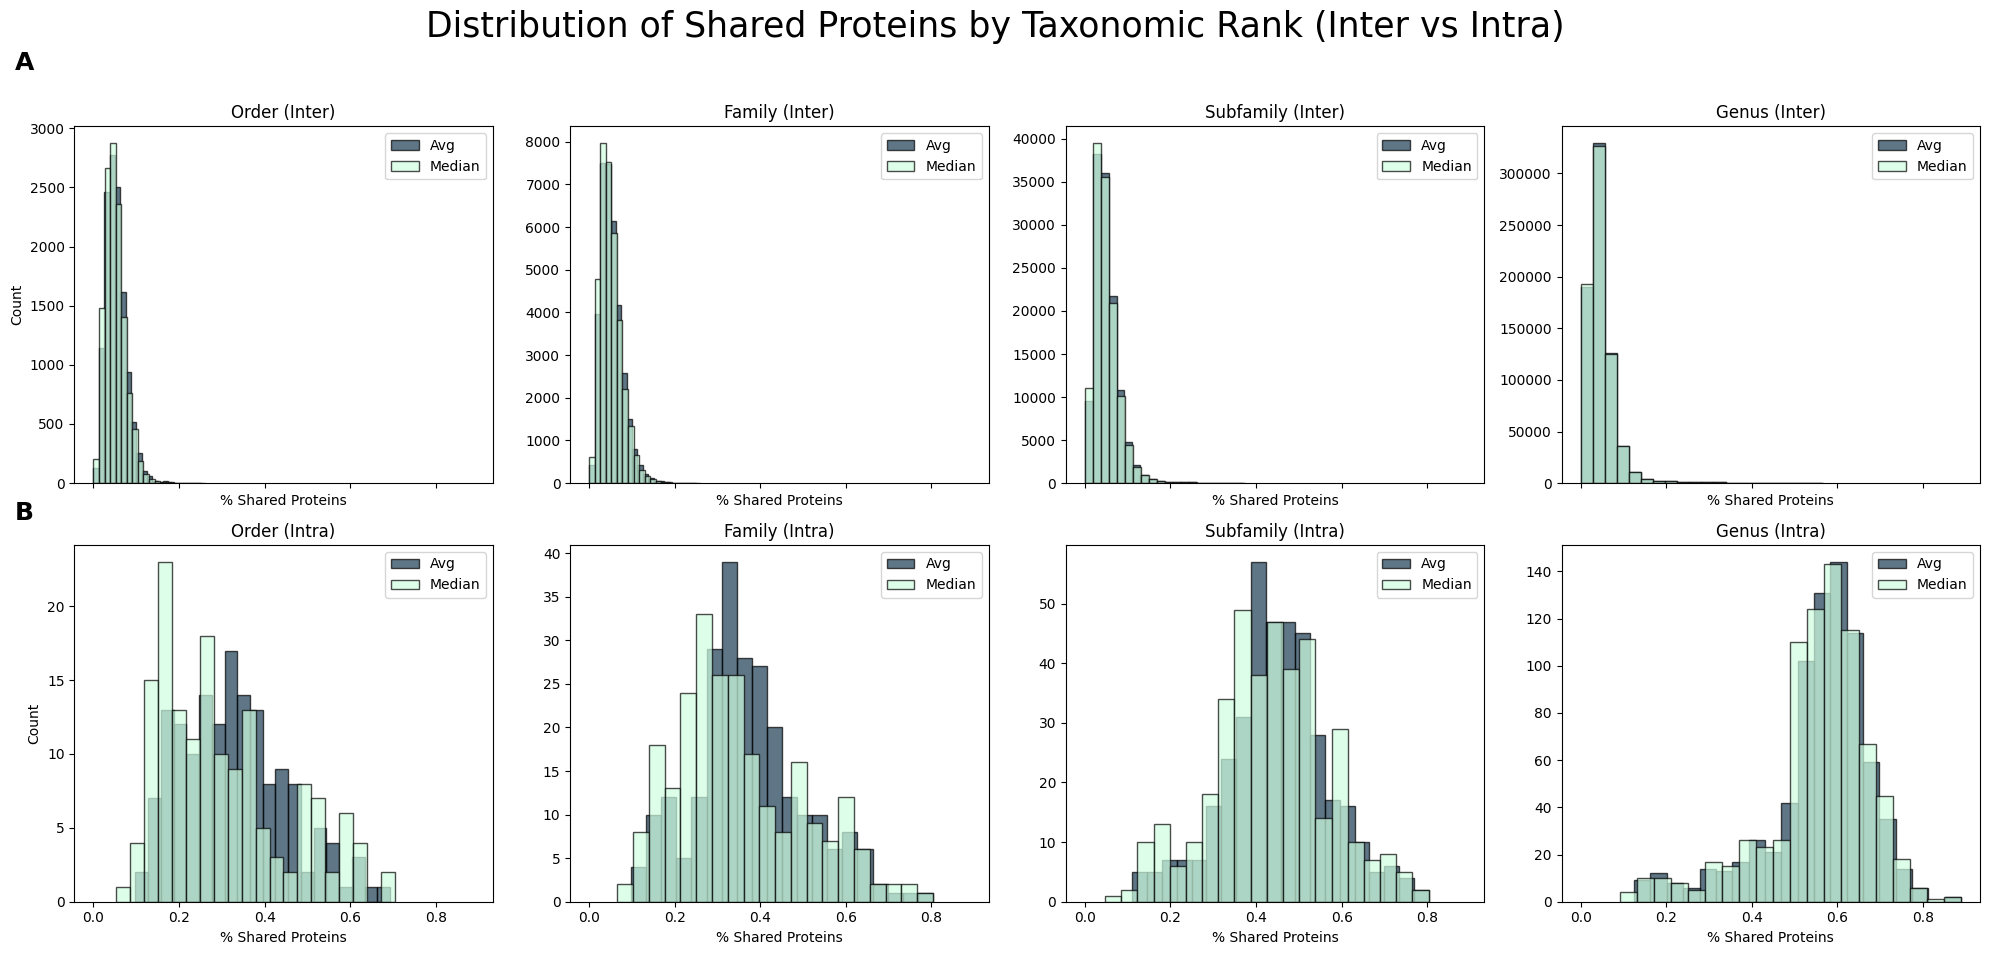

In [61]:
# Set up 2x4 subplots (rows = inter vs intra, cols = rank)
fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=False)
fig.suptitle("Distribution of Shared Proteins by Taxonomic Rank (Inter vs Intra)", fontsize=25)

avg_color = '#1B3C53'      # dark blue
median_color = '#CFFFE2'   # light green

for j, df in enumerate([inter_rank_relatedness, intra_rank_relatedness]):
    context = "Inter" if j == 0 else "Intra"
    for i, rank in enumerate(ranks):
        subset = df[df['rank'] == rank]
        ax = axs[j, i]
        if context == "Inter":
            ax.hist(subset['inter_avg_shared_proteins'], bins=20, alpha=0.7, label='Avg',
                    edgecolor='black', color=avg_color)
            ax.hist(subset['inter_median_shared_proteins'], bins=20, alpha=0.7, label='Median',
                    edgecolor='black', color=median_color)
        else:
            ax.hist(subset['intra_avg_shared_proteins'], bins=20, alpha=0.7, label='Avg',
                    edgecolor='black', color=avg_color)
            ax.hist(subset['intra_median_shared_proteins'], bins=20, alpha=0.7, label='Median',
                    edgecolor='black', color=median_color)

        ax.set_title(f"{rank} ({context})")
        ax.set_xlabel("% Shared Proteins")
        if i == 0:
            ax.set_ylabel("Count")
        ax.legend()

fig.text(0.01, 0.92, "A", fontsize=18, fontweight='bold')
fig.text(0.01, 0.47, "B", fontsize=18, fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("../plots/inter_vs_intra_shared_protein_distributions.png", dpi=300, bbox_inches="tight")
plt.show()

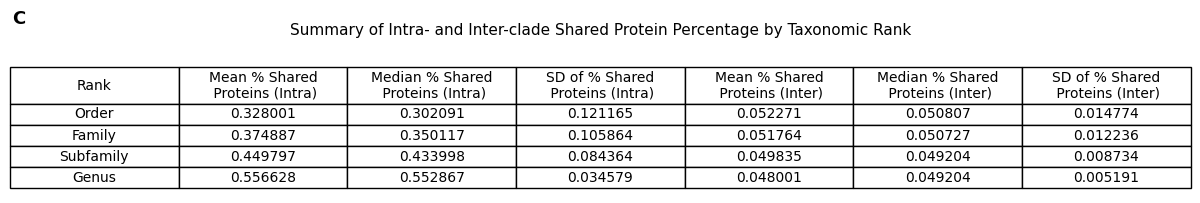

In [68]:
import matplotlib.pyplot as plt
import pandas as pd

# Data from the image
data = {
    "Rank": ["Order", "Family", "Subfamily", "Genus"],
    "Mean % Shared\n Proteins (Intra)": [0.328001, 0.374887, 0.449797, 0.556628],
    "Median % Shared\n Proteins (Intra)": [0.302091, 0.350117, 0.433998, 0.552867],
    "SD of % Shared\n Proteins (Intra)": [0.121165, 0.105864, 0.084364, 0.034579],
    "Mean % Shared\n Proteins (Inter)": [0.052271, 0.051764, 0.049835, 0.048001],
    "Median % Shared\n Proteins (Inter)": [0.050807, 0.050727, 0.049204, 0.049204],
    "SD of % Shared\n Proteins (Inter)": [0.014774, 0.012236, 0.008734, 0.005191]
}

df = pd.DataFrame(data)

# Plot table
fig, ax = plt.subplots(figsize=(12, 2))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values,
                 colLabels=df.columns,
                 loc='center',
                 cellLoc='center',
                 colLoc='center')

# Styling
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

# Increase height of header row
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_height(0.28)  # Adjust this value as needed

# Title
plt.title("Summary of Intra- and Inter-clade Shared Protein Percentage by Taxonomic Rank",
          fontsize=11, pad=20)
fig.text(0.01, 0.92, "C", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig("../plots/supplementary_table_intra_inter_%_shared.png", dpi=300, bbox_inches='tight')
plt.show()

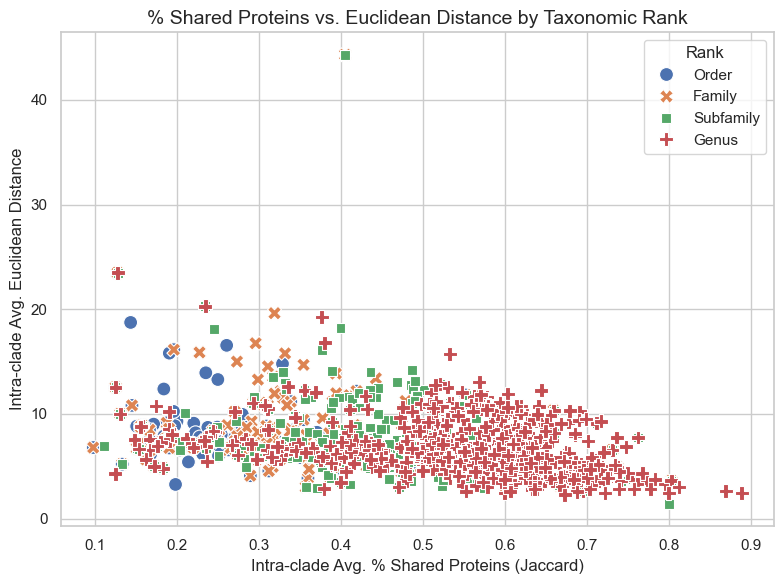

In [70]:
# Set seaborn style
sns.set(style="whitegrid")

# Create seaborn scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=intra_rank_relatedness,
    x='intra_avg_shared_proteins',
    y='intra_avg_euclidean',
    hue='rank',
    style='rank',
    s=100,
    palette='deep'
)

plt.title('% Shared Proteins vs. Euclidean Distance by Taxonomic Rank', fontsize=14)
plt.xlabel('Intra-clade Avg. % Shared Proteins (Jaccard)', fontsize=12)
plt.ylabel('Intra-clade Avg. Euclidean Distance', fontsize=12)
plt.legend(title='Rank')
plt.tight_layout()

# Save the figure
output_path = "../plots/intra_similarity_by_rank_plot_30_06_25.png"
plt.savefig(output_path, dpi=300)
plt.show()

plt.close()

# 5. Test classifier on held-out ictv sequences..

In [33]:
# Import foldseek search hits of test 10k novel phage sequences
search = pd.read_csv('../data/foldseek_easy_cluster/phagepleats_test_search/search_result.tsv', sep='\t', header=None)
search.columns = ['query','target','fident','alnlen','mismatch','gapopen','qstart','qend','tstart','tend','evalue','bits']

In [34]:
search.shape

(283229, 12)

In [35]:
genome_prot_map = pd.read_csv('../data/foldseek_easy_cluster/phagepleats_test_search/genome_protein_map.csv')

In [36]:
# Merge to add 'query_genome' from genome_prot_map based on the 'query' column
search = search.merge(
    genome_prot_map.rename(columns={'protein': 'query', 'genome': 'query_genome'}),
    on='query',
    how='left'
)

In [37]:
search['target'] = search['target'].str.replace('.pdb','')

# Extract index from presence_absence
index = training_matrix['cluster_ID_function']

unique_genomes = sorted(search['query_genome'].astype(str).unique())

# Create an empty DataFrame with the specified index and columns
input_df = pd.DataFrame(index=index, columns=unique_genomes)

# Extract unique clusters and genomes
cluster_reps = search['target'].unique()
genomes = search['query_genome'].unique()

# Loop through clusters and update presence DataFrame
for genome in tqdm(genomes, desc="Checking genome presence"):
    genome_clusters = search[search['query_genome'] == genome]['target']
    
    if not genome_clusters.empty:
        # Create a mask for the index
        mask = input_df.index.str.contains('|'.join(genome_clusters), na=False)
        
        # Update the presence DataFrame
        input_df.loc[mask, genome] = 1

Checking genome presence: 100%|████████████████████████████████████████████████████| 1718/1718 [04:51<00:00,  5.90it/s]


In [295]:
# Find unique genome values in genome_prot_map that are NOT in input_df.columns
missing_genomes = genome_prot_map['genome'][~genome_prot_map['genome'].isin(input_df.columns)].unique()
print(missing_genomes)

[]


In [38]:
input_df = input_df.fillna(0)
input_df_T = input_df.T
input_df_T = input_df_T[training_matrix_T.columns]
input_df_T = input_df_T[input_df_T.index != 'nan']

In [39]:
import os
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

def load_models_from_folder(folder_path):
    models = {}
    for fname in os.listdir(folder_path):
        if fname.endswith(".pkl"):
            taxon = fname.replace(".pkl", "")
            full_path = os.path.join(folder_path, fname)
            with open(full_path, "rb") as f:
                models[taxon] = pickle.load(f)
    return models

def predict_from_models(X, models, rank):
    prob_list = []  # To store the probability columns for concatenation later
    pred_labels = []
    pred_scores = []

    for taxon, model in tqdm(models.items(), desc=f"Predicting for {rank}"):
        probs = model.predict_proba(X)[:, 1]  # probability of class 1
        prob_list.append(probs)

    prob_matrix = pd.DataFrame(np.column_stack(prob_list), index=X.index, columns=models.keys())

    # Get the predicted labels (highest probability for each row)
    pred_labels = prob_matrix.idxmax(axis=1)
    pred_scores = prob_matrix.max(axis=1)

    # Combine predictions into a DataFrame
    df_out = pd.DataFrame({
        f"{rank}": pred_labels,
        f"{rank}_prob": pred_scores
    }, index=X.index)

    return df_out, prob_matrix

def predict_all_ranks(X, ranks=["Order", "Family", "Subfamily", "Genus"], model_base="models/production"):
    all_preds = []
    os.makedirs("rank_probabilities", exist_ok=True)

    for rank in ranks:
        print(f"\n🔮✨ Predicting for rank: {rank}")
        model_path = os.path.join(model_base, rank)
        if not os.path.exists(model_path):
            print(f"❌ No model directory for {rank}: {model_path}")
            continue

        models = load_models_from_folder(model_path)
        if not models:
            print(f"⚠️ No models found in {model_path}")
            continue

        df_rank, df_proba = predict_from_models(X, models, rank)
        df_rank.index = X.index
        all_preds.append(df_rank)

        # Save the full probability matrix for this rank
        df_proba.to_csv(f"rank_probabilities/{rank}_proba.csv")

    # Concatenate all ranks into one final DataFrame
    final_df = pd.concat(all_preds, axis=1)
    final_df.index.name = "Genome"
    final_df.reset_index().to_csv("final_predictions_ictv_vmr40.csv", index=False)

    print("\n✅ Final predictions saved to 'final_predictions.csv'")
    print("📂 Full probability matrices saved to 'rank_probabilities/'")

    return final_df

In [40]:
ictv_vmr39_predictions = predict_all_ranks(input_df_T, model_base='../data/models/production/')


🔮✨ Predicting for rank: Order


Predicting for Order: 100%|██████████████████████████████████████████████████████████| 159/159 [00:45<00:00,  3.47it/s]



🔮✨ Predicting for rank: Family


Predicting for Family: 100%|█████████████████████████████████████████████████████████| 267/267 [01:13<00:00,  3.62it/s]



🔮✨ Predicting for rank: Subfamily


Predicting for Subfamily: 100%|██████████████████████████████████████████████████████| 502/502 [02:12<00:00,  3.79it/s]



🔮✨ Predicting for rank: Genus


Predicting for Genus: 100%|████████████████████████████████████████████████████████| 1189/1189 [05:07<00:00,  3.87it/s]



✅ Final predictions saved to 'final_predictions.csv'
📂 Full probability matrices saved to 'rank_probabilities/'


In [41]:
# Test models on new data
ictv_vmr40 = pd.read_excel('../data/VMR_MSL40.v1.20250307.xlsx',sheet_name=1)
caudo = ictv_vmr40[ictv_vmr40.Class=='Caudoviricetes']

ictv_metadata = pd.read_csv('../data/4083_ICTV_metadata')

test_phages = caudo[~caudo['Virus GENBANK accession'].isin(ictv_metadata['Virus GENBANK accession']) & 
                  ~caudo['Virus GENBANK accession'].isin(ictv_metadata['genome_accn'])]

C:\Users\crtuser\anaconda3\envs\folding\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
C:\Users\crtuser\anaconda3\envs\folding\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [42]:
ictv_vmr39_predictions = ictv_vmr39_predictions.rename(columns={"Order":'Order_Pred',
                                       "Family":'Family_Pred',
                                       "Subfamily":'Subfamily_Pred',
                                       "Genus":'Genus_Pred'})

In [43]:
ictv_vmr39_predictions = ictv_vmr39_predictions.merge(test_phages, left_on=ictv_vmr39_predictions.index, right_on='Virus GENBANK accession')

In [44]:
df = ictv_vmr39_predictions

In [45]:
df[0:1]

Order_Pred  Order_prob        Family_Pred  Family_prob  \
0  Rountreevirales        0.08  Rountreeviridae_1         0.08   

      Subfamily_Pred  Subfamily_prob      Genus_Pred  Genus_prob  Isolate ID  \
0  Rakietenvirinae_2            0.05  Epaquintavirus        0.12  VMR1001916   

   Species Sort  ...       ICTV_ID Exemplar or additional isolate  \
0          2612  ...  ICTV20150189                              E   

          Virus name(s) Virus name abbreviation(s)  Virus isolate designation  \
0  Bacillus phage SPG24                        NaN                        NaN   

  Virus GENBANK accession  Genome coverage Genome  Host source  \
0                AB930182  Complete genome  dsDNA     bacteria   

   Accessions Link  
0  NCBI Nucleotide  

[1 rows x 36 columns]

In [46]:
order_accuracy = df[df.Order.notna()]
family_accuracy = df[df.Family.notna()]
family_accuracy = family_accuracy[family_accuracy.Family.isin(ictv_metadata.Family.to_list())]
subfamily_accuracy = df[df.Subfamily.notna()]
subfamily_accuracy = subfamily_accuracy[subfamily_accuracy.Subfamily.isin(ictv_metadata.Subfamily.to_list())]
genus_accuracy = df[df.Genus.notna()]
genus_accuracy = genus_accuracy[genus_accuracy.Genus.isin(ictv_metadata.Genus.to_list())]


order_predicted_correct = order_accuracy[order_accuracy.Order_Pred.str.split('_').str[0] == order_accuracy.Order]
family_predicted_correct = family_accuracy[family_accuracy.Family_Pred.str.split('_').str[0] == family_accuracy.Family]
subfamily_predicted_correct = subfamily_accuracy[subfamily_accuracy.Subfamily_Pred.str.split('_').str[0] == subfamily_accuracy.Subfamily]
genus_predicted_correct = genus_accuracy[genus_accuracy.Genus_Pred.str.split('_').str[0]  == genus_accuracy.Genus]

In [47]:
order_accuracy.shape

(603, 36)

In [48]:
order_predicted_correct.shape

(602, 36)

In [49]:
# which one was incorrect??
602/603

0.9983416252072969

In [50]:
family_accuracy.shape

(854, 36)

In [51]:
family_predicted_correct.shape

(785, 36)

In [52]:
785/854

0.9192037470725996

In [53]:
subfamily_accuracy.shape

(1019, 36)

In [54]:
subfamily_predicted_correct.shape

(941, 36)

In [55]:
941/1019

0.9234543670264965

In [56]:
genus_accuracy.shape

(1141, 36)

In [57]:
genus_predicted_correct.shape

(998, 36)

In [58]:
998/1141

0.8746713409290097

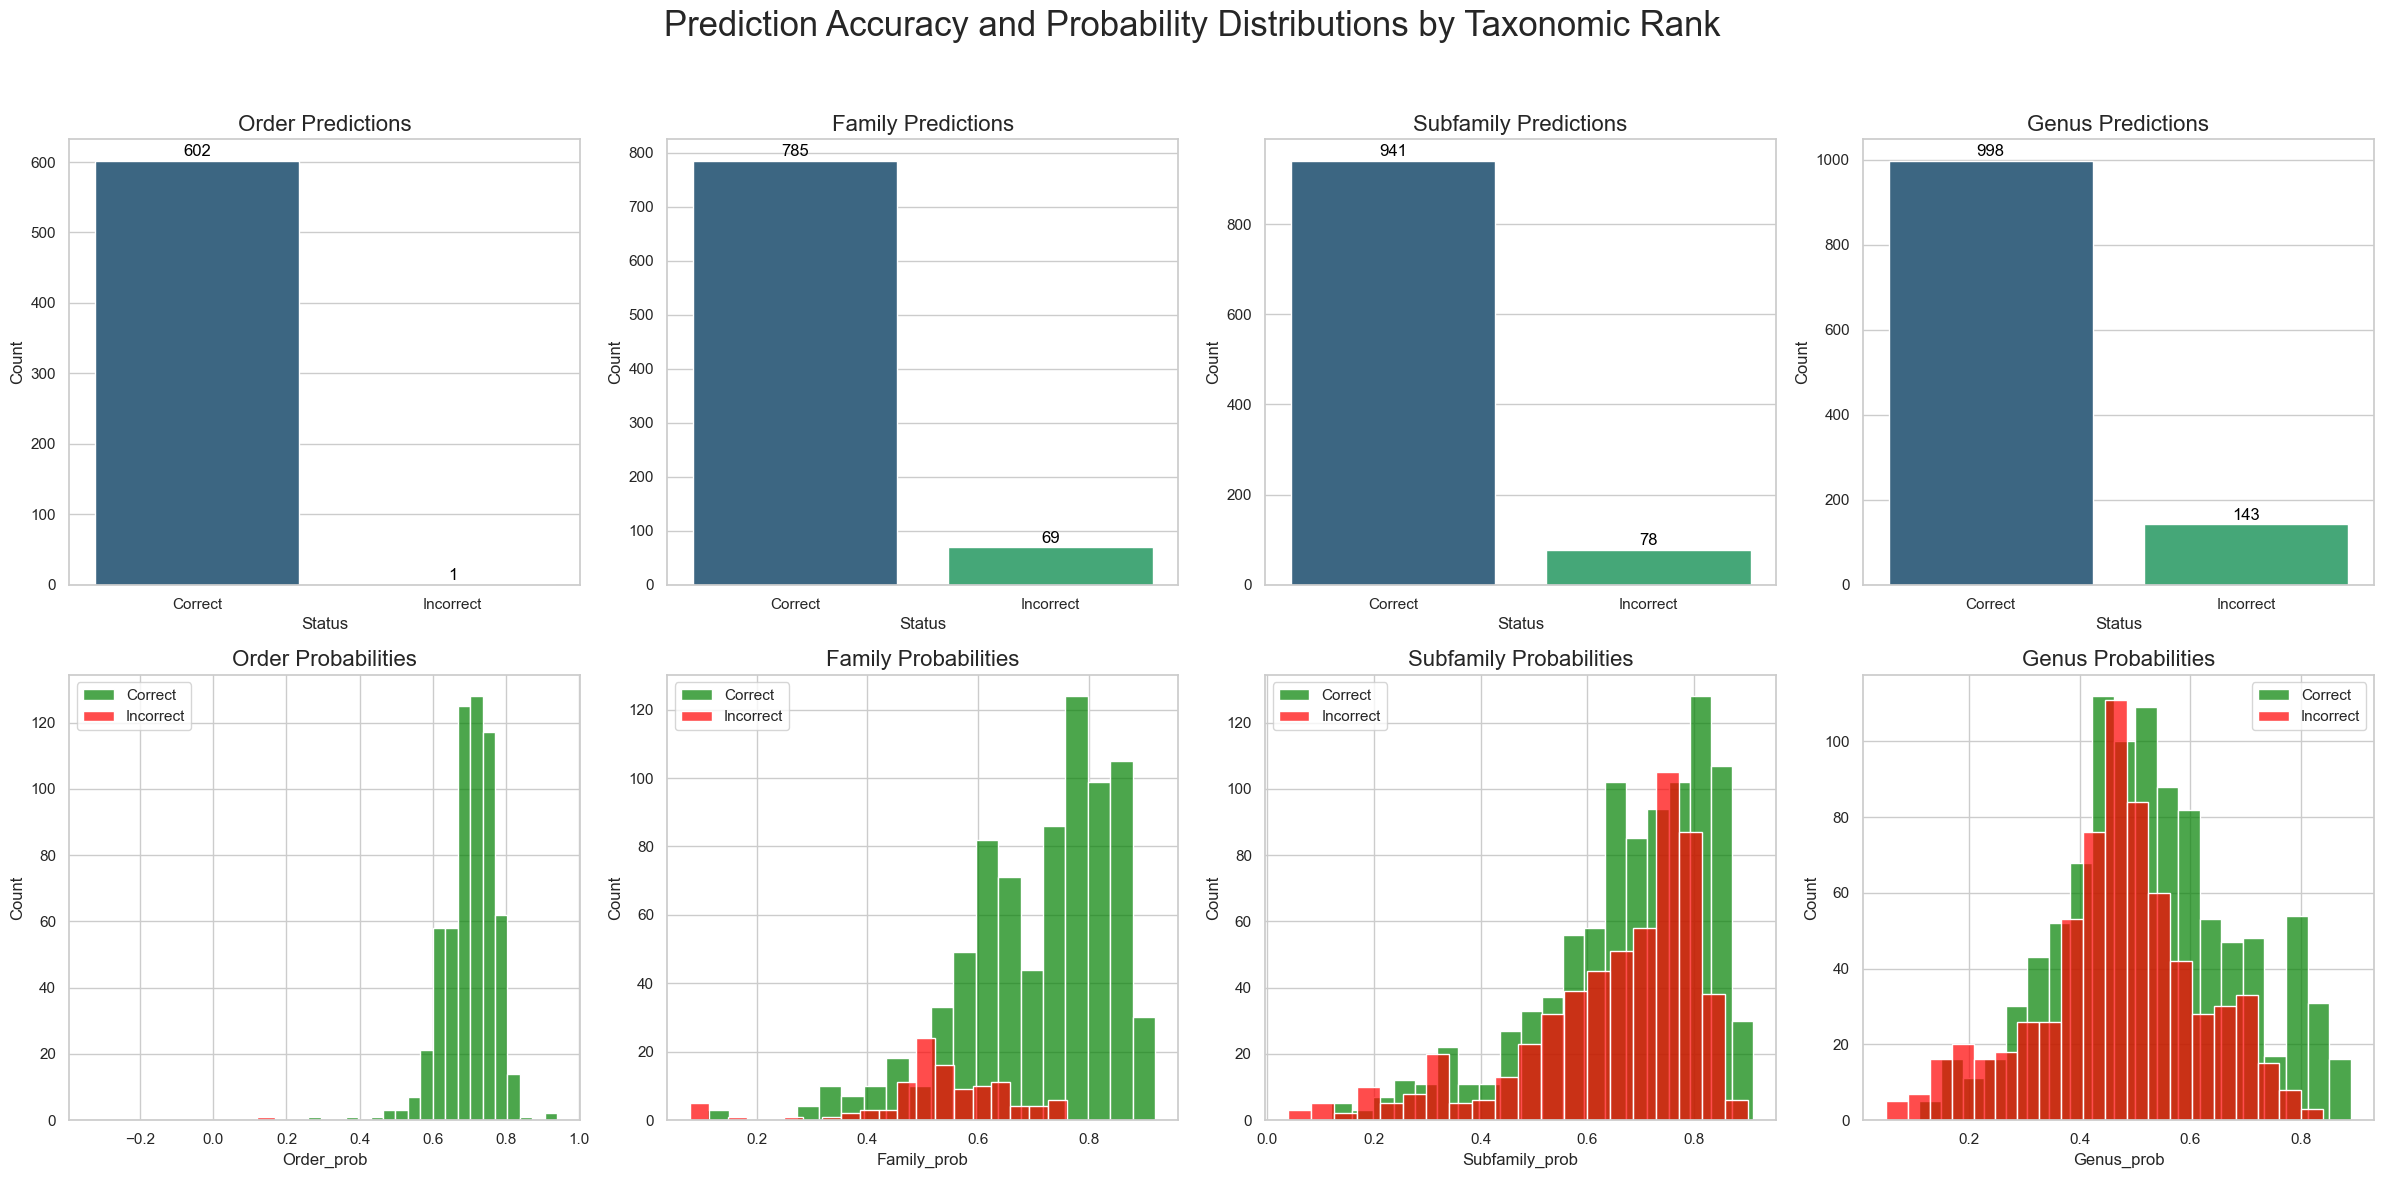

In [371]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define correct and incorrect counts
correct_order_count = len(order_predicted_correct)
incorrect_order_count = len(order_accuracy) - correct_order_count

correct_family_count = len(family_predicted_correct)
incorrect_family_count = len(family_accuracy) - correct_family_count

correct_subfamily_count = len(subfamily_predicted_correct)
incorrect_subfamily_count = len(subfamily_accuracy) - correct_subfamily_count

correct_genus_count = len(genus_predicted_correct)
incorrect_genus_count = len(genus_accuracy) - correct_genus_count

# Incorrect predictions for probability histogram
incorrect_order_predictions = order_accuracy[order_accuracy['Order_Pred'] != order_accuracy['Order']]['Order_prob']
incorrect_family_predictions = family_accuracy[family_accuracy['Family_Pred'] != family_accuracy['Family']]['Family_prob']
incorrect_subfamily_predictions = subfamily_accuracy[subfamily_accuracy['Subfamily_Pred'] != subfamily_accuracy['Subfamily']]['Subfamily_prob']
incorrect_genus_predictions = genus_accuracy[genus_accuracy['Genus_Pred'] != genus_accuracy['Genus']]['Genus_prob']

# Correct predictions for probability histogram
order_correct_probs = order_predicted_correct['Order_prob']
family_correct_probs = family_predicted_correct['Family_prob']
subfamily_correct_probs = subfamily_predicted_correct['Subfamily_prob']
genus_correct_probs = genus_predicted_correct['Genus_prob']

# Helper for bar count annotations
def add_count_annotations(ax):
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', 
                    fontsize=12, color='black', 
                    xytext=(0, 1), textcoords='offset points')

# Create subplots (2 rows × 4 cols)
fig, axes = plt.subplots(2, 4, figsize=(24, 12))

# ------------- Accuracy barplots (Top Row) -------------
# ORDER
order_df = pd.DataFrame({
    'Status': ['Correct', 'Incorrect'],
    'Count': [correct_order_count, incorrect_order_count]
})
sns.barplot(data=order_df, x='Status', y='Count', hue='Status', ax=axes[0, 0], palette='viridis', legend=False)
axes[0, 0].set_title('Order Predictions', fontsize=16)
add_count_annotations(axes[0, 0])

# FAMILY
family_df = pd.DataFrame({
    'Status': ['Correct', 'Incorrect'],
    'Count': [correct_family_count, incorrect_family_count]
})
sns.barplot(data=family_df, x='Status', y='Count', hue='Status', ax=axes[0, 1], palette='viridis', legend=False)
axes[0, 1].set_title('Family Predictions', fontsize=16)
add_count_annotations(axes[0, 1])

# SUBFAMILY
subfamily_df = pd.DataFrame({
    'Status': ['Correct', 'Incorrect'],
    'Count': [correct_subfamily_count, incorrect_subfamily_count]
})
sns.barplot(data=subfamily_df, x='Status', y='Count', hue='Status', ax=axes[0, 2], palette='viridis', legend=False)
axes[0, 2].set_title('Subfamily Predictions', fontsize=16)
add_count_annotations(axes[0, 2])

# GENUS
genus_df = pd.DataFrame({
    'Status': ['Correct', 'Incorrect'],
    'Count': [correct_genus_count, incorrect_genus_count]
})
sns.barplot(data=genus_df, x='Status', y='Count', hue='Status', ax=axes[0, 3], palette='viridis', legend=False)
axes[0, 3].set_title('Genus Predictions', fontsize=16)
add_count_annotations(axes[0, 3])

# ------------- Probability Histograms (Bottom Row) -------------

# ORDER
sns.histplot(order_correct_probs, ax=axes[1, 0], color='green', label='Correct', bins=20, alpha=0.7)
sns.histplot(incorrect_order_predictions, ax=axes[1, 0], color='red', label='Incorrect', bins=20, alpha=0.7)
axes[1, 0].set_title('Order Probabilities', fontsize=16)
axes[1, 0].legend()

# FAMILY
sns.histplot(family_correct_probs, ax=axes[1, 1], color='green', label='Correct', bins=20, alpha=0.7)
sns.histplot(incorrect_family_predictions, ax=axes[1, 1], color='red', label='Incorrect', bins=20, alpha=0.7)
axes[1, 1].set_title('Family Probabilities', fontsize=16)
axes[1, 1].legend()

# SUBFAMILY
sns.histplot(subfamily_correct_probs, ax=axes[1, 2], color='green', label='Correct', bins=20, alpha=0.7)
sns.histplot(incorrect_subfamily_predictions, ax=axes[1, 2], color='red', label='Incorrect', bins=20, alpha=0.7)
axes[1, 2].set_title('Subfamily Probabilities', fontsize=16)
axes[1, 2].legend()

# GENUS
sns.histplot(genus_correct_probs, ax=axes[1, 3], color='green', label='Correct', bins=20, alpha=0.7)
sns.histplot(incorrect_genus_predictions, ax=axes[1, 3], color='red', label='Incorrect', bins=20, alpha=0.7)
axes[1, 3].set_title('Genus Probabilities', fontsize=16)
axes[1, 3].legend()

# Final layout
fig.suptitle('Prediction Accuracy and Probability Distributions by Taxonomic Rank', fontsize=25)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
fig.savefig("../plots/ictv_vmr40_taxa_predictions_accuracy_and_probabilities.png", dpi=300, bbox_inches='tight')

# 6. Hierarchical classification

Step 2: Implement Hierarchical Prediction

You can build a pipeline that performs the hierarchical predictions as follows:

    Train separate models for each level of classification (Order, Family, Subfamily, Genus).
    For each sample, make the order prediction first.
    Filter classifiers at the next level (Family) to use only those models that correspond to the predicted order.
    Repeat the process for the Subfamily and Genus levels, filtering down to the relevant classifiers.

1. Load All Order Models

    Load trained classifiers for Order level only (you don’t need families/genera yet).
    Keep them in a dictionary {order_name: model}.

2. Predict Order Labels & Probabilities

    For each input genome (row), predict probabilities across all Order classifiers.

    Assign the best predicted order based on the highest probability.

3. Load and Predict Family Models (per Order)

    Group all genomes by predicted Order.

    For each Order group, load its corresponding Family models.

    Predict Family labels for all genomes in that Order.

    Assign the best Family based on probability.

4. Load and Predict Subfamily and Genus (Hierarchically)

    Repeat the same logic:
        Group genomes by predicted Family → Load relevant Subfamily models → Predict.
        Group genomes by predicted Subfamily → Load relevant Genus models → Predict.
    Store results in a hierarchical DataFrame.

# Create taxa mappings

In [6]:
orders_hierarchy = {}

# Assuming taxa_df has columns 'Order', 'Family', 'Subfamily', 'Genus'
for _, row in taxa_df.iterrows():
    order = row['Order']
    
    # Only assign to family, subfamily, and genus if they are not NaN
    family = row.get('Family') if pd.notna(row.get('Family')) else None
    subfamily = row.get('Subfamily') if pd.notna(row.get('Subfamily')) else None
    genus = row.get('Genus') if pd.notna(row.get('Genus')) else None

    # Skip row if any key is None (i.e., missing)
    if pd.isna(family) or pd.isna(subfamily) or pd.isna(genus):
        continue

    # Initialize the order key if not already present
    if order not in orders_hierarchy:
        orders_hierarchy[order] = {'Family': set()}

    # Add the family to the families set
    orders_hierarchy[order]['Family'].add(family)

    # Initialize family if not present
    if family not in orders_hierarchy[order]:
        orders_hierarchy[order][family] = {'Subfamily': set()}

    # Add the subfamily to the subfamilies set
    orders_hierarchy[order][family]['Subfamily'].add(subfamily)

    # Initialize subfamily if not present
    if subfamily not in orders_hierarchy[order][family]:
        orders_hierarchy[order][family][subfamily] = {'Genus': set()}

    # Add the genus to the genera set
    orders_hierarchy[order][family][subfamily]['Genus'].add(genus)

# Ensure the orders exist before assigning a family
for order in ['Verdandivirales', 'Dunevirales', 'Graavivirales', 'Kirjokansivirales']:
    if order not in orders_hierarchy:
        orders_hierarchy[order] = {}  # Initialize the order key
    
    orders_hierarchy[order]['Family'] = {'Unknown'}

# Example queries:
# Get all families under a specific order
# orders_hierarchy[order]['families']

# Get all subfamilies under a specific family
# orders_hierarchy[order][family]['subfamilies']

# Get all genera under a specific subfamily
# orders_hierarchy[order][family][subfamily]['genera']

In [7]:
orders_hierarchy.keys()

dict_keys(['Casjensvirales', 'Strabovirales', 'Crassvirales', 'Drexlervirales', 'Aliceevansvirales', 'Peduovirales', 'Rountreevirales', 'Orlajensenvirales', 'Verdandivirales', 'Dunevirales', 'Graavivirales', 'Kirjokansivirales'])

In [19]:
import os
import pandas as pd
import logging
import pickle
from tqdm import tqdm

# Setup logging
logging.basicConfig(level=logging.INFO)

def load_model(model_path):
    """Load a machine learning model from a .pkl file."""
    try:
        with open(model_path, "rb") as f:
            return pickle.load(f)
    except Exception as e:
        logging.error(f"Failed to load model {model_path}: {e}")
        return None

def predict_level(df, models_dict, level_name):
    """Predict a hierarchical level and return predictions with probabilities."""
    predictions = {}
    
    for label, model in tqdm(models_dict.items(), desc=f"Predicting {level_name}"):
        probs = model.predict_proba(df)[:, 1]  # Assume binary classification
        predictions[label] = probs
    
    df_predictions = pd.DataFrame(predictions, index=df.index)
    df_predictions[f"{level_name}_Prob"] = df_predictions.max(axis=1)
    df_predictions[f"{level_name}_Pred"] = df_predictions.idxmax(axis=1)
    
    return df_predictions[[f"{level_name}_Pred", f"{level_name}_Prob"]]

def get_models(model_dir, level):
    """Load models for a specific hierarchical level."""
    model_files = [f for f in os.listdir(os.path.join(model_dir, level)) if f.endswith('.pkl')]
    return {f.replace('.pkl', ''): load_model(os.path.join(model_dir, level, f)) for f in tqdm(model_files, desc=f"Loading {level} models")}

def process_level(df, parent_predictions, hierarchy, level_name, models_dir, parent_level):
    """Process hierarchical classification for a given level."""
    level_predictions = []

    grouped = list(parent_predictions.groupby(f'{parent_level}_Pred'))  # Convert to list to get length
    for parent, group in grouped:
        if level_name == 'Order' or level_name == 'Family':
            children = hierarchy.get(parent, {}).get(level_name, [])
            print(children)
        elif level_name == 'Subfamily':
            order = group['Order_Pred']
            family = group['Family_Pred']
            children = []
            for o, f in zip(order, family):
                children.extend(hierarchy.get(o, {}).get(f, {}).get(level_name, []))  
            children = list(set(children))  # Remove duplicates
        elif level_name == 'Genus':
            children = []
            order = group['Order_Pred']
            family = group['Family_Pred']
            subfamily = group['Subfamily_Pred']
            for o, f, s in zip(order, family, subfamily):
                children = hierarchy.get(o, {}).get(f, {}).get(s, {}).get(level_name, [])
        
        # If no children found, assign 'Unknown'
        if not children or children == {'Unknown'}:
            df_unknown = pd.DataFrame({
                f'{level_name}_Pred': ['Unknown'] * len(group),
                f'{level_name}_Prob': [0.0] * len(group)  # Set probability to 0
            }, index=group.index)
            level_predictions.append(df_unknown)
            continue  # Skip model loading for unknowns
        
        # Load models for children
        level_models = {child: load_model(os.path.join(models_dir, level_name, f"{child}.pkl")) 
                        for child in children if os.path.isfile(os.path.join(models_dir, level_name, f"{child}.pkl"))}
        
        df_level = predict_level(df.loc[group.index], level_models, level_name)
        df_level[f'{parent_level}_Pred'] = parent  # Maintain hierarchy
        level_predictions.append(df_level)
    
    return pd.concat(level_predictions) if level_predictions else pd.DataFrame()

def merge_and_rename(df1, df2, merge_cols, new_col_name_dict=None):
    """Merge two DataFrames on the index and rename columns if needed."""
    # Merge the two DataFrames
    merged_df = df1.merge(df2, left_index=True, right_index=True)

    # Rename columns as needed
    if new_col_name_dict:
        merged_df = merged_df.rename(columns=new_col_name_dict)

    # Drop duplicate columns (if any)
    for col in merge_cols:
        if f"{col}_y" in merged_df.columns:
            merged_df = merged_df.drop(f"{col}_y", axis=1)
        if f"{col}_x" in merged_df.columns:
            merged_df = merged_df.rename(columns={f"{col}_x": col})

    return merged_df

def hierarchical_classification(df_input, models_dir, hierarchy):
    """Run the hierarchical classification pipeline."""
    
    # Predict Order level
    df_orders = predict_level(df_input, get_models(models_dir, "Order"), "Order")
    
    # Predict Family level
    df_families = process_level(df_input, df_orders, hierarchy, "Family", models_dir, "Order")
    
    # Merge Order and Family predictions
    df_orders_families_pred = merge_and_rename(
        df_orders[['Order_Pred', 'Order_Prob']], 
        df_families, 
        merge_cols=['Order_Pred'],
        new_col_name_dict={'Family_Pred_x': 'Family_Pred'}
    )

    print(df_orders_families_pred)
    print(df_orders_families_pred.columns)
    # Predict Subfamily level
    df_subfamilies = process_level(df_input, df_orders_families_pred, hierarchy, "Subfamily", models_dir, "Family")
    
    # Merge Order, Family, and Subfamily predictions
    df_orders_families_subfamilies_pred = merge_and_rename(
        df_orders_families_pred[['Order_Pred', 'Order_Prob', 'Family_Pred', 'Family_Prob']],
        df_subfamilies,
        merge_cols=['Order_Pred', 'Family_Pred'],
        new_col_name_dict={'Subfamily_Pred_x': 'Subfamily_Pred'}
    )
    
    # Predict Genus level
    df_genus = process_level(df_input, df_orders_families_subfamilies_pred, hierarchy, "Genus", models_dir, "Subfamily")
    df_genus = df_genus[['Genus_Pred', 'Genus_Prob']]
    
    # Final merge with Genus predictions
    df_final = df_orders_families_subfamilies_pred.merge(df_genus, left_index=True, right_index=True)
    
    print('Predictions complete.')
    return df_final

In [20]:
predictions = hierarchical_classification(input_df_T, MODEL_DIR, orders_hierarchy)

Predicting Order: 100%|████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.08it/s]


{'Aliceevansviridae_1'}


Predicting Family: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.47it/s]


{'Family_39', 'Family_67', 'Family_43', 'Family_27', 'Family_46', 'Family_25', 'Family_41', 'Family_51', 'Chaseviridae', 'Family_15', 'Family_71', 'Family_60', 'Family_14', 'Family_62', 'Aliceevansviridae_2', 'Family_10', 'Family_11', 'Family_32', 'Family_22', 'Vilmaviridae', 'Family_7', 'Family_8', 'Family_4', 'Casjensviridae', 'Family_55', 'Family_23', 'Family_42', 'Family_31', 'Family_72', 'Family_64', 'Family_58', 'Family_40', 'Family_33', 'Family_6', 'Family_66', 'Family_21', 'Family_57', 'Family_54', 'Family_59', 'Family_3', 'Family_50', 'Family_28', 'Family_29'}


Predicting Family: 100%|███████████████████████████████████████████████████████████████| 43/43 [00:03<00:00, 13.13it/s]


{'Steigviridae', 'Autographiviridae', 'Schitoviridae', 'Family_74', 'Autographiviridae_2', 'Suoliviridae', 'Family_75', 'Grimontviridae', 'Intestiviridae', 'Zobellviridae_2', 'Family_73'}


Predicting Family: 100%|███████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.52it/s]


{'Mesyanzhinovviridae_1', 'Family_77', 'Family_87', 'Family_84', 'Family_86', 'Family_81', 'Drexlerviridae', 'Family_80', 'Family_76', 'Family_85', 'Family_78'}


Predicting Family: 100%|███████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.80it/s]


{'Peduoviridae_2', 'Peduoviridae_1'}


Predicting Family: 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.36it/s]


{'Rountreeviridae_1', 'Salasmaviridae_2', 'Rountreeviridae_2', 'Salasmaviridae_1', 'Guelinviridae'}


Predicting Family: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.04it/s]


{'Demerecviridae', 'Kyanoviridae', 'Stanwilliamsviridae', 'Herelleviridae_1', 'Family_91', 'Chimalliviridae', 'Herelleviridae_2', 'Straboviridae', 'Ackermannviridae'}


Predicting Family: 100%|█████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 12.87it/s]


{'Unknown'}
                   Order_Pred  Order_Prob          Family_Pred  Family_Prob
AE006468         Crassvirales        0.27  Autographiviridae_2         0.08
AP018714        Strabovirales        0.41     Herelleviridae_1         0.30
AY319521         Peduovirales        0.32       Peduoviridae_1         0.20
BK063676         Crassvirales        0.32  Autographiviridae_2         0.09
BK063677       Casjensvirales        0.20            Family_23         0.02
...                       ...         ...                  ...          ...
OQ737697      Rountreevirales        0.42        Guelinviridae         0.33
OU734268       Drexlervirales        0.68       Drexlerviridae         0.69
OW251746       Drexlervirales        0.67       Drexlerviridae         0.71
OX365879      Verdandivirales        0.34              Unknown         0.00
QUVN01000024     Peduovirales        0.50       Peduoviridae_1         0.22

[712 rows x 4 columns]
Index(['Order_Pred', 'Order_Prob', 'Family_Pred', 'F

Predicting Genus: 100%|██████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.48it/s]

Predictions complete.


In [25]:
predictions_df = predictions

In [32]:
predictions_df['Virus Accession'] = predictions_df.index.str.strip()
links_retrieved['Genome Accession'] = links_retrieved['Virus REFSEQ accession'].fillna(links_retrieved['Virus GENBANK accession'])
predictions_df_1 = predictions_df.merge(links_retrieved, left_on='Virus Accession', right_on='Genome Accession')
predictions_df_2 = predictions_df.merge(all_metadata, left_on='Virus Accession', right_on='Genome Accession')
predictions_df_final = pd.concat([predictions_df_1, predictions_df_2])

family_accuracy = predictions_df_final[predictions_df_final.Family.notna()]
subfamily_accuracy = predictions_df_final[predictions_df_final.Subfamily.notna()]
genus_accuracy = predictions_df_final[predictions_df_final.Genus.notna()]

family_predicted_correct = family_accuracy[family_accuracy.Family_Pred.str.split('_').str[0] == family_accuracy.Family]
subfamily_predicted_correct = subfamily_accuracy[subfamily_accuracy.Subfamily_Pred.str.split('_').str[0] == subfamily_accuracy.Subfamily]
genus_predicted_correct = genus_accuracy[genus_accuracy.Genus_Pred.str.split('_').str[0]  == genus_accuracy.Genus]

In [29]:
len(family_predicted_correct) / len(family_accuracy)

0.911042944785276

In [30]:
len(subfamily_predicted_correct) / len(subfamily_accuracy)

0.7383177570093458

# Need new cluster reps => foldseek search against cluster reps... 

# 21_02_25 - Yay this is the final code :DDD

In [236]:
# this is the production level code letssss gooooooooo
import os
import pandas as pd
import logging
import pickle
from tqdm import tqdm

# Setup logging
logging.basicConfig(level=logging.INFO)

def load_model(model_path):
    """Load a machine learning model from a .pkl file."""
    try:
        with open(model_path, "rb") as f:
            return pickle.load(f)
    except Exception as e:
        logging.error(f"Failed to load model {model_path}: {e}")
        return None

def predict_level(df, models_dict, level_name, binary=True):
    """Predict a hierarchical level and return predictions with probabilities."""
    predictions = {}
    for label, model in tqdm(models_dict.items(), desc=f"Predicting {level_name}"):
        probs = model.predict_proba(df)[:, 1] if binary else model.predict_proba(df)
        predictions[label] = probs
    
    df_predictions = pd.DataFrame(predictions, index=df.index)
    df_predictions[f"{level_name}_Prob"] = df_predictions.max(axis=1)
    df_predictions[f"{level_name}_Pred"] = df_predictions.idxmax(axis=1)
    
    return df_predictions[[f"{level_name}_Pred", f"{level_name}_Prob"]]

def get_models(model_dir, level):
    """Load models for a specific hierarchical level."""
    model_files = [f for f in os.listdir(os.path.join(model_dir, level)) if f.endswith('.pkl')]
    models = {}
    for model_file in tqdm(model_files, desc=f"Loading {level} models"):
        model_path = os.path.join(model_dir, level, model_file)
        model_name = model_file.replace('.pkl', '')
        models[model_name] = load_model(model_path)
    return models

def process_level(df, parent_predictions, hierarchy, level_name, models_dir, parent_level):
    """Process hierarchical classification for a given level."""
    level_predictions = []
    grouped = parent_predictions.groupby(f'{parent_level}_Pred')

    for parent, group in tqdm(grouped, desc=f"Processing {level_name}"):
        children = get_children_for_level(parent, level_name, group, hierarchy)
        level_models = load_level_models(models_dir, level_name, children)

        df_level = predict_level(df.loc[group.index], level_models, level_name)
        df_level[f'{parent_level}_Pred'] = parent  # Maintain hierarchy
        level_predictions.append(df_level)
    
    return pd.concat(level_predictions) if level_predictions else pd.DataFrame()

def get_children_for_level(parent, level_name, group, hierarchy):
    """Determine child taxa for each hierarchical level."""
    if level_name in ['Order', 'Family']:
        return hierarchy.get(parent, {}).get(level_name, [])
    
    if level_name == 'Subfamily':
        order = group['Order_Pred']
        family = group['Family_Pred']
        children = []
        for o, f in zip(order, family):
            children.extend(hierarchy.get(o, {}).get(f, {}).get(level_name, []))
        return list(set(children))
    
    if level_name == 'Genus':
        order = group['Order_Pred']
        family = group['Family_Pred']
        subfamily = group['Subfamily_Pred']
        children = []
        for o, f, s in zip(order, family, subfamily):
            children.extend(hierarchy.get(o, {}).get(f, {}).get(s, {}).get(level_name, []))
        return children
    
    return []

def load_level_models(models_dir, level_name, children):
    """Load models for the given children taxa at the current hierarchical level."""
    return {child: load_model(os.path.join(models_dir, level_name, f"{child}.pkl")) 
            for child in children if os.path.isfile(os.path.join(models_dir, level_name, f"{child}.pkl"))}

def hierarchical_classification(df_input, models_dir, hierarchy):
    """Run the hierarchical classification pipeline."""
    df_orders = predict_level(df_input, get_models(models_dir, "Order"), "Order")
    df_families = process_level(df_input, df_orders, hierarchy, "Family", models_dir, "Order")
    df_orders_families_pred = df_orders[['Order_Pred', 'Order_Prob']].merge(
        df_families.drop(columns=['Order_Pred']), 
        left_index=True, 
        right_index=True
    )
    df_subfamilies = process_level(df_input, df_orders_families_pred, hierarchy, "Subfamily", models_dir, "Family")
    df_orders_families_subfamilies_pred = df_orders_families_pred[['Order_Pred', 'Order_Prob', 'Family_Pred', 'Family_Prob']].merge(
        df_subfamilies.drop(columns=['Family_Pred']),
        left_index=True, 
        right_index=True
    )
    df_genus = process_level(df_input, df_orders_families_subfamilies_pred, hierarchy, "Genus", models_dir, "Subfamily")
    df_genus = df_genus[['Genus_Pred', 'Genus_Prob']] 

    df_final = df_orders_families_subfamilies_pred.merge(df_genus, 
                                                        left_index=True, 
                                                        right_index=True)
    
    return df_final


In [237]:
hierarchical_classification(df_input, MODEL_DIR, orders_hierarchy)

Processing Family:  83%|██████████████████████████████████████████████████████▏          | 5/6 [00:07<00:01,  1.02s/it]
Predicting Family: 0it [00:00, ?it/s]
Predicting Genus: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.01it/s]

Processing Genus: 100%|██████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.78it/s]


Order_Pred  Order_Prob          Family_Pred  \
AE006468          Casjensvirales        0.19       Casjensviridae   
AP018714           Strabovirales        0.49     Herelleviridae_1   
AY319521            Peduovirales        0.46       Peduoviridae_1   
BK063676          Casjensvirales        0.13  Aliceevansviridae_2   
BK063677          Casjensvirales        0.18            Family_64   
BK063679         Rountreevirales        0.12    Rountreeviridae_1   
BK063680            Crassvirales        0.09       Intestiviridae   
CAJCJZ010000002   Casjensvirales        0.21            Family_25   
CAJDJZ010000002    Strabovirales        0.48     Herelleviridae_1   

                 Family_Prob                   Subfamily_Pred  Subfamily_Prob  \
AE006468                0.12       Casjensviridae_Subfamily_2            0.04   
AP018714                0.40                     Brockvirinae            0.49   
AY319521                0.24       Peduoviridae_1_Subfamily_1            0.21   
BK063676                0.02  Aliceevansviridae_2_Subfamily_2            0.00   
BK063677                0.03            Jameshumphriesvirinae            0.03   
BK063679                0.10    Rountreeviridae_1_Subfamily_1            0.11   
BK063680                0.06                    Coarsevirinae            0.04   
CAJCJZ010000002         0.08            Family_25_Subfamily_2            0.04   
CAJDJZ010000002         0.36                     Brockvirinae            0.47   

                      Genus_Pred  Genus_Prob  
AE006468              Chivirus_2        0.02  
AP018714         Kochikohdavirus        0.40  
AY319521              Elveevirus        0.13  
BK063676          Brussowvirus_1        0.00  
BK063677            Sircambvirus        0.00  
BK063679           Badaztecvirus        0.03  
BK063680              Junduvirus        0.01  
CAJCJZ010000002      Camtrevirus        0.01  
CAJDJZ010000002  Kochikohdavirus        0.34